In [1]:
library(devtools)
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/metacell_functions.r")
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/pic_parser.r")
library(GEOquery)
library(googlesheets4)
library(googledrive)
library(metacell)
library(ggplot2)
library(ggrepel)
library(dplyr)
library(gridExtra)
library(tidyverse)
library(grid)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(ComplexHeatmap)
library(grid)
library(GOfuncR)
library(cowplot)
library(shades)
library(circlize)
library(tglkmeans)
library(ggplot2)
library(tidyverse)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(babelgene)
library(zellkonverter)
library(liana)
library(ComplexHeatmap)
library(grid)
library(cowplot)
library(R.utils)
library(rstatix) 
library(RVAideMemoire)
library(cluster)   
library(factoextra) 
library(ggpmisc)
library(glmGamPoi)
library(MASS)
library(clusterProfiler)
library(msigdbr)

Loading required package: usethis

ℹ SHA-1 hash of file is "bda7f06ee7b168c0be4c723ee15644ab99e6421e"
Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: reshape2

Loading required package: RANN

Loading required package: plyr

Loading required package: plotrix

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:plotrix’:

    plotCI


The following object is masked from ‘package:stats’:

    lowess


Loading required package: parallel

Loading required package: compositions

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default


Loading required package: RCurl

ℹ SHA-1 hash of file is "9adfcccbce

Loading required package: vioplot

Loading required package: sm

Package 'sm', version 2.2-5.7: type help(sm) for summary information

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘shades’


The following object is masked from ‘package:SummarizedExperiment’:

    distance


The following object is masked from ‘package:GenomicRanges’:

    distance


The following objects are masked from ‘package:IRanges’:

    distance, space


The following object is masked from ‘package:S4Vectors’:

    space


The following object is masked from ‘package:gplots’:

    space


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R

In [2]:
pic_ll_to_pair = function(mc_id, mat_id, pic_umis, mc_a, mc_b, alpha, bins = length(alpha), reg = 1e-6, markers = NULL) {

        sc_cl = scdb_mc(mc_id); sc_mat = scdb_mat(mat_id)
        umis = read_large_umis(mat_id, cells = names(sc_cl@mc))
	if (is.null(markers)) {
                mc_prof = sc_cl@e_gc[setdiff(rownames(sc_cl@e_gc), bad_genes),]
	} else {
                mc_prof = mc_compute_unnorm_fp(sc_cl@mc, umis[setdiff(markers, bad_genes),])
        }
	mc_prof = sweep(mc_prof, 2, colSums(mc_prof), "/")
        p_a = mc_prof[, mc_a] + reg
        p_b = mc_prof[, mc_b] + reg
        p = sweep(p_a, 2, alpha, "*") + sweep(p_b, 2, 1 - alpha, "*")
        u = pic_umis[rownames(mc_prof), ]
        ll = colSums(u * log(p)) + apply(u, 2, stirlings_lmulti)
	ll
}

downsample_or_upsample = function(umis, n, replace=F){
    numis = colSums(umis)
    res_umis = sweep(umis, 2, floor(n / numis), "*")
    res_umis = res_umis + .downsamp_var(umis, n %% numis, replace=replace)
    return (res_umis)
}

simulate_doublets = function(mat_id, a_cells, b_cells, k, comb, numis = 1000, sim_genes=NA){
    cells = union(a_cells, b_cells)
    umis = read_large_umis(mat_id, cells = cells)
    if (is.na(sim_genes)){
        sim_genes = rownames(umis)
    }
    alpha = runif(k)
    numis_a = round(alpha * numis)
    numis_b = numis - numis_a
    sim_cells_a = sample(a_cells, size = k, replace = T)
    sim_cells_b = sample(b_cells, size = k, replace = T)
    a_umis = downsample_or_upsample(umis[sim_genes,sim_cells_a], numis_a, replace=F)
    colnames(a_umis) = paste0("Sim", 1:k)
    b_umis = downsample_or_upsample(umis[sim_genes,sim_cells_b], numis_b, replace=F)
    colnames(b_umis) = paste0("Sim", 1:k)
    simpic_umis = a_umis + b_umis
    list(sim_umis = simpic_umis, info = data.frame(sim.1=sim_cells_a, 
                                                   sim.2=sim_cells_b, 
                                                   alpha.1=alpha, 
                                                   alpha.2=1-alpha, 
                                                   row.names = paste0("Sim", 1:k)))
}

In [3]:
simulate_doublets = function(mat_id, a_cells, b_cells, k, comb=NA, numis = 1000, sim_genes=NA){
    cells = union(a_cells, b_cells)
    umis = read_large_umis(mat_id, cells = cells)
    if (is.na(sim_genes)){
        sim_genes = rownames(umis)
    }
    umis = umis[sim_genes,]
    alpha = runif(k)
    numis_a = round(alpha * numis)
    numis_b = numis - numis_a
    sim_cells_a = sample(a_cells, size = k, replace = T)
    sim_cells_b = sample(b_cells, size = k, replace = T)
    cell_sizes = colSums(umis)
    a_modifier = pmax(ceiling(numis_a / cell_sizes[sim_cells_a]), 1)
    b_modifier = pmax(ceiling(numis_b / cell_sizes[sim_cells_b]), 1)
    a_umis = .downsamp_var(sweep(umis[,sim_cells_a], 2, a_modifier, "*"), numis_a, replace=F)
    colnames(a_umis) = paste0("Sim", 1:k)
    b_umis = .downsamp_var(sweep(umis[,sim_cells_b], 2, b_modifier, "*"), numis_b, replace=F)
    colnames(b_umis) = paste0("Sim", 1:k)
    simpic_umis = a_umis + b_umis
    list(sim_umis = simpic_umis, info = data.frame(sim.1=sim_cells_a, 
                                                   sim.2=sim_cells_b, 
                                                   alpha.1=alpha, 
                                                   alpha.2=1-alpha, 
                                                   row.names = paste0("Sim", 1:k)))
}

In [4]:
estimate_mixing = function(sim_umis, alpha, genes, fname, numis, normalize = T) {
	
	sim_n = sweep(sim_umis, 2, colSums(sim_umis), "/") * numis
	if (normalize) { us = sim_n} else {us = sim_umis}
	alpha_fit = cv.glmnet(t(us[genes,]), alpha)
	alpha_tag = predict(alpha_fit, newx = t(us[genes,]), s = "lambda.min")
	i = which(alpha_fit$lambda == alpha_fit$lambda.min)
	if (!is.null(fname)) {
		png(fname, height=1000, width=1000)
		#par(bg = bg, fg = fg, col.axis = col.axis, col.lab = col.lab)
	}
	lim = c(0,1)
	plot(alpha_tag, alpha, pch = 20, , col = "gray", axes = F, xlab = "", ylab = "", cex = 2, xlim = lim, ylim = lim,
		main = round(1 - alpha_fit$cvm[i] / var(alpha),4))
	axis(1); axis(2); abline(coef = c(0,1), lwd = 2)
        if (!is.null(fname)) {dev.off()}
	alpha_fit
}


run_pic_seq = function(mc_id, mat_id, pic_umis, a_cells, b_cells, 
	lr_features, mle_features, fname, numis = 1000, 
	lr_k = 2e4, bad_genes = c(), comb = NULL, reg = 1e-4, downsample=T) {
	
	sc_cl = scdb_mc(mc_id); sc_mat = scdb_mc(mat_id); 
	cells = union(a_cells, b_cells)
	lr_features = setdiff(lr_features, bad_genes)
	mle_features = setdiff(mle_features, bad_genes)
	if (is.null(comb)) {comb = rep("X", length(cells)); names(comb) = cells}

	message("Simulating ", lr_k, " PIC (numis = ", numis, ") for alpha estimation")
	lr_res = simulate_doublets(mat_id, a_cells, b_cells, lr_k, comb, numis = rep(numis, lr_k))
	sim_umis = lr_res$sim_umis; sim_info = lr_res$info
	sim_cells = names(which(colSums(sim_umis) == numis))
	sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]

        message("Building LR for alpha")
	alpha_fit = estimate_mixing(sim_umis, sim_info$alpha.1, lr_features, fname, numis)

	message("Running MLE on PIC")
	
	if (downsample) {
		ds = .downsamp(pic_umis, numis)
	} else {
		ds = pic_umis
	}
	real_t_frac = predict(alpha_fit, newx = t(ds[lr_features,]), s = "lambda.min")
	alpha = real_t_frac[colnames(ds),]
	good_cells = intersect(colnames(ds), names(which(alpha >= 0 & alpha <= 1)))
	mle_res = assign_pics_to_singlets(mc_id, mat_id, ds[,good_cells], a_cells, b_cells, alpha[good_cells],
		verbose=T, bad_genes = bad_genes, markers = mle_features, reg = reg)

	t_mc = mle_res$a_mc; dc_mc = mle_res$b_mc
	names(t_mc) = rownames(mle_res); names(dc_mc) = rownames(mle_res)
	mle_res$alpha = alpha[good_cells]

        mle_res
}


In [5]:
# Rerun
if(!dir.exists("scdb")) dir.create("scdb/")
scdb_init("scdb/", force_reinit=T)
if(!dir.exists("neutrophil_pic_figs")) dir.create("neutrophil_pic_figs/")
scfigs_init("neutrophil_pic_figs/")
if(!dir.exists("annotations")) dir.create("annotations/")

initializing scdb to scdb/



# Loading and preprocessing

In [6]:
bad_genes = union(read_lines('annotations/kinetics_filtered_genes.txt'), 
                  read_lines('annotations/neutrophil_filtered_genes.txt'))

In [7]:
# Rerun

message("Loading singlets dataset:")
sc_mat = scdb_mat("merged_neutrophil_epithelial_mat")
message("Loaded a UMI matrix of ", sc_mat@ncells, " cells and ", sc_mat@ngenes, " genes.")
#sin_2d = scdb_mc2d("kinetics_2dproj")
sin_cl = scdb_mc("merged_neutrophil_epithelial_mc"); sin_mat = scdb_mat("merged_neutrophil_epithelial_mat")
lfp = log2(sin_cl@mc_fp)
message("Loaded a metacell object of ", length(sin_cl@mc), " singlets. Total of ", length(table(sin_cl@mc)), " metacells.")

Loading singlets dataset:

Loaded a UMI matrix of 12523 cells and 36893 genes.

Loaded a metacell object of 12494 singlets. Total of 307 metacells.



In [45]:
message("Loading PIC dataset:")
db_mat = scdb_mat("all_pics")
message("Loaded ", db_mat@ncells, " PICs")

Loading PIC dataset:

Loaded 14849 PICs



In [11]:
alive_pics = db_mat@cells[db_mat@cell_metadata$pct_counts_mt < 30]

In [12]:
cd45_mle_res = read.delim("annotations/cd45_mle_res.txt", stringsAsFactors = F, row.names=1)

In [13]:
cd45_good_pics = read_lines("annotations/cd45_good_pics_final.txt")

In [14]:
cd45_mle_res = cd45_mle_res[cd45_good_pics,]

In [15]:
cd45_neutrophil_pics = rownames(cd45_mle_res[cd45_mle_res$b_mc %in% 626:628,])

In [16]:
length(cd45_neutrophil_pics)

[1] 183

In [17]:
neutrophil_pics = intersect(db_mat@cells[db_mat@cell_metadata$Cell_type == "EPCAM-LY6G"], alive_pics)

In [18]:
length(neutrophil_pics)

[1] 3266

In [17]:
ticks = c(100, 300, 500, 750, 1000, 2000, 10000)

Saving 6.67 x 6.67 in image


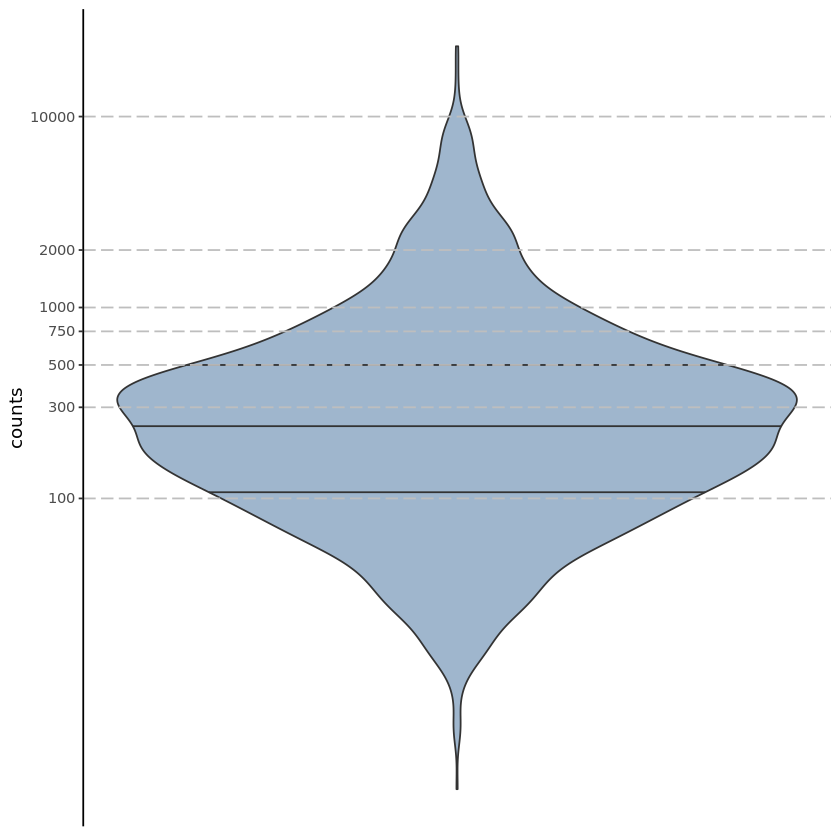

In [18]:
# Supp a

data.frame(counts=db_mat@cell_metadata[rownames(db_mat@cell_metadata) %in% neutrophil_pics &
                                       rownames(db_mat@cell_metadata) %in% alive_pics, 'total_counts']) %>%
    ggplot(aes(x=1, y=counts)) +
    geom_violin(fill='slategray3', draw_quantiles = c(0.25, 0.5, 0.75)) +
    #geom_jitter(alpha=0.2, color='slategray') +
    scale_y_log10(breaks=ticks) +
    geom_hline(yintercept = ticks, linetype='longdash', color='gray') +
    #geom_label(data = data.frame(n=ticks), aes(y=n, label=n)) +
    theme(axis.title.x = element_blank(), axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x=element_blank())

ggsave("final_figs/supp4/umi_counts.png", dpi=1200)

In [19]:
neutrophil_pics = intersect(db_mat@cells[db_mat@cells %in% cd45_neutrophil_pics | 
                                         db_mat@cell_metadata$Cell_type == "EPCAM-LY6G"],
                            alive_pics)

In [20]:
length(neutrophil_pics)

[1] 3449

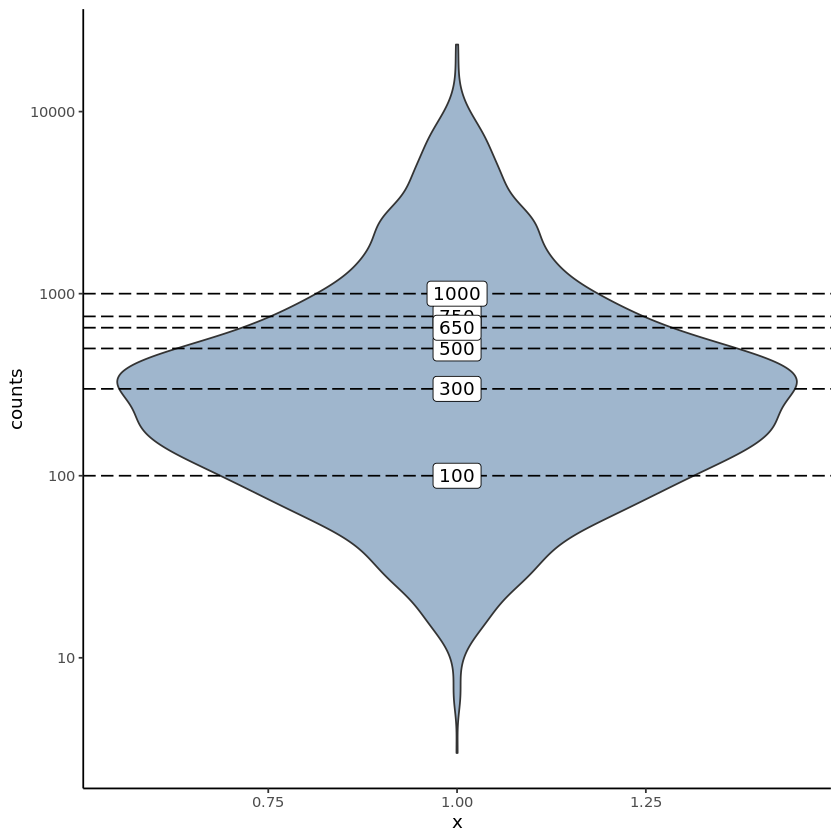

In [21]:
data.frame(counts=db_mat@cell_metadata[neutrophil_pics, 'total_counts']) %>%
    ggplot(aes(x=1, y=counts)) +
    geom_violin(fill='slategray3') +
    #geom_jitter(alpha=0.2, color='slategray') +
    scale_y_log10() +
    geom_hline(yintercept = c(100, 300, 500, 650, 750, 1000), linetype='longdash') +
    geom_label(data = data.frame(n=c(100, 300, 500, 750, 650, 1000)), aes(y=n, label=n))

In [22]:
mat2 = scm_sub_mat(db_mat, cells = neutrophil_pics)

In [23]:
mat2@cell_metadata$Cell_type %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       183       3266 

# PIC qc

In [24]:
nms = c(rownames(mat2@mat), rownames(mat2@ignore_gmat))

In [25]:
hb_genes = grep("^Hb[abdg]", nms, v=T)

In [26]:
cat(hb_genes, sep='", "')

Hba-a1", "Hba-a2", "Hba-ps4", "Hba-x", "Hbb-bh1", "Hbb-bh2", "Hbb-bs", "Hbb-bt", "Hbb-y

In [27]:
hb_gene_sums = colSums(mat2@mat[c("Hba-a1", "Hba-a2", "Hba-ps4", "Hba-x", "Hbb-bh1", "Hbb-bh2", "Hbb-bs", "Hbb-bt", "Hbb-y"),])
print(sum(hb_gene_sums > 0))
print(sum(hb_gene_sums > 1))
print(sum(hb_gene_sums > 2))
print(sum(hb_gene_sums > 3))
print(sum(hb_gene_sums > 4))
print(sum(hb_gene_sums > 5))
print(sum(hb_gene_sums > 6))
print(sum(hb_gene_sums > 7))
print(sum(hb_gene_sums > 8))
print(sum(hb_gene_sums > 9))
print(sum(hb_gene_sums > 10))

[1] 314
[1] 91
[1] 36
[1] 20
[1] 15
[1] 12
[1] 12
[1] 10
[1] 9
[1] 9
[1] 9


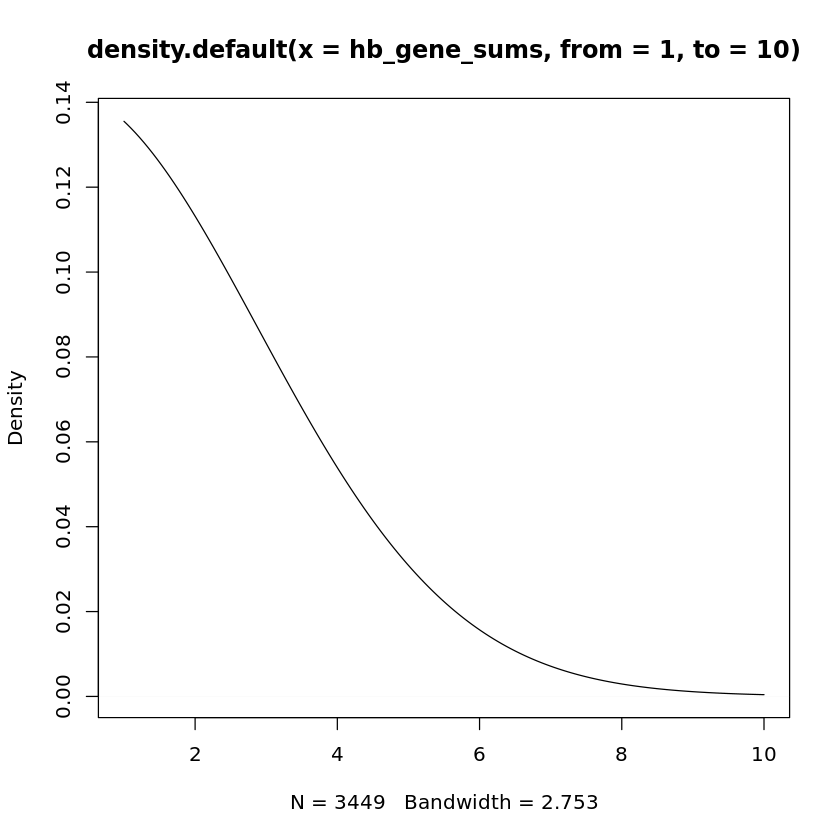

In [28]:
plot(density(hb_gene_sums, from=1, to = 10))

In [29]:
erythrocytes = names(which(hb_gene_sums > 3))

In [30]:
umis_per_cell =  colSums(mat2@mat)
mt_genes = unique(grep("^mt-", nms, v=T))
mt_percent = colSums(mat2@mat[mt_genes,]) / umis_per_cell
print(sum(mt_percent > 0.0))
print(sum(mt_percent > 0.1))
print(sum(mt_percent > 0.2))
print(sum(mt_percent > 0.3))
print(sum(mt_percent > 0.4))
print(sum(mt_percent > 0.5))
print(sum(mt_percent > 0.6))
print(sum(mt_percent > 0.7))
print(sum(mt_percent > 0.8))
print(sum(mt_percent > 0.9))

[1] 3432
[1] 2273
[1] 731
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0


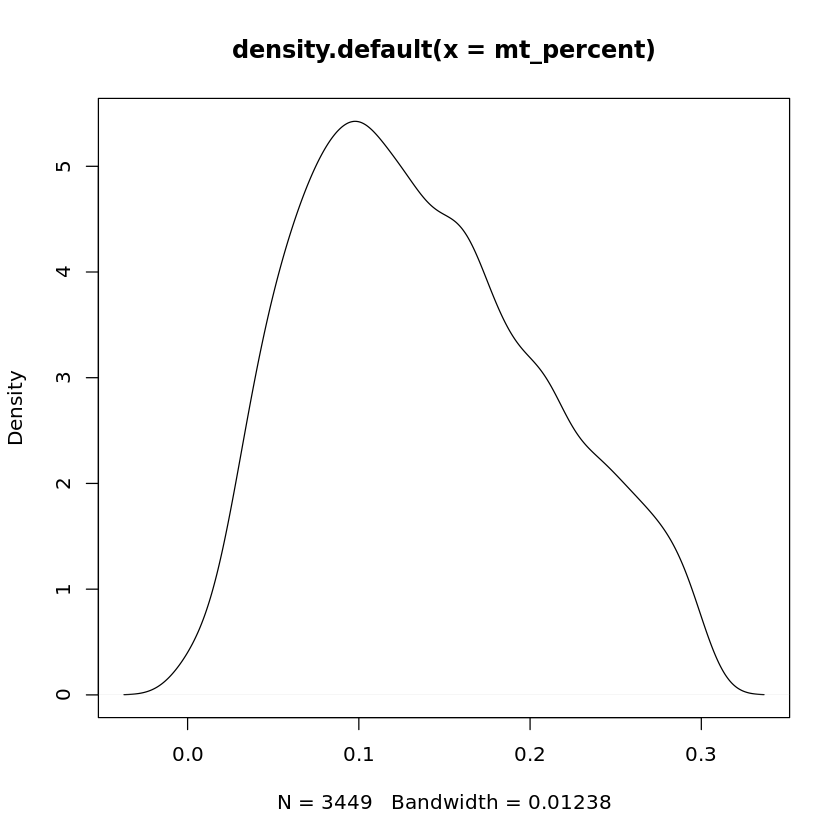

In [31]:
plot(density(mt_percent))

In [32]:
dead_cells = names(which(mt_percent > 0.3))

In [33]:
non_neutrophil_genes = c("C1qa", "C1qb", "C1qc", "Itgax", "Clec10a", "Mrc1", "H2-Ea",
                        "Cd3g", "Cd3e", "Cd3d", "Trbc2", "Trac", "Trdc", "Thy1", "Cd8b1", "Cd8a")

In [34]:
cat(non_neutrophil_genes, sep=', ')

C1qa, C1qb, C1qc, Itgax, Clec10a, Mrc1, H2-Ea, Cd3g, Cd3e, Cd3d, Trbc2, Trac, Trdc, Thy1, Cd8b1, Cd8a

In [35]:
non_neutrophil_genes = non_neutrophil_genes[non_neutrophil_genes %in% rownames(mat2@mat)]

In [36]:
non_neutrophil_gene_sums = colSums(mat2@mat[non_neutrophil_genes,])
print(sum(non_neutrophil_gene_sums > 0))
print(sum(non_neutrophil_gene_sums > 1))
print(sum(non_neutrophil_gene_sums > 2))
print(sum(non_neutrophil_gene_sums > 3))
print(sum(non_neutrophil_gene_sums > 4))
print(sum(non_neutrophil_gene_sums > 5))
print(sum(non_neutrophil_gene_sums > 6))
print(sum(non_neutrophil_gene_sums > 7))
print(sum(non_neutrophil_gene_sums > 8))
print(sum(non_neutrophil_gene_sums > 9))
print(sum(non_neutrophil_gene_sums > 10))

[1] 319
[1] 109
[1] 58
[1] 43
[1] 31
[1] 25
[1] 20
[1] 15
[1] 10
[1] 9
[1] 9


In [37]:
non_neutrophil_pics = names(which(non_neutrophil_gene_sums > 3))

In [38]:
mat2@mat[non_neutrophil_genes, non_neutrophil_pics] %>% as.matrix %>% t

C1qa C1qb C1qc Itgax Clec10a Mrc1 H2-Ea Cd3g Cd3e Cd3d Trbc2 Trac
AB522_E20  1    1    2   0     0       0    0     0    0    0    0     0   
AB522_G16  0    0    0   4     0       0    0     0    0    0    0     0   
AB523_M10 11   16    3   1     0       0    0     0    0    0    0     0   
AB538_G17  4   13    7   0     0       6    0     0    0    0    0     0   
AB538_F17  1    1    3   0     0       0    0     0    0    0    0     0   
AB524_C2   0    0    0   0     0       0    0     0    0    0    0     0   
AB524_O11  2    7    1   0     0       1    0     0    0    0    0     0   
AB524_A4   0    2    4   0     0       0    0     0    0    0    0     0   
AB365_H1   0    0    0   0     0       0    0     0    0    0    0     0   
AB365_D6   4    8    4   0     2       1    0     0    0    0    0     0   
AB365_L4   5   15   10   0     3       2    0     0    0    0    0     0   
AB365_C2   0    0    0   0     2       1    1     0    0    0    0     0   
AB365_M3   2    2    0   0     0       3    0     0    0    0    0     0   
AB365_I12  0    0    0   0     3       4    0     0    0    0    0     0   
AB365_D7   0    0    0   0     9       5    0     0    0    0    0     0   
AB365_H14  0    0    0   0     0       1    0     0    0    0    0     0   
AB365_K8   0    0    0   0     3       2    0     0    0    0    0     0   
AB365_E9   0    0    0   0     3       3    0     0    0    0    0     0   
AB365_M4   0    0    0   0     4       1    1     0    0    0    0     0   
AB365_M16  2    0    1   0     0       4    0     0    0    0    0     0   
AB365_K22  0    0    0   0     1       3    0     0    0    0    0     0   
AB378_L4   0    0    0   0     1       0    0     3    1    2    0     4   
AB378_I8   0    4    1   0     0       0    0     0    0    0    0     0   
AB378_E23  3    0    0   0     1       0    0     0    0    0    0     0   
AB378_J16  0    0    0   0     0       0    0     2    0    1    1     2   
AB378_M11  0    0    0   4     0       0    0     0    0    0    0     0   
AB378_A5   0    0    0   0     0       0    0     0    1    0    2     5   
AB378_I21  0    0    0   0     0       0    0     0    0    0    3     0   
AB378_E4   0    5    0   2     0       0    0     0    0    0    0     0   
AB378_C21  0    0    0   0     0       0    0     5    1    0    1     4   
AB395_M3   4   11    5   0     0       1    0     0    0    0    0     0   
AB395_G7   0    5    0   0     0       0    0     0    0    0    0     0   
AB319_E8   0    0    0   2     0       1    0     0    0    1    0     0   
AB340_E6   0    6    1   0     0       0    0     0    0    0    0     0   
AB340_M3   0    0    0   1     0       0    0     0    0    0    1     2   
AB340_O14  0    4    0   0     0       0    0     0    0    0    0     0   
AB337_N11  0    0    0   0     0       0    0     0    1    0    2     2   
AB338_A19  0    0    0   0     0       0    0     1    0    0    2     0   
AB338_H11  0    2    0   0     0       0    0     0    0    0    2     0   
AB338_F12  0    0    0   0     0       0    0     3    0    0    4     1   
AB338_E2   0    0    0   0     0       0    0     0    0    1    1     1   
AB338_A14  0    0    0   0     6       2    0     0    0    0    0     0   
AB338_C3   1    3    3   0     2       0    0     0    0    0    0     0   
          Trdc Thy1 Cd8b1 Cd8a
AB522_E20 0    0    0     0   
AB522_G16 0    0    0     0   
AB523_M10 0    0    0     0   
AB538_G17 0    0    0     0   
AB538_F17 0    0    0     0   
AB524_C2  0    4    0     0   
AB524_O11 0    0    0     0   
AB524_A4  0    0    0     0   
AB365_H1  0    4    0     0   
AB365_D6  0    0    0     0   
AB365_L4  0    0    0     0   
AB365_C2  0    0    0     0   
AB365_M3  0    0    0     0   
AB365_I12 0    0    0     0   
AB365_D7  0    0    0     0   
AB365_H14 0    7    0     0   
AB365_K8  0    0    0     0   
AB365_E9  0    0    0     0   
AB365_M4  0    0    0     0   
AB365_M16 0    0    0     0   
AB365_K22 0    

In [ ]:
endo_genes = c('Pecam1', 'Cdh5', 'Col4a1', 'Col4a2', 'Cd36')

In [40]:
endo_gene_sums = colSums(mat2@mat[endo_genes,])
print(sum(endo_gene_sums > 0))
print(sum(endo_gene_sums > 1))
print(sum(endo_gene_sums > 2))
print(sum(endo_gene_sums > 3))
print(sum(endo_gene_sums > 4))
print(sum(endo_gene_sums > 5))
print(sum(endo_gene_sums > 6))
print(sum(endo_gene_sums > 7))
print(sum(endo_gene_sums > 8))
print(sum(endo_gene_sums > 9))
print(sum(endo_gene_sums > 10))

[1] 380
[1] 155
[1] 100
[1] 86
[1] 75
[1] 64
[1] 60
[1] 56
[1] 51
[1] 45
[1] 42


In [41]:
endo_pics = names(which(endo_gene_sums > 3))

In [42]:
mat2@mat[endo_genes, endo_pics] %>% as.matrix %>% t

Pecam1 Cdh5 Col4a1 Col4a2 Cd36
AB522_G21 19     15   67     40     13  
AB522_A12  2      5   30     17      0  
AB522_C16 14      8   67     35      0  
AB522_H19  6      1    9      6      0  
AB522_F4  12     14   43     24     12  
AB522_A24 11      8   65     34     12  
AB522_I12  4      2    5      0      8  
AB522_H7   1      1    9      3      0  
AB523_I23  2      0    9      5      0  
AB523_C2   1      4    0      2      1  
AB538_C3   0      0    4      2      0  
AB538_B2   0      0    4      4      0  
AB524_C2   0      0   33     14      0  
AB524_M9  12      4   20     17     13  
AB524_D2   2      1   40     23      0  
AB172_F17  4      2   16     10      4  
AB172_A2   7      2    8      3      4  
AB392_M6   2      2    6      0      0  
AB365_H18 17      5   16      6     18  
AB365_A3   3      1    1      2      3  
AB365_A2   5      0    4      2      9  
AB365_B10  1      3    4      1      9  
AB365_B1   0      2    5      2      3  
AB365_H1   2      0    2      5      2  
AB365_D23  0      1    0      0     11  
AB365_A12  0      2    2      1      7  
AB365_F17  0      0    2      1      3  
AB365_M23  0      1    2      0     23  
AB365_G16  1      1    0      3      2  
AB365_C15  4      0    4      2      6  
⋮         ⋮      ⋮    ⋮      ⋮      ⋮   
AB365_N21 0      0    1      0      4   
AB378_C1  0      0    4      1      0   
AB395_D2  2      1    7      3      0   
AB395_M12 0      0    3      7      3   
AB395_I23 0      0    1      4      0   
AB395_A24 1      1    1      0      1   
AB395_G21 0      2    1      0      3   
AB395_C11 1      6    5      8      6   
AB395_G17 3      4    1      1      6   
AB395_M8  1      1    4      1      0   
AB395_A11 1      2    0      2      4   
AB395_A9  2      6    4      2      8   
AB395_E14 3      1    1      0      1   
AB395_K3  2      0    4      1      6   
AB395_B24 1      1    1      0      4   
AB395_J13 3      0    0      5      1   
AB395_G5  1      0    1      1      5   
AB395_N10 5      0    5      3      0   
AB395_J14 0      0    0      1      3   
AB395_J5  1      0    1      0      2   
AB395_N3  2      1    3      1      4   
AB395_O15 0      0    4      0      1   
AB395_H6  2      0    0      2      1   
AB395_L24 0      1    2      1      1   
AB395_G18 0      1    0      1      2   
AB395_O10 5      0    0      0      0   
AB318_H17 1      0    1      3      0   
AB318_G3  0      0    5      3      1   
AB340_F7  1      1    2      0      1   
AB338_F6  2      1    6      2      0

In [43]:
small_cells = mat2@cells[mat2@cell_metadata$total_counts < 0]

In [44]:
bad_cells = endo_pics %>% union(non_neutrophil_pics) %>% union(dead_cells) %>% union(erythrocytes) %>% union(small_cells)

In [45]:
message("endothelial UMIs - ", length(endo_pics))
message("erythrocytes UMIs - ", length(erythrocytes))
message("other non-neutrophil UMIs - ", length(non_neutrophil_pics))
message("total - ", length(bad_cells))

endothelial UMIs - 86

erythrocytes UMIs - 20

other non-neutrophil UMIs - 43

total - 142



In [46]:
mat2@cell_metadata[bad_cells, 'Cell_type'] %>% table

.
EPCAM-CD45 EPCAM-LY6G 
         9        133 

In [47]:
mat2@cell_metadata[setdiff(mat2@cells, bad_cells), 'Cell_type'] %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       174       3133 

In [48]:
165 + 686

[1] 851

In [49]:
clean_mat = scm_sub_mat(db_mat, cells = setdiff(mat2@cells, bad_cells))

In [50]:
clean_mat

An object of class tgScMat, stat type umi.
3307 cells by 36946 genes. median cell content 252.

In [51]:
scdb_add_mat('neutrophil_clean_pics', clean_mat)

# PIC-seq preprocessing

In [46]:
bad_genes = union(read_lines('annotations/kinetics_filtered_genes.txt'), 
                  read_lines('annotations/neutrophil_filtered_genes.txt'))

In [8]:
# Rerun

message("Loading singlets dataset:")
sc_mat = scdb_mat("merged_neutrophil_epithelial_mat")
message("Loaded a UMI matrix of ", sc_mat@ncells, " cells and ", sc_mat@ngenes, " genes.")
#sin_2d = scdb_mc2d("kinetics_2dproj")
sin_cl = scdb_mc("merged_neutrophil_epithelial_mc"); sin_mat = scdb_mat("merged_neutrophil_epithelial_mat")
lfp = log2(sin_cl@mc_fp)
message("Loaded a metacell object of ", length(sin_cl@mc), " singlets. Total of ", length(table(sin_cl@mc)), " metacells.")

message("Loading PIC dataset:")
db_mat = scdb_mat("neutrophil_clean_pics")
message("Loaded ", db_mat@ncells, " PICs")


Loading singlets dataset:

Loaded a UMI matrix of 12523 cells and 36893 genes.

Loaded a metacell object of 12494 singlets. Total of 307 metacells.

Loading PIC dataset:

Loaded 3307 PICs



In [9]:
db_mat@cell_metadata$Cell_type %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       174       3133 

In [10]:
#rerun
sin_cl@color_key <- data.frame(group=unique(sin_cl@annots), color=unique(sin_cl@colors))

In [11]:
#rerun
color_scheme = sin_cl@color_key
color2name = as.vector(color_scheme$group); names(color2name) = color_scheme$color
name2color = as.vector(color_scheme$color); names(name2color) = color_scheme$group
sin_names = color2name[ sin_cl@colors[ sin_cl@mc]]; names(sin_names) = names(sin_cl@mc)

In [12]:
cat(paste(1:length(unique(sin_cl@annots)), unique(sin_cl@annots), sep=" - "), sep="\n")

1 - Ptgs2 high
2 - AP high
3 - TAN1
4 - TAN2
5 - TAN3
6 - Cystatin high
7 - Young Cystatin high
8 - Alveolar spp l
9 - Progenitor 1
10 - Alveolar
11 - Alveolar secretory
12 - Alveolar spp1 h
13 - Progenitor 2
14 - HS
15 - Basal
16 - MyoLum
17 - Myoepithelial


lymphoid_order = c(26, 27, 28, 29, 20, 22, 21, 19, 18, 30, 25)
myeloid_order = c(32, 33, 31, 35, 37, 34, 36, 17, 23, 24)
neutrophil_order = c(6, 5, 2, 1, 3, 4)
epithelial_order = c(8, 12, 9, 13, 16, 14, 15, 7, 11, 10)

In [13]:
neutrophil_order = c(7, 6, 2, 1, 3:5)
epithelial_order = c(8, 12, 9, 13, 16, 14, 15, 7, 11, 10) + 1

In [14]:
#rerun
order_index = c(neutrophil_order, epithelial_order)

In [15]:
#rerun
cell_order = unique(sin_cl@annots)[order_index]

In [16]:
unique(sin_cl@annots)[!unique(sin_cl@annots) %in% cell_order]

character(0)

In [17]:
cond_order = c("tumor", "normal")

In [18]:
age_order = c("10d", "3w", "6w", "8w", "10w", "12w")

In [19]:
group.colors = unique(sin_cl@colors)[order_index]
names(group.colors) = cell_order

In [20]:
sin_stats = sc_mat@cell_metadata[names(sin_cl@mc),]

In [21]:
cat(cell_order, sep = '", "')

Young Cystatin high", "Cystatin high", "AP high", "Ptgs2 high", "TAN1", "TAN2", "TAN3", "Progenitor 1", "Progenitor 2", "Alveolar", "HS", "Myoepithelial", "Basal", "MyoLum", "Alveolar spp l", "Alveolar spp1 h", "Alveolar secretory

In [22]:
#rerun
epithelial_pops = c("Progenitor 1", "Progenitor 2", "Alveolar", "HS", "Myoepithelial", "Basal", "MyoLum", "Alveolar spp l", 
                    "Alveolar spp1 h", "Alveolar secretory")
immune_pops = c("Young Cystatin high", "Cystatin high", "AP high", "Ptgs2 high", "TAN1", "TAN2", "TAN3")

epithelial_mc = which(color2name[ sin_cl@colors] %in% epithelial_pops)
immune_mc = which(color2name[ sin_cl@colors] %in% immune_pops)
bad_mc = setdiff(names(table(sin_cl@mc)), union(epithelial_mc, immune_mc))

epithelial_cells = names(sin_names)[ sin_names %in% epithelial_pops]
immune_cells = names(sin_names)[ sin_names %in% immune_pops]

message(length(immune_cells), " immune cells and ", length(epithelial_cells), " epithelial cells")

737 immune cells and 11757 epithelial cells



In [22]:
mcell_gset_from_mc_markers(gset_id="merged_neutrophil_epithelial_markers", mc_id="merged_neutrophil_epithelial_mc")

In [68]:
markers = names(scdb_gset('merged_neutrophil_epithelial_markers')@gene_set) # Set of features used for the Metacell clustering
bad_genes = union(grep("Gm[0-9].|Mir|-ps|Rpl|Rps|Jchain|Ftl1|Hsp|Rn18s-rs5|Actb|Tuba|Rik", sin_mat@genes, v=T),
                  union(read_lines('annotations/kinetics_filtered_genes.txt'), 
                        read_lines('annotations/neutrophil_filtered_genes.txt')))
markers = markers[!markers %in% bad_genes]

In [23]:
# Rerun
lr_features = read.table("annotations/neutrophil_lr_features.txt", h=F, stringsAsFactors = F)[[1]]
mle_features = read.table("annotations/neutrophil_mle_features.txt", h=F, stringsAsFactors = F)[[1]]

message("Chose ", length(lr_features), " features")
message("Chose ", length(mle_features), " features")

Chose 1058 features

Chose 581 features



# Simulated PICs - for size threshold

In [70]:
k = 10000
numis = sample(100:1000, k, replace=T)

res = simulate_doublets(mat_id = "merged_neutrophil_epithelial_mat", 
                        a_cells = epithelial_cells, 
                        b_cells = immune_cells, 
                        k = k, 
                        numis = numis)

sim_umis = res$sim_umis; sim_info = res$info
head(sim_info)


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


sim.1     sim.2     alpha.1    alpha.2  
Sim1 AB527_P17 AB266_L19 0.88609531 0.1139047
Sim2 AB400_A17 AB435_F6  0.68491722 0.3150828
Sim3 AB170_L7  AB396_N2  0.03386386 0.9661361
Sim4 AB415_I2  AB129_O17 0.45815842 0.5418416
Sim5 AB327_J6  AB435_E12 0.60933170 0.3906683
Sim6 AB322_O4  AB435_G17 0.84923282 0.1507672

In [71]:
sim_cells = names(which(colSums(sim_umis) == numis))
sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]
sim_alpha = sim_info$alpha.1; names(sim_alpha) = rownames(sim_info)


sim_mle_res = assign_pics_to_singlets(mc_id = "merged_neutrophil_epithelial_mc", 
                                      mat_id = "merged_neutrophil_epithelial_mat", 
                                      pic_umis = sim_umis, 
                                      a_cells = epithelial_cells, 
                                      b_cells = immune_cells, 
                                      alpha = sim_alpha,
                                      verbose=T, 
                                      bad_genes = bad_genes, 
                                      markers = mle_features, 
                                      reg = 1e-4)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



In [72]:
sim_mle_res$alpha = sim_alpha

In [73]:
sim_mle_res$sin_alpha = with(sim_mle_res, round(alpha))
sim_mle_res$sin_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, sim_alpha, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$diff = with(sim_mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [74]:
sim_mle_res$imm_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 1, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$imm_diff = with(sim_mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [75]:
sim_mle_res$epi_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 0, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$epi_diff = with(sim_mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [76]:
sim_mle_res$lower_diff = pmin(sim_mle_res$epi_diff, sim_mle_res$imm_diff)

In [77]:
scdb_add_mat("neutrophil_simpic_sizevar", sim_umis)

In [78]:
write.table(sim_info, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_sim_info_varsizes.txt")
write.table(sim_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_sim_mle_res_varsizes.txt")

In [79]:
#Rerun
sim_info = read.delim("annotations/neutrophil_sim_info_varsizes.txt", row.names = 1)
sim_mle_res = read.delim("annotations/neutrophil_sim_mle_res_varsizes.txt", row.names = 1)

100

150

200

250

300

350

400

450

500

550

600

650

700

750

800

850

900

950

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


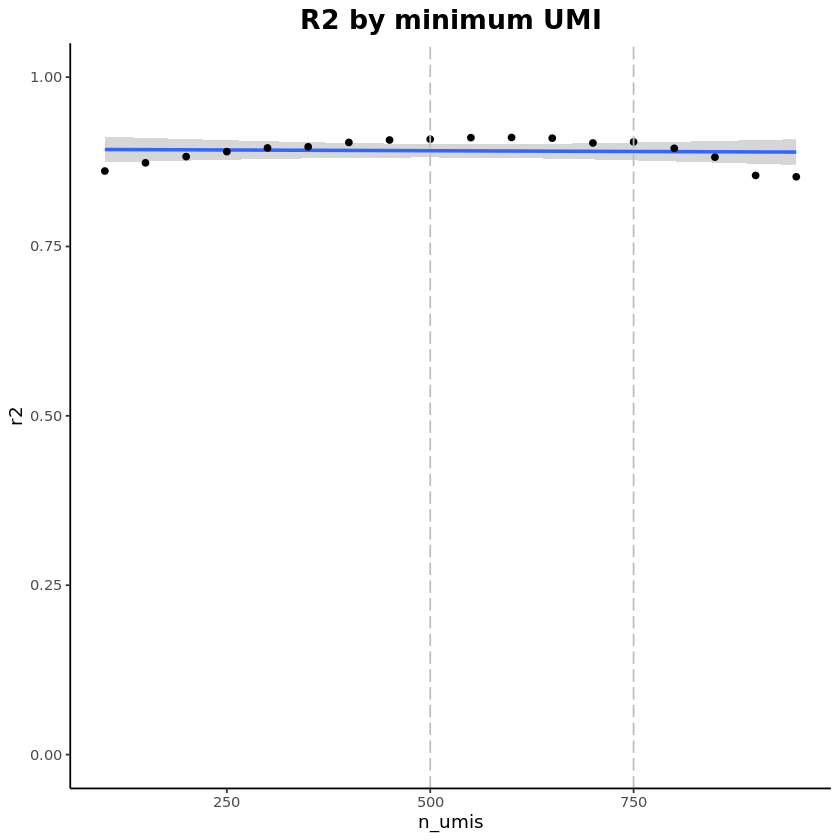

In [80]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 50), r2=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 50)){
    message(x)
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    alpha_fit = estimate_mixing(sim_umis = sim_umis[,rel_cells], 
                                alpha = sim_info[rel_cells,'alpha.1'], 
                                genes = lr_features, 
                                fname = "./temp.png",
                                sim_sizes[rel_cells],
                                normalize = T)
    alpha_tag = predict(alpha_fit, newx = t(sim_umis[lr_features,]), s = "lambda.min")[,1]
    i = which(alpha_fit$lambda == alpha_fit$lambda.min)
    r2 = round(1 - alpha_fit$cvm[i] / var(sim_info[rel_cells,'alpha.1']),4)    
    df[as.character(x),'r2'] = r2
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    #melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=r2)) +
    geom_smooth(method='lm', show.legend = F) +
    #scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,1)) +
    labs(title = 'R2 by minimum UMI') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))
ggsave("final_figs/supp4/r2_bysize.png", dpi=1200)

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


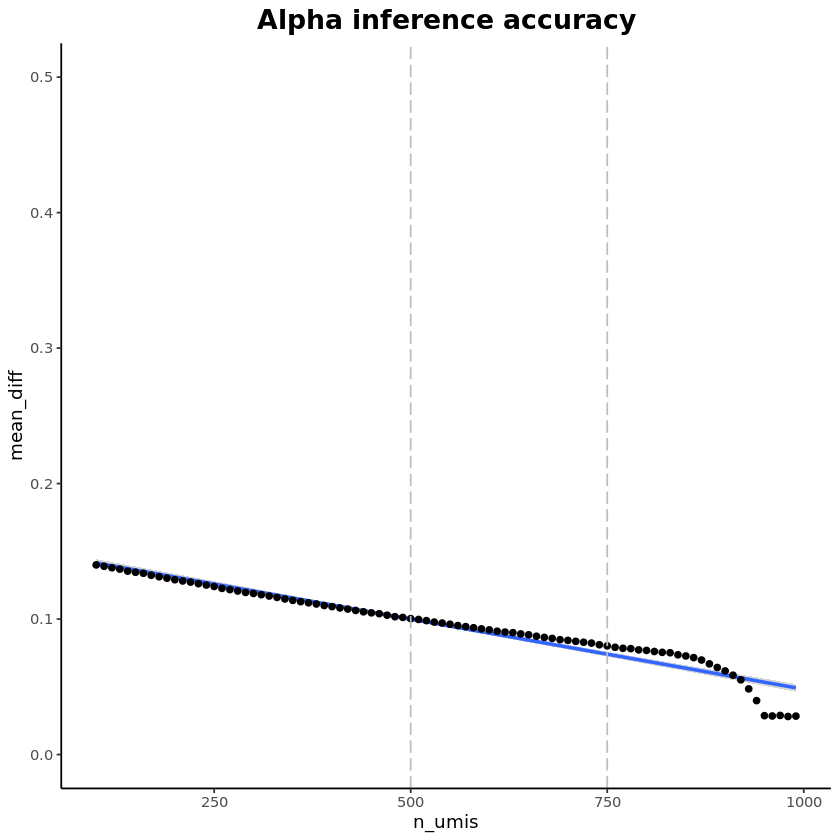

In [81]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 10), mean_diff=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 10)){
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    df[as.character(x),'mean_diff'] = mean(abs(sim_info[rel_cells, 'alpha.1'] - alpha_tag[rel_cells]))
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    #melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=mean_diff)) +
    geom_smooth(method='lm', show.legend = F) +
    #scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,0.5)) +
    labs(title = 'Alpha inference accuracy') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/alpha_inference_bysize.png", dpi=1200)

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


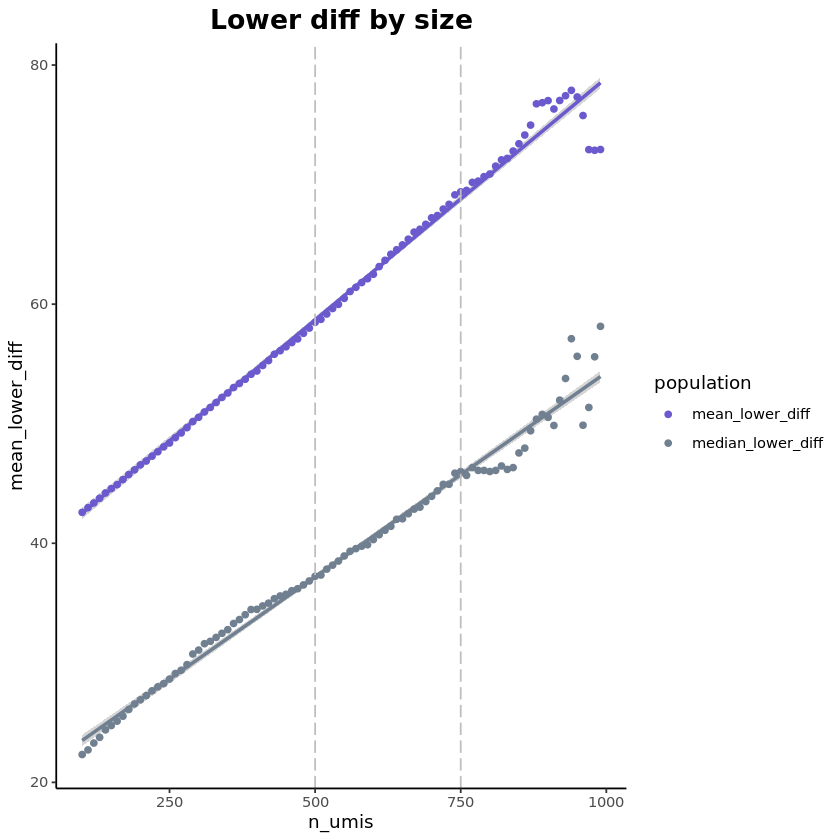

In [82]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 100), mean_lower_diff=NA, median_lower_diff=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 10)){
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    if (length(rel_cells) > 10){
        df[as.character(x),'mean_lower_diff'] = mean(sim_mle_res[rel_cells, 'lower_diff'])
        df[as.character(x),'median_lower_diff'] = median(sim_mle_res[rel_cells, 'lower_diff'])
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'mean_lower_diff') %>%
    ggplot(aes(x=n_umis, y=mean_lower_diff, color=population, group=population)) +
    geom_smooth(method='lm', show.legend = F) +
    scale_color_manual(values=c('slateblue', 'slategray')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    #scale_y_continuous(limits = c(0,1)) +
    labs(title = 'Lower diff by size') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/lowerdiff_bysize.png", dpi=1200)

In [83]:
plot_diff_boxplot = function(plot_df){
    geom_boxplot(data=plot_df, aes(x=min_size, y=lower_diff, color=min_size), width=50)
}

df = data.frame(lower_diff=sim_mle_res$lower_diff, size=colSums(sim_umis), min_size=0)

p = ggplot(df, aes(x=min_size, y=lower_diff))
breaks = seq(100, 999, 100)
for (i in breaks){
    plot_df = df[df$size >= i,] %>% mutate(min_size=i)
    p = p + plot_diff_boxplot(plot_df)
}
p = p + scale_color_gradient2(low = 'blue', mid = 'gray50', high = 'red', midpoint = 550) + scale_x_continuous(breaks=breaks)

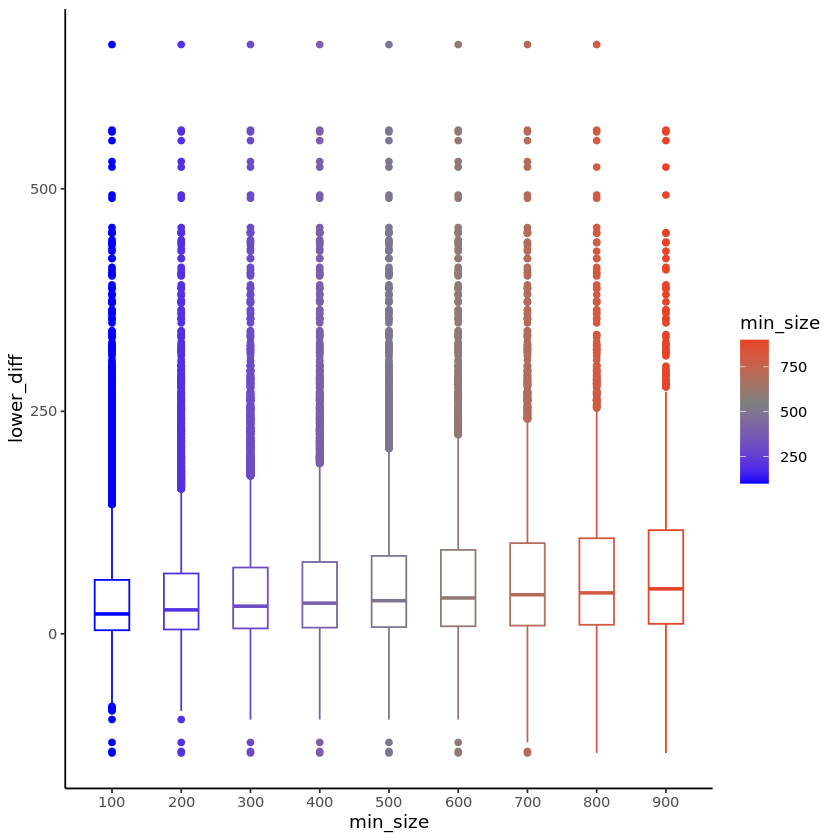

In [84]:
p

In [85]:
ggsave("final_figs/supp4/lowerdiff_bysize_boxplots.png", dpi=1200)

Saving 6.67 x 6.67 in image


`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


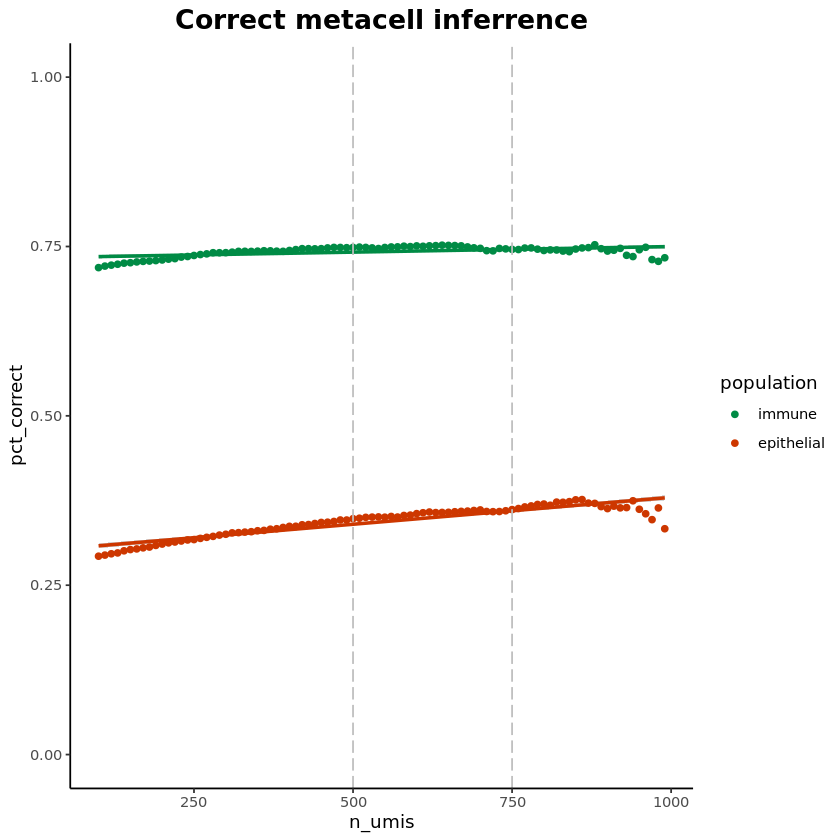

In [86]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 10), immune=NA, epithelial=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 10)){
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    if (length(rel_cells) > 10){
        df[as.character(x),'epithelial'] = sum(sin_cl@mc[sim_info[rel_cells, 'sim.1']] == sim_mle_res[rel_cells, 'a_mc']) / length(rel_cells)
        df[as.character(x),'immune'] = sum(sin_cl@mc[sim_info[rel_cells, 'sim.2']] == sim_mle_res[rel_cells, 'b_mc']) / length(rel_cells)
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=pct_correct, color=population, group=population)) +
    geom_smooth(method='lm', show.legend = F) +
    scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,1)) +
    labs(title = 'Correct metacell inferrence') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/mc_inference_bysize.png", dpi=1200)

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


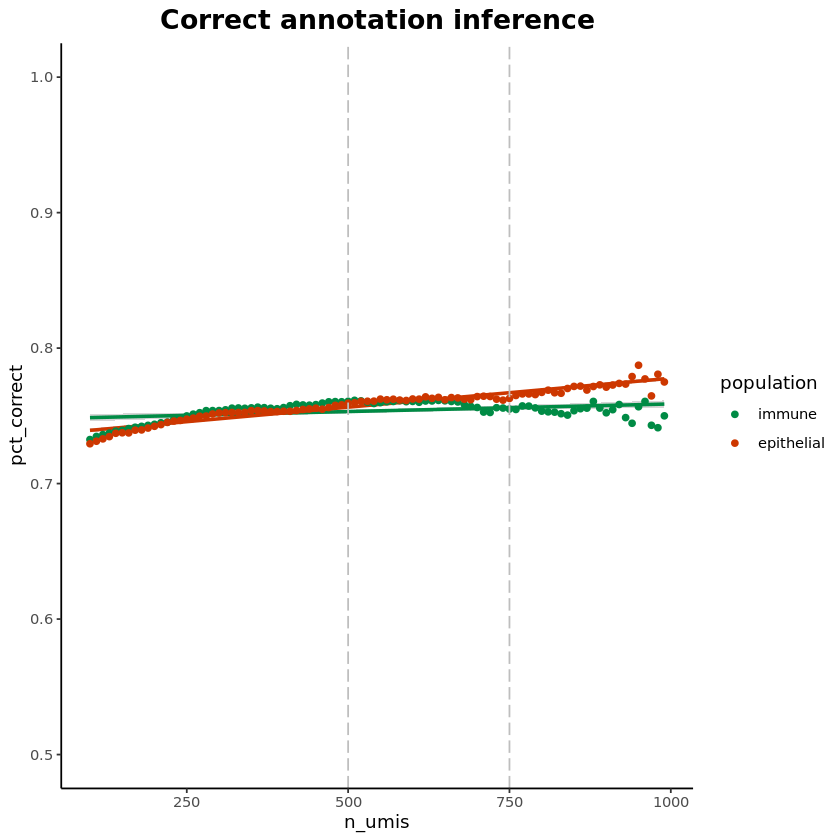

In [87]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 10), immune=NA, epithelial=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 10)){
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    if (length(rel_cells) > 10){
        df[as.character(x),'epithelial'] = sum(sin_cl@annots[sin_cl@mc[sim_info[rel_cells, 'sim.1']]] == sin_cl@annots[sim_mle_res[rel_cells, 'a_mc']]) / length(rel_cells)
        df[as.character(x),'immune'] = sum(sin_cl@annots[sin_cl@mc[sim_info[rel_cells, 'sim.2']]] == sin_cl@annots[sim_mle_res[rel_cells, 'b_mc']]) / length(rel_cells)
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=pct_correct, color=population, group=population)) +
    geom_smooth(method='lm', show.legend = F) +
    scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0.5,1)) +
    labs(title = 'Correct annotation inference') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/annot_inference_bysize.png", dpi=1200)

In [88]:
pic_sizes = colSums(db_mat@mat)

In [89]:
pic_sizes = pic_sizes[pic_sizes >= 100]

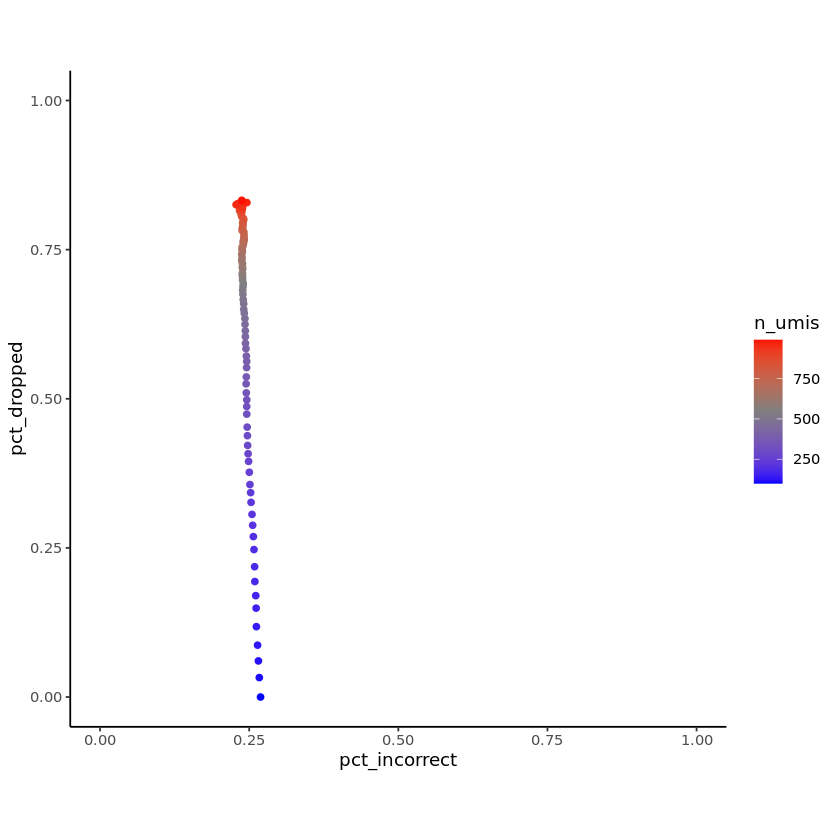

In [90]:
df %>% 
    mutate(pct_incorrect = 1-rowMeans(.)) %>%
    mutate(pct_dropped=sapply(as.numeric(rownames(.)), function(x){sum(pic_sizes < x) / length(pic_sizes)})) %>%
    rownames_to_column('n_umis') %>% 
    mutate(n_umis=as.numeric(n_umis)) %>%
ggplot(aes(y=pct_dropped, x=pct_incorrect, color=n_umis)) +
    #geom_smooth(method = 'lm', color='black', se=F) +
    geom_point() +
    scale_color_gradient2(low = 'blue', mid = 'gray50', high = 'red', midpoint = 550) +
    scale_x_continuous(limits = c(0, 1)) +
    scale_y_continuous(limits = c(0, 1)) +
    coord_fixed()

Warning message:
“attributes are not identical across measure variables; they will be dropped”


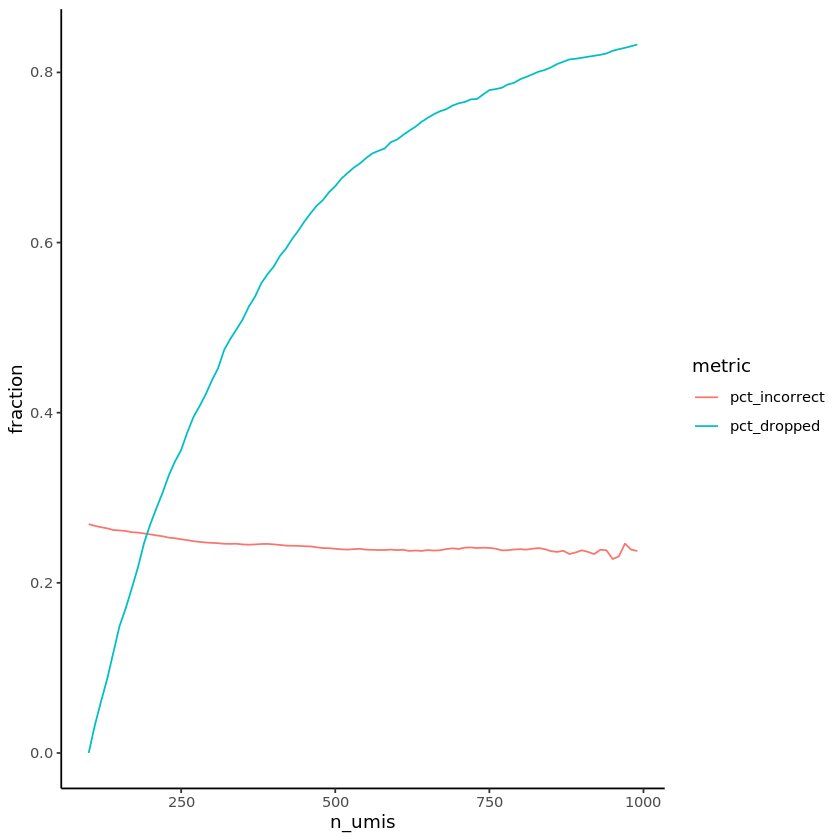

In [91]:
df %>% 
    mutate(pct_incorrect = 1-rowMeans(.)) %>%
    mutate(pct_dropped=sapply(as.numeric(rownames(.)), function(x){sum(pic_sizes < x) / length(pic_sizes)})) %>%
    rownames_to_column('n_umis') %>% 
    mutate(n_umis=as.numeric(n_umis)) %>%
    select(n_umis, pct_incorrect, pct_dropped) %>% 
    melt(id.vars = 'n_umis', variable.name = 'metric', value.name = 'fraction') %>%
ggplot(aes(x=n_umis,y=fraction, color=metric)) +
    #geom_smooth(method = 'lm', color='black', se=F) +
    geom_line()

# Simulated PICs - for QC

simulate_doublets = function(mat_id, a_cells, b_cells, k, numis = 1000, inflation=50, sim_genes=NA){
    cells = union(a_cells, b_cells)
    umis = read_large_umis(mat_id, cells = cells)
    if (is.na(sim_genes)){
        sim_genes = rownames(umis)
    }
    alpha = runif(k)
    numis_a = round(alpha * numis)
    numis_b = numis - numis_a
    sim_cells_a = sample(a_cells, size = k, replace = T)
    sim_cells_b = sample(b_cells, size = k, replace = T)
    a_umis = .downsamp_var(umis[sim_genes,sim_cells_a] * inflation, numis_a, replace=F)
    colnames(a_umis) = paste0("Sim", 1:k)
    b_umis = .downsamp_var(umis[sim_genes,sim_cells_b] * inflation, numis_b, replace=F)
    colnames(b_umis) = paste0("Sim", 1:k)
    simpic_umis = a_umis + b_umis
    list(sim_umis = simpic_umis, info = data.frame(sim.1=sim_cells_a, 
                                                   sim.2=sim_cells_b, 
                                                   alpha.1=alpha, 
                                                   alpha.2=1-alpha, 
                                                   row.names = paste0("Sim", 1:k)))
}

In [92]:
numis = 500; k = 10000
res = simulate_doublets(mat_id = "merged_neutrophil_epithelial_mat", 
                        a_cells = epithelial_cells, 
                        b_cells = immune_cells, 
                        k = k, 
                        numis = rep(numis, k))

sim_umis = res$sim_umis; sim_info = res$info
head(sim_info)


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


sim.1     sim.2     alpha.1   alpha.2  
Sim1 AB005_D16 AB431_B12 0.6163680 0.3836320
Sim2 AB161_H13 AB525_E19 0.6479556 0.3520444
Sim3 AB401_E9  AB540_M15 0.7719012 0.2280988
Sim4 AB139_O17 AB435_L22 0.2469691 0.7530309
Sim5 AB401_F5  AB147_G15 0.3587932 0.6412068
Sim6 AB401_K2  AB526_A16 0.6777374 0.3222626

In [93]:
sim_cells = names(which(colSums(sim_umis) == numis))
sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]
sim_alpha = sim_info$alpha.1; names(sim_alpha) = rownames(sim_info)


sim_mle_res = assign_pics_to_singlets(mc_id = "merged_neutrophil_epithelial_mc", 
                                      mat_id = "merged_neutrophil_epithelial_mat", 
                                      pic_umis = sim_umis, 
                                      a_cells = epithelial_cells, 
                                      b_cells = immune_cells, 
                                      alpha = sim_alpha,
                                      verbose=T, 
                                      bad_genes = bad_genes, 
                                      markers = mle_features, 
                                      reg = 1e-4)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



In [94]:
sim_mle_res$alpha = sim_alpha

In [95]:
sim_mle_res$sin_alpha = with(sim_mle_res, round(alpha))
sim_mle_res$sin_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, sim_alpha, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$diff = with(sim_mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [96]:
sim_mle_res$imm_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 1, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$imm_diff = with(sim_mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [97]:
sim_mle_res$epi_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 0, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$epi_diff = with(sim_mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [98]:
sim_mle_res$lower_diff = pmin(sim_mle_res$epi_diff, sim_mle_res$imm_diff)

In [99]:
write.table(sim_info, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_sim_info_final.txt")
write.table(sim_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_sim_mle_res_final.txt")

In [100]:
#Rerun
sim_info = read.delim("annotations/neutrophil_sim_info_final.txt", row.names = 1)
sim_mle_res = read.delim("annotations/neutrophil_sim_mle_res_final.txt", row.names = 1)

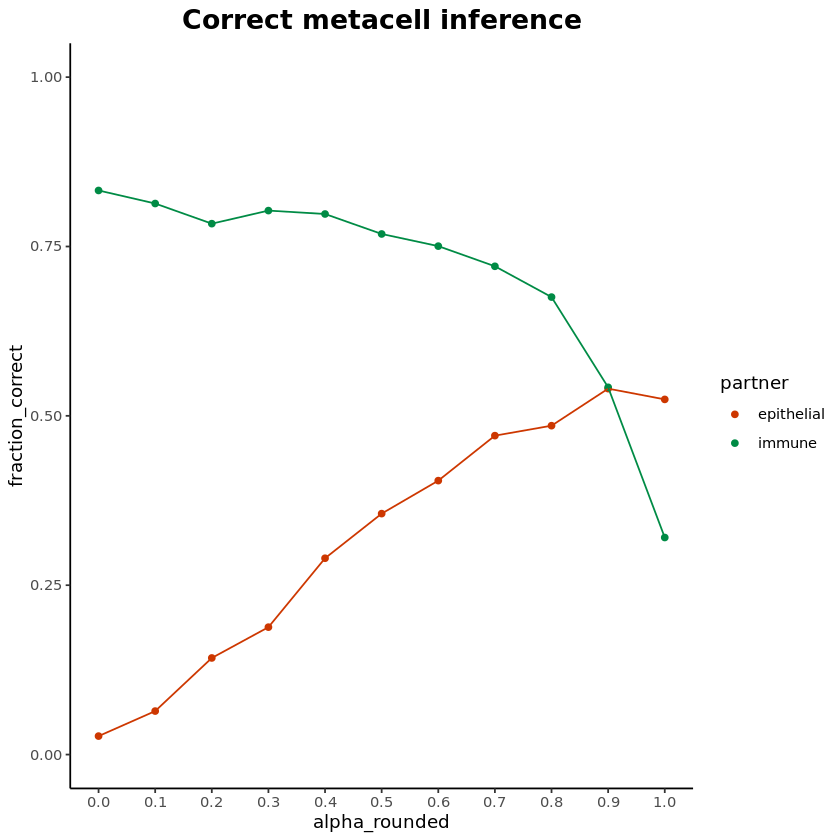

In [101]:
data.frame(alpha_rounded=round(sim_info$alpha.1, 1),
           correct_epithelial=sin_cl@mc[sim_info$sim.1] == sim_mle_res$a_mc,
           correct_immune=sin_cl@mc[sim_info$sim.2] == sim_mle_res$b_mc) %>%
    group_by(alpha_rounded) %>%
    summarise(epithelial = sum(correct_epithelial) / n(), immune = sum(correct_immune) / n()) %>%
    melt(id.vars = 'alpha_rounded', variable.name = 'partner', value.name = 'fraction_correct') %>%
    ggplot(aes(x=alpha_rounded, color=partner, y=fraction_correct, groups=partner)) +
    geom_point() +
    geom_line(show.legend = F) +
    scale_color_manual(values=c('orangered3', 'springgreen4')) +
    scale_y_continuous(limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0,1,0.1)) +
    labs(title = 'Correct metacell inference') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))


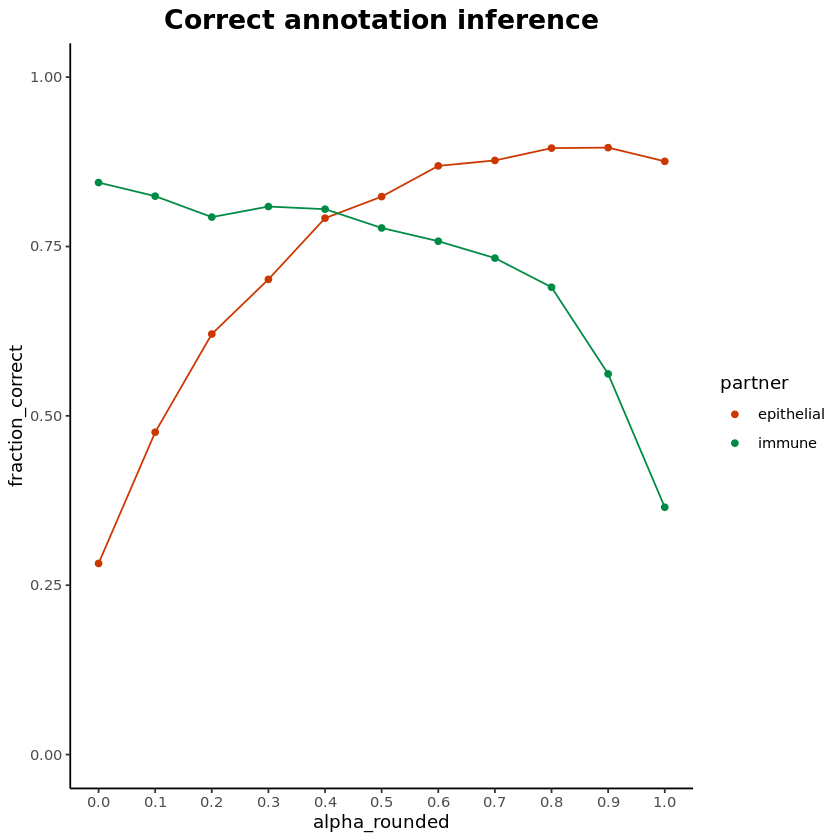

In [102]:
data.frame(alpha_rounded=round(sim_info$alpha.1, 1),
           correct_epithelial=sin_cl@annots[sin_cl@mc[sim_info$sim.1]] == sin_cl@annots[sim_mle_res$a_mc],
           correct_immune=sin_cl@annots[sin_cl@mc[sim_info$sim.2]] == sin_cl@annots[sim_mle_res$b_mc]) %>%
    group_by(alpha_rounded) %>%
    summarise(epithelial = sum(correct_epithelial) / n(), immune = sum(correct_immune) / n()) %>%
    melt(id.vars = 'alpha_rounded', variable.name = 'partner', value.name = 'fraction_correct') %>%
    ggplot(aes(x=alpha_rounded, color=partner, y=fraction_correct, groups=partner)) +
    geom_point() +
    geom_line(show.legend = F) +
    scale_color_manual(values=c('orangered3', 'springgreen4')) +
    scale_y_continuous(limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0,1,0.1)) +
    labs(title = 'Correct annotation inference') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))


In [103]:
epithelial_confu = table(sin_cl@mc[ as.vector( sim_info$sim.1)], sim_mle_res$a_mc)
epithelial_n = epithelial_confu / rowSums(epithelial_confu)
immune_confu = table(sin_cl@mc[ as.vector( sim_info$sim.2)], sim_mle_res$b_mc)
immune_n = immune_confu / rowSums(immune_confu)

zlim: 0<>1



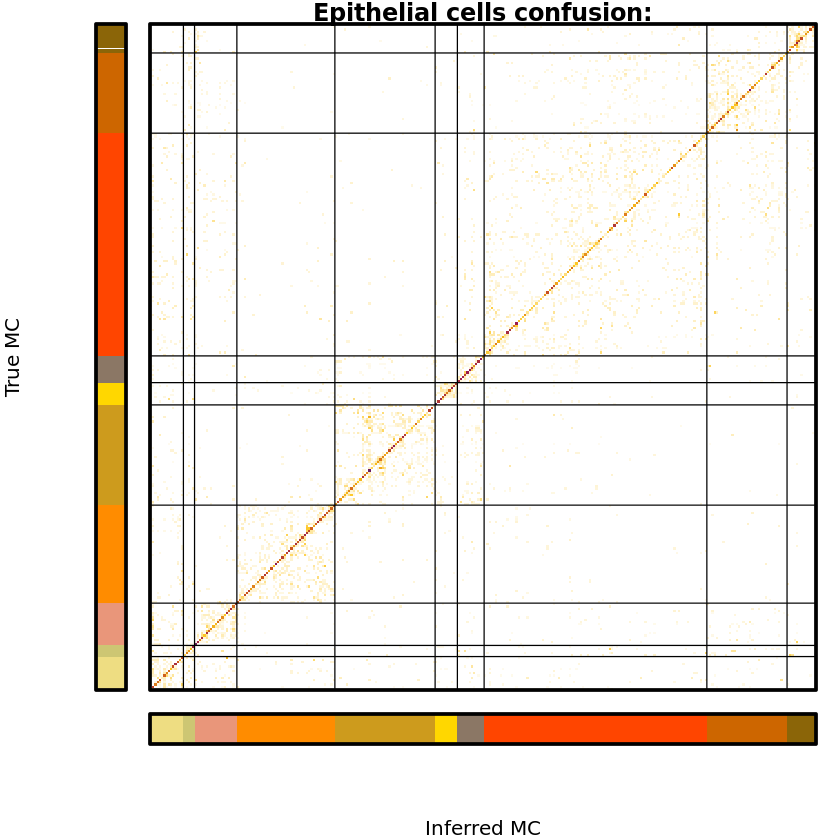

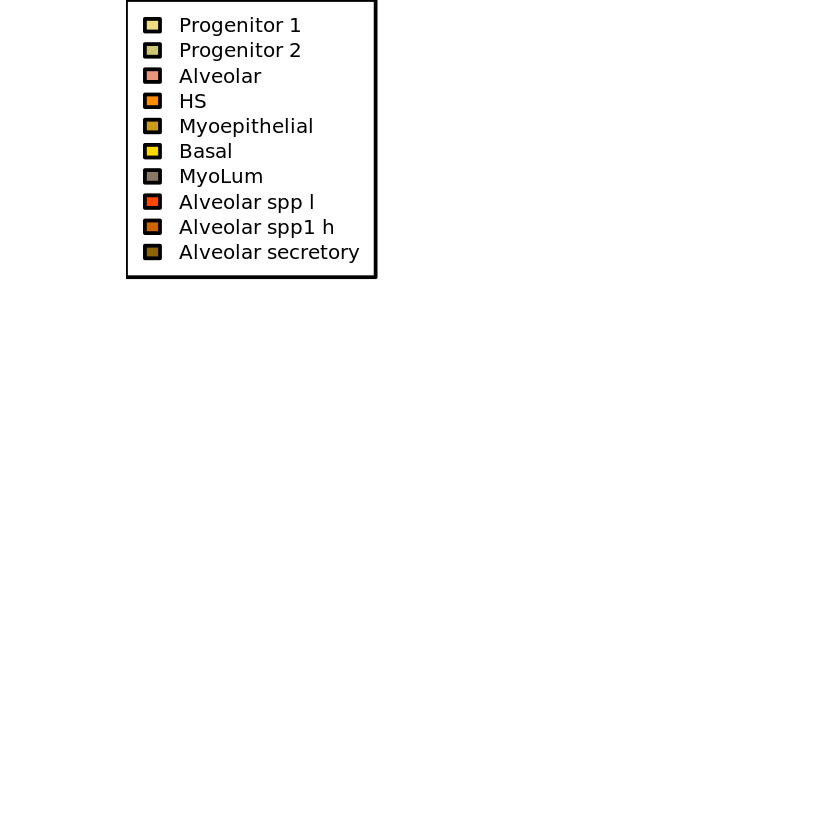

In [104]:
grad = colorRampPalette(c("white", "#FDC51D", "#CA531C", "#951851", "#36277A", "black"))(1000)
epithelial_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(epithelial_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(epithelial_n, zlim = c(0,1), col = grad, annotate = "none", hct = epithelial_cls, vct = epithelial_cls); box()
title("Epithelial cells confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], ylab = "True MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=epithelial_pops,
       fill=group.colors[epithelial_pops],
       xpd = TRUE
       )

In [105]:
png("final_figs/supp4/epithelial_confusion.png", width = 2000, height = 2000)
par(mar = rep(1,4), lwd = 3, fig = c(0.05,1,0.05,1))
image.2(epithelial_n, zlim = c(0,1), col = grad, annotate = "none", hct = epithelial_cls, vct = epithelial_cls); box()
#title("Epithelial cells confusion:")
par(fig = c(0.05,1,0,0.05), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.05,0.05,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], ylab = "True MC"); box()
dev.off()

zlim: 0<>1



png 
  2

zlim: 0<>1



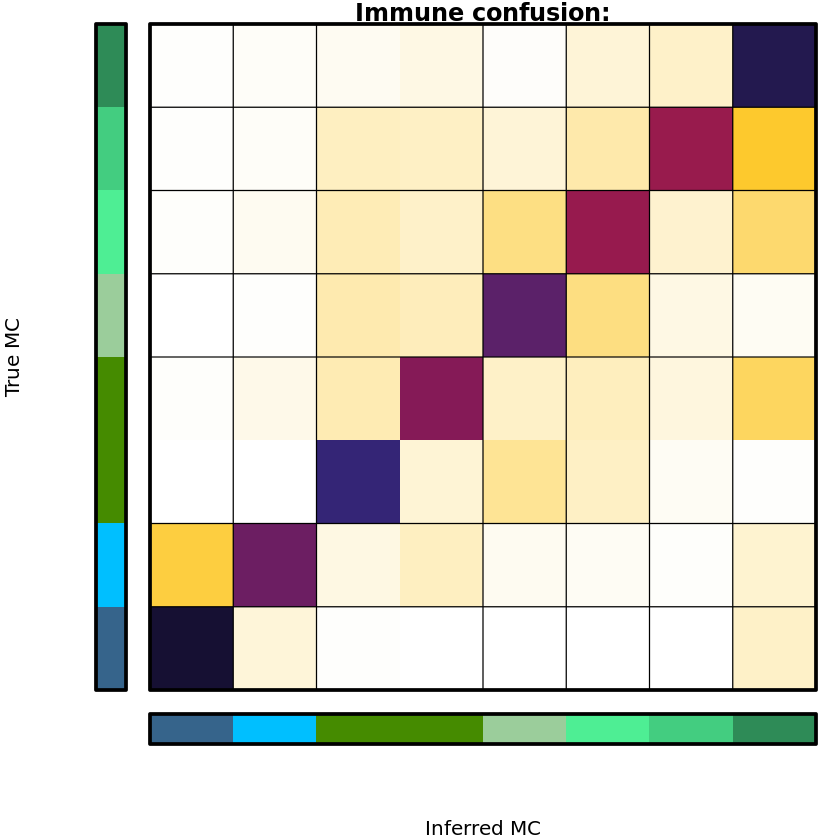

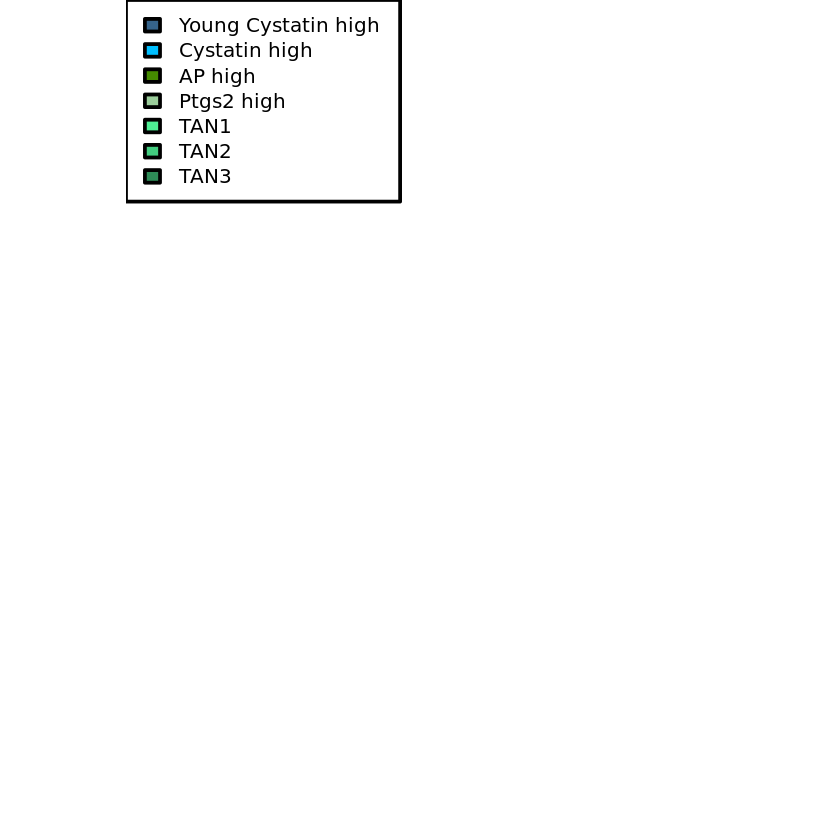

In [106]:
immune_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(immune_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(immune_n, zlim = c(0,1), col = grad, annotate = "none", hct = immune_cls,vct = immune_cls); box()
title("Immune confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new	= T)
image(matrix(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], xlab = "Inferred MC");box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], ylab = "True MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=immune_pops,
       fill=group.colors[immune_pops],
       xpd = TRUE
       )

In [107]:
png("final_figs/supp4/immune_confusion.png", width = 2000, height = 2000)
par(mar = rep(1,4), lwd = 3, fig = c(0.05,1,0.05,1))
image.2(immune_n, zlim = c(0,1), col = grad, annotate = "none", hct = immune_cls, vct = immune_cls); box()
#title("immune cells confusion:")
par(fig = c(0.05,1,0,0.05), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.05,0.05,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], ylab = "True MC"); box()
dev.off()

zlim: 0<>1



png 
  2

In [108]:
alpha_fit = estimate_mixing(sim_umis = sim_umis, 
                            alpha = sim_info$alpha.1, 
                            genes = lr_features, 
                            fname = "./temp.png",
                            500,
                            normalize = T)
alpha_tag = predict(alpha_fit, newx = t(sim_umis[lr_features,]), s = "lambda.min")[,1]

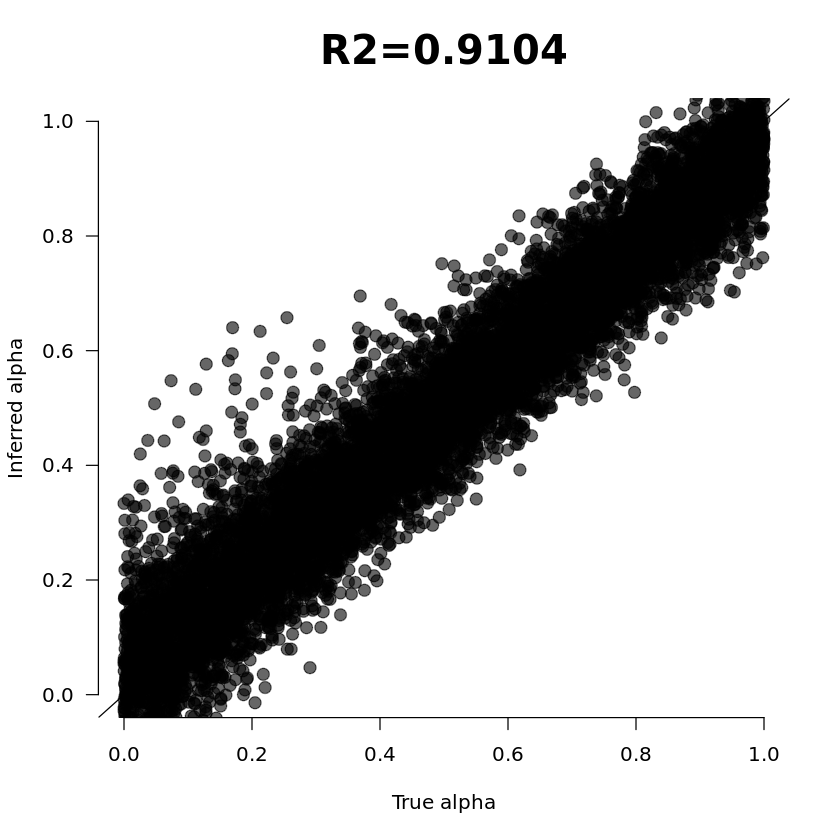

In [109]:
i = which(alpha_fit$lambda == alpha_fit$lambda.min)
plot(sim_info[, "alpha.1"], alpha_tag, pch = 20, col = rgb(0,0,0,0.6), xlim = c(0,1), ylim = c(0,1),
	cex=2, cex.main=2, main = paste0("R2=", round(1 - alpha_fit$cvm[i] / var(sim_info$alpha.1),4)), axes=F, xlab = "True alpha", ylab = "Inferred alpha")
abline(coef = c(0,1)); axis(1); axis(2,las=2)

In [110]:
png("final_figs/supp4/alpha_inference.png", width = 1000, height = 1000)
i = which(alpha_fit$lambda == alpha_fit$lambda.min)
plot(sim_info[, "alpha.1"], alpha_tag, pch = 20, col = rgb(0,0,0,0.6), xlim = c(0,1), ylim = c(0,1),
	cex=2, cex.main=2, main = paste0("R2=", round(1 - alpha_fit$cvm[i] / var(sim_info$alpha.1),4)), axes=F, xlab = "True alpha", ylab = "Inferred alpha")
abline(coef = c(0,1)); axis(1); axis(2,las=2)
dev.off()

png 
  2

# Singlet PIC-seq analysis

### Immune singlets 

In [111]:
numis=500
pic_umis = read_large_umis("merged_neutrophil_epithelial_mat", cells = names(sin_cl@mc[sin_cl@annots[sin_cl@mc] %in% immune_pops]))
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

imm_mle_res = run_pic_seq(mc_id = "merged_neutrophil_epithelial_mc", 
                      mat_id = "merged_neutrophil_epithelial_mat", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.png", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(imm_mle_res)

imm_mle_res$sin_alpha = with(imm_mle_res, round(alpha))
imm_mle_res$sin_ll = with(imm_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$diff = with(imm_mle_res, ll - sin_ll)

imm_mle_res$epi_alpha = 1
imm_mle_res$epi_ll = with(imm_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, epi_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$epi_diff = with(imm_mle_res, ll - epi_ll)

imm_mle_res$imm_alpha = 0
imm_mle_res$imm_ll = with(imm_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, imm_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$imm_diff = with(imm_mle_res, ll - imm_ll)

write.table(imm_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_imm_mle_res.txt")

Retained 132 PIC with >500 UMI

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



a_mc b_mc ll        alpha      
AB525_K11 182  1    -138.2554 0.069977418
AB525_D15  46  6    -162.4392 0.306952092
AB540_E11 200  8    -168.3708 0.007969298
AB543_A9   46  5    -145.6533 0.075362682
AB526_C2  193  6    -147.8730 0.039304494
AB526_C6  200  6    -213.2806 0.042147039

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


### Epithelial singlets 

In [112]:
numis=500
pic_umis = read_large_umis("merged_neutrophil_epithelial_mat", cells = names(sin_cl@mc[sin_cl@annots[sin_cl@mc] %in% epithelial_pops]))
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

epi_mle_res = run_pic_seq(mc_id = "merged_neutrophil_epithelial_mc", 
                      mat_id = "merged_neutrophil_epithelial_mat", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.png", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(epi_mle_res)

epi_mle_res$sin_alpha = with(epi_mle_res, round(alpha))
epi_mle_res$sin_ll = with(epi_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$diff = with(epi_mle_res, ll - sin_ll)

epi_mle_res$epi_alpha = 1
epi_mle_res$epi_ll = with(epi_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, epi_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$epi_diff = with(epi_mle_res, ll - epi_ll)

epi_mle_res$imm_alpha = 0
epi_mle_res$imm_ll = with(epi_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, imm_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$imm_diff = with(epi_mle_res, ll - imm_ll)

write.table(epi_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_epi_mle_res.txt")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Retained 10627 PIC with >500 UMI

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



a_mc b_mc ll        alpha    
AB529_N3  117  2    -141.0161 0.9624984
AB541_G24 145  2    -134.2062 0.9896735
AB541_P4   60  2    -134.3257 0.9396438
AB541_H8  157  2    -153.1582 0.8394734
AB541_L10  87  2    -178.7787 0.8631940
AB541_N2  252  2    -131.9127 0.9143011

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


# Real PIC-seq analysis

In [113]:
numis=500
pic_umis = read_large_umis("neutrophil_clean_pics", cells = db_mat@cells)
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

Retained 860 PIC with >500 UMI



In [114]:
mle_res = run_pic_seq(mc_id = "merged_neutrophil_epithelial_mc", 
                      mat_id = "merged_neutrophil_epithelial_mat", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.png", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(mle_res)

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



a_mc b_mc ll        alpha    
AB542_M7   87  2    -130.7922 0.7903814
AB542_K8   90  3    -151.2434 0.8940668
AB542_A13  94  1    -210.0961 0.6128149
AB542_P7  121  2    -135.2254 0.7563451
AB542_A4   89  2    -161.6024 0.7580213
AB539_N11  21  5    -180.6489 0.9371303

In [115]:
old_mle_res = read.delim("annotations/neutrophil_mle_res.txt", stringsAsFactors = F, row.names=1)

In [116]:
length(intersect(rownames(old_mle_res), rownames(mle_res)))

[1] 816

In [117]:
nrow(mle_res)

[1] 834

In [118]:
nrow(old_mle_res)

[1] 825

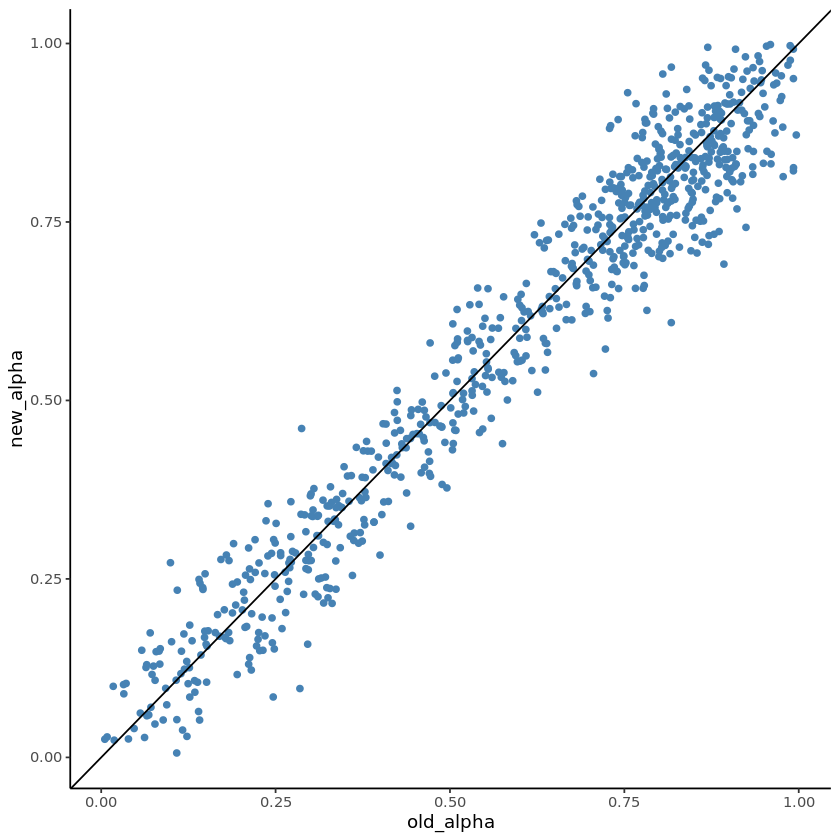

In [119]:
data.frame(new_alpha=mle_res[intersect(rownames(old_mle_res), rownames(mle_res)),'alpha'], 
           old_alpha=old_mle_res[intersect(rownames(old_mle_res), rownames(mle_res)),'alpha']) %>%
    ggplot(aes(x=old_alpha,y=new_alpha)) +
    geom_point(color='steelblue') +
    geom_abline(slope = 1, intercept = 0)

In [120]:
old_mle_res = old_mle_res[rownames(mle_res),]

In [121]:
epithelial_confu = table(mle_res$a_mc, old_mle_res$a_mc)
epithelial_n = epithelial_confu / rowSums(epithelial_confu)
immune_confu = table(mle_res$b_mc, old_mle_res$b_mc)
immune_n = immune_confu / rowSums(immune_confu)

zlim: 0<>1



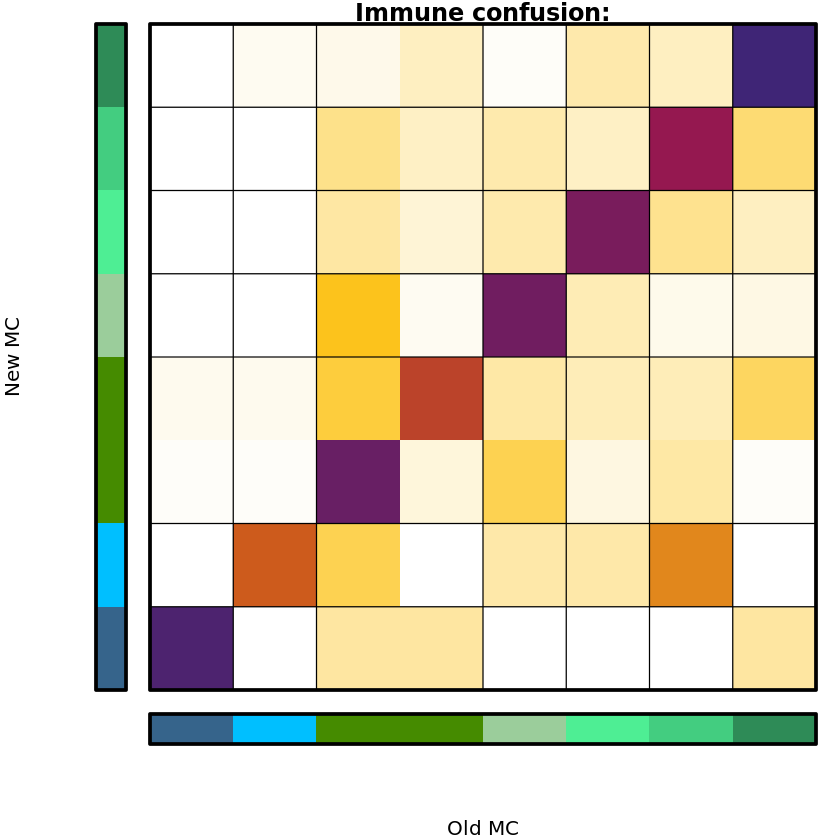

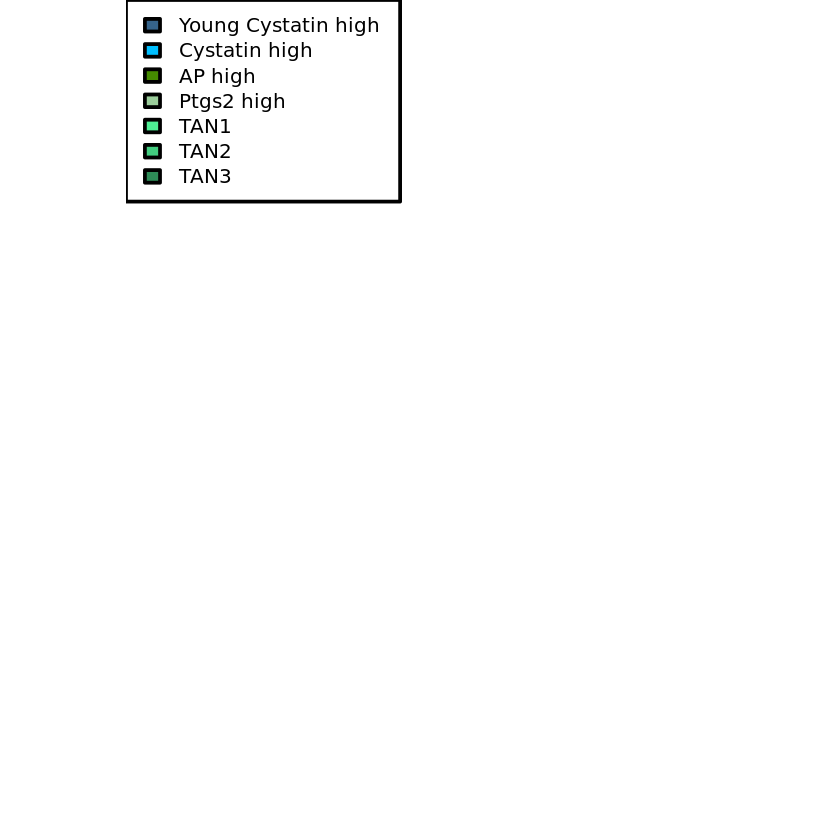

In [122]:
immune_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(immune_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(immune_n, zlim = c(0,1), col = grad, annotate = "none", hct = immune_cls,vct = immune_cls); box()
title("Immune confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new	= T)
image(matrix(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], xlab = "Old MC");box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], ylab = "New MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=immune_pops,
       fill=group.colors[immune_pops],
       xpd = TRUE
       )

In [123]:
epithelial_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(epithelial_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(epithelial_n, zlim = c(0,1), col = grad, annotate = "none", hct = epithelial_cls,vct = epithelial_cls); box()
title("epithelial confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new	= T)
image(matrix(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], xlab = "Old MC");box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], ylab = "New MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=epithelial_pops,
       fill=group.colors[epithelial_pops],
       xpd = TRUE
       )

ERROR: Error in `[.default`(X, , order(vct)): subscript out of bounds


ERROR: Error in box(): plot.new has not been called yet


In [124]:
mle_res$sin_alpha = with(mle_res, round(alpha))
mle_res$sin_ll = with(mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
mle_res$diff = with(mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [125]:
mle_res$imm_ll = with(mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, 1, reg = 1e-4, 
                                              markers = mle_features))
mle_res$imm_diff = with(mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [126]:
mle_res$epi_ll = with(mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, 0, reg = 1e-4, 
                                              markers = mle_features))
mle_res$epi_diff = with(mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [127]:
mle_res$lower_diff = pmin(mle_res$epi_diff, mle_res$imm_diff)

In [128]:
write.table(mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_mle_res.txt")

In [26]:
#rerun
mle_res = read.delim("annotations/neutrophil_mle_res.txt", stringsAsFactors = F, row.names=1)
epi_mle_res = read.delim("annotations/neutrophil_epi_mle_res.txt", stringsAsFactors = F, row.names=1)
imm_mle_res = read.delim("annotations/neutrophil_imm_mle_res.txt", stringsAsFactors = F, row.names=1)
head(mle_res)

a_mc b_mc ll        alpha     sin_alpha sin_ll    diff      imm_ll   
AB542_M7   87  2    -130.7922 0.7903814 1         -151.1895 20.397286 -151.1895
AB542_K8   90  3    -151.2434 0.8940668 1         -189.0375 37.794062 -189.0375
AB542_A13  94  1    -210.0961 0.6128149 1         -275.8295 65.733364 -275.8295
AB542_P7  121  2    -135.2254 0.7563451 1         -172.2585 37.033086 -172.2585
AB542_A4   89  2    -161.6024 0.7580213 1         -208.8252 47.222733 -208.8252
AB539_N11  21  5    -180.6489 0.9371303 1         -188.2646  7.615641 -188.2646
          imm_diff  epi_ll    epi_diff lower_diff
AB542_M7  20.397286 -278.2278 147.4356 20.397286 
AB542_K8  37.794062 -472.9461 321.7027 37.794062 
AB542_A13 65.733364 -289.4468  79.3507 65.733364 
AB542_P7  37.033086 -262.5931 127.3677 37.033086 
AB542_A4  47.222733 -380.0872 218.4847 47.222733 
AB539_N11  7.615641 -432.6137 251.9648  7.615641

In [27]:
mle_res$lower_diff = pmin(mle_res$imm_dif, mle_res$epi_diff)
epi_mle_res$lower_diff = pmin(epi_mle_res$imm_dif, epi_mle_res$epi_diff)
imm_mle_res$lower_diff = pmin(imm_mle_res$imm_dif, imm_mle_res$epi_diff)

In [28]:
#Rerun
sim_info = read.delim("annotations/neutrophil_sim_info_final.txt", row.names = 1)
sim_mle_res = read.delim("annotations/neutrophil_sim_mle_res_final.txt", row.names = 1)

In [29]:
min_thresh = ceiling(min(c(epi_mle_res$lower_diff, imm_mle_res$lower_diff, sim_mle_res$lower_diff, mle_res$lower_diff)))

In [30]:
max_thresh = floor(max(c(epi_mle_res$lower_diff, imm_mle_res$lower_diff, sim_mle_res$lower_diff, mle_res$lower_diff)))

In [31]:
thresh_df = data.frame(thresh=seq(min_thresh, max_thresh, 0.01),
                       singlet_pctg=sapply(seq(min_thresh, max_thresh, 0.01), function(thresh){
    mean(sum(epi_mle_res$lower_diff < thresh) / nrow(epi_mle_res), sum(imm_mle_res$lower_diff < thresh) / nrow(imm_mle_res))
                           }),
                       simpic_pctg=sapply(seq(min_thresh, max_thresh, 0.01), function(thresh){
        (sum(sim_mle_res$lower_diff < thresh) / nrow(sim_mle_res))
                           })
                      )

In [32]:
max_df = thresh_df[thresh_df$singlet_pctg - thresh_df$simpic_pctg == max(thresh_df$singlet_pctg - thresh_df$simpic_pctg),][1,]
singlet_pctg = mean(max_df$singlet_pctg)

In [33]:
max_df

thresh singlet_pctg simpic_pctg
8253 0.52   0.9719783    0.1641

In [34]:
thresh = max_df$thresh

In [35]:
point_on_line = (max_df$singlet_pctg + max_df$simpic_pctg) / 2

In [188]:
#thresh = thresh_df[abs(thresh_df$singlet_pctg - 0.75) == min(abs(thresh_df$singlet_pctg - 0.75)),'thresh']

In [189]:
#point_on_line = (thresh_df[thresh_df$thresh == thresh,]$singlet_pctg + thresh_df[thresh_df$thresh == thresh,]$simpic_pctg) / 2

Saving 6.67 x 6.67 in image


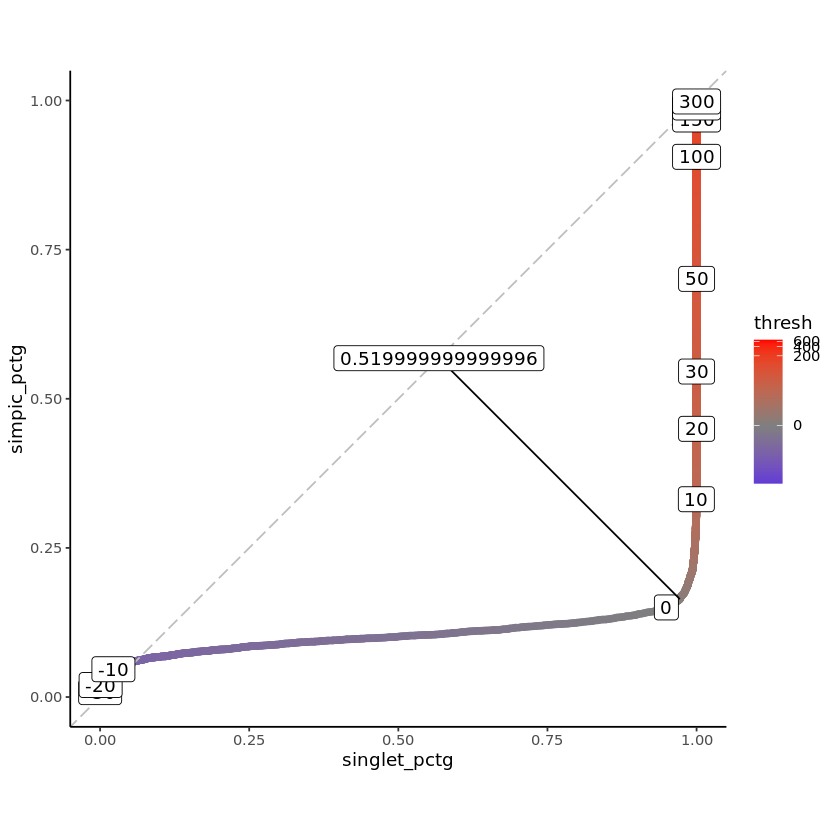

In [190]:
ggplot(thresh_df, aes(x=singlet_pctg, y=simpic_pctg, color=thresh)) +
    geom_point() +
    geom_abline(slope = 1, intercept = 0, color='gray', linetype='longdash') +
    scale_color_gradient2(low = 'blue', mid = 'gray50', high = 'red', midpoint = 0, trans='pseudo_log') +
    geom_label(data=thresh_df[thresh_df$thresh %in% c(seq(-30,30,10), seq(50,200,50), 300),],#[round(thresh_df$thresh, digits = -1) == thresh_df$thresh ,], 
               aes(label=thresh), color='black') +
    scale_y_continuous(limits = c(0,1)) +
    geom_segment(data=data.frame(x=point_on_line, y=point_on_line, 
                                 x2=thresh_df[thresh_df$thresh == thresh,]$singlet_pctg, 
                                 y2=thresh_df[thresh_df$thresh == thresh,]$simpic_pctg), 
                 aes(x=x, y=y, xend=x2, yend=y2), color='black') +
    geom_label(data=data.frame(x=point_on_line, y=point_on_line, label=thresh), 
               aes(x=x, y=y, label=label), color='black') +
    coord_fixed()
ggsave("final_figs/supp4/exclusion_curve.png", dpi=1200)

Saving 6.67 x 6.67 in image


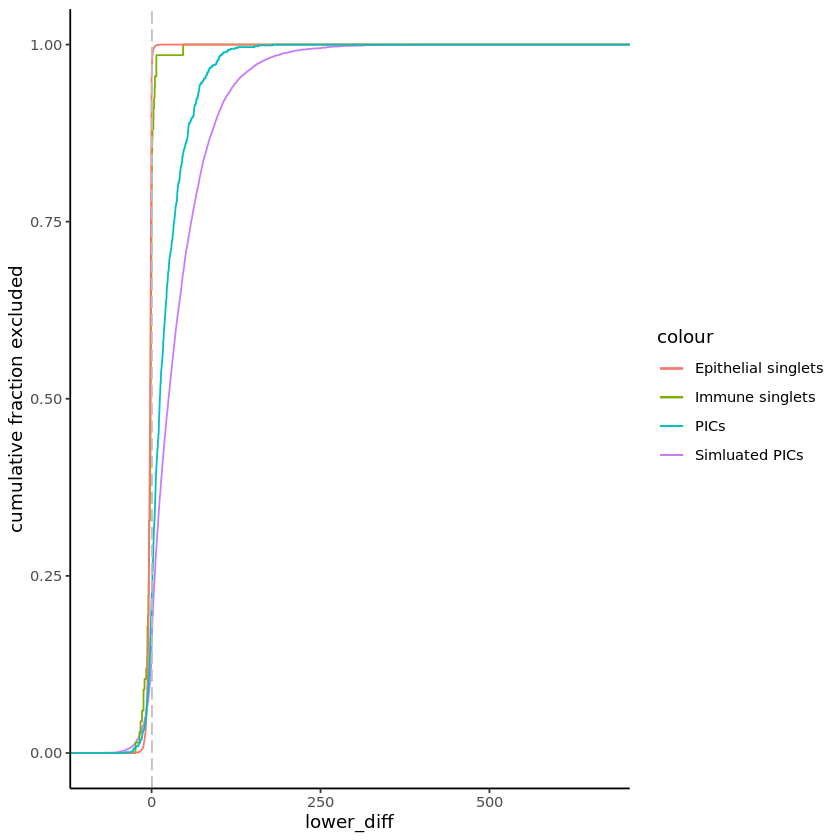

In [191]:
ggplot(sim_mle_res, aes(lower_diff)) + 
    stat_ecdf(geom = "step", aes(color='Simluated PICs')) +
    stat_ecdf(data = imm_mle_res, geom = "step", aes(color='Immune singlets')) +
    stat_ecdf(data = epi_mle_res, geom = "step", aes(color='Epithelial singlets')) +
    stat_ecdf(data = mle_res, geom = "step", aes(color='PICs')) +
    #scale_x_continuous(limits = c(-50, 200)) +
    geom_vline(xintercept = thresh, color='gray', linetype='longdash') +
    labs(y="cumulative fraction excluded")
ggsave("final_figs/supp4/exclusion_by_thresh.png", dpi=1200)

In [36]:
#thresh = 0.5
message("Epithelial singlets - ", sum(epi_mle_res$lower_diff < thresh) / nrow(epi_mle_res))
message("Immune singlets - ", sum(imm_mle_res$lower_diff < thresh) / nrow(imm_mle_res))
message("Simulated PICs - ", sum(sim_mle_res$lower_diff < thresh) / nrow(sim_mle_res))
message("Experimental PICs - ", sum(mle_res$lower_diff < thresh) / nrow(mle_res))

Epithelial singlets - 0.971978305785124

Immune singlets - 0.82089552238806

Simulated PICs - 0.1641

Experimental PICs - 0.229016786570743



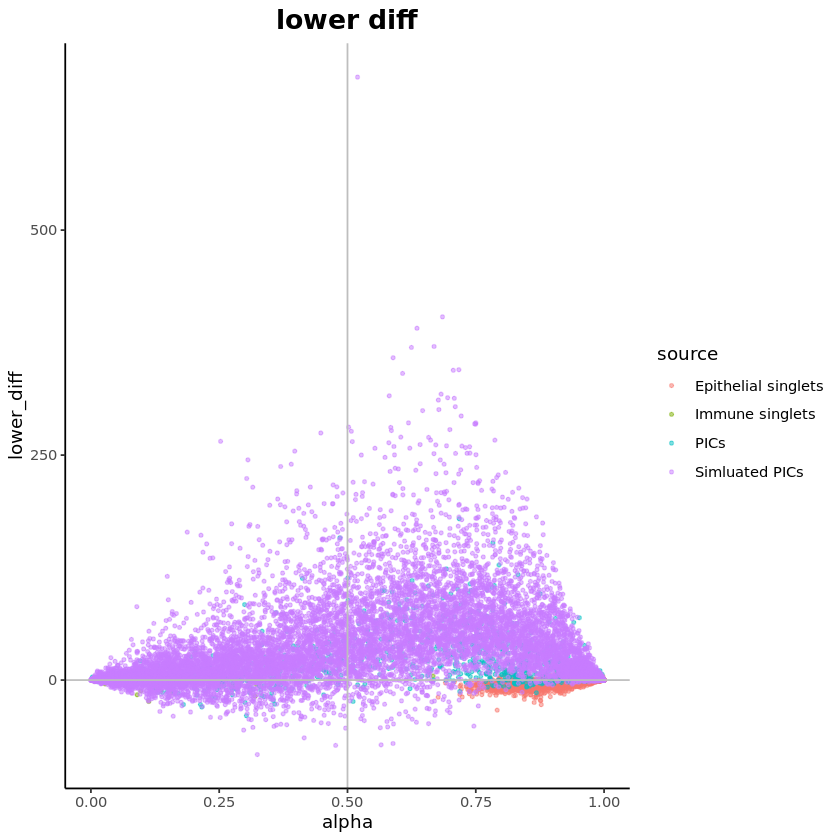

In [193]:
rbind(cbind(imm_mle_res, source='Immune singlets'), 
      cbind(epi_mle_res, source='Epithelial singlets'), 
      cbind(cbind(mle_res, imm_alpha=0, epi_alpha=1), source='PICs'),
      cbind(cbind(sim_mle_res, imm_alpha=0, epi_alpha=1), source='Simluated PICs')) %>%
    ggplot(aes(x=alpha, y=lower_diff, color=source)) +
    #geom_point(alpha=1, pch=21, color='black', size=0.5) +
    geom_point(alpha=0.5, size=0.8) +
    geom_hline(yintercept = 0, color='gray') +
    geom_vline(xintercept = 0.5, color='gray') +
    labs(title='lower diff') + 
    scale_x_continuous(limits = c(0, 1)) +
    theme(plot.title = element_text(size=16, hjust=0.5, face='bold'))

In [34]:
nrow(mle_res)

[1] 834

In [35]:
diff_excluded = rownames(mle_res)[mle_res$lower_diff < thresh]

In [36]:
length(diff_excluded)

[1] 191

In [37]:
good_pics = setdiff(rownames(mle_res), diff_excluded)

In [42]:
writeLines(good_pics, 'annotations/neutrophil_good_pics_final.txt')

In [38]:
length(good_pics)

[1] 643

In [44]:
db_mat@cell_metadata[good_pics, 'Cell_type'] %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       161        482 

In [201]:
db_mat@cell_metadata[good_pics, c('Age', 'condition')] %>% mutate(Age = factor(Age, levels=age_order)) %>% table

     condition
Age   normal tumor
  10d      0     0
  3w       1     0
  6w       1     8
  8w       0    55
  10w      0   257
  12w      2   319

In [202]:
sin_cl@annots[mle_res[good_pics[db_mat@cell_metadata[good_pics, 'Age'] == '12w' & 
                                db_mat@cell_metadata[good_pics, 'condition'] == 'tumor'],
                      'b_mc']] %>% table

.
            AP high       Cystatin high          Ptgs2 high                TAN1 
                 93                   6                  78                  45 
               TAN2                TAN3 Young Cystatin high 
                 44                  48                   5 

In [203]:
sin_cl@annots[mle_res[good_pics, 'b_mc']] %>% table

.
            AP high       Cystatin high          Ptgs2 high                TAN1 
                194                  12                 130                  95 
               TAN2                TAN3 Young Cystatin high 
                 80                 120                  12 

# Heatmaps for proof

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


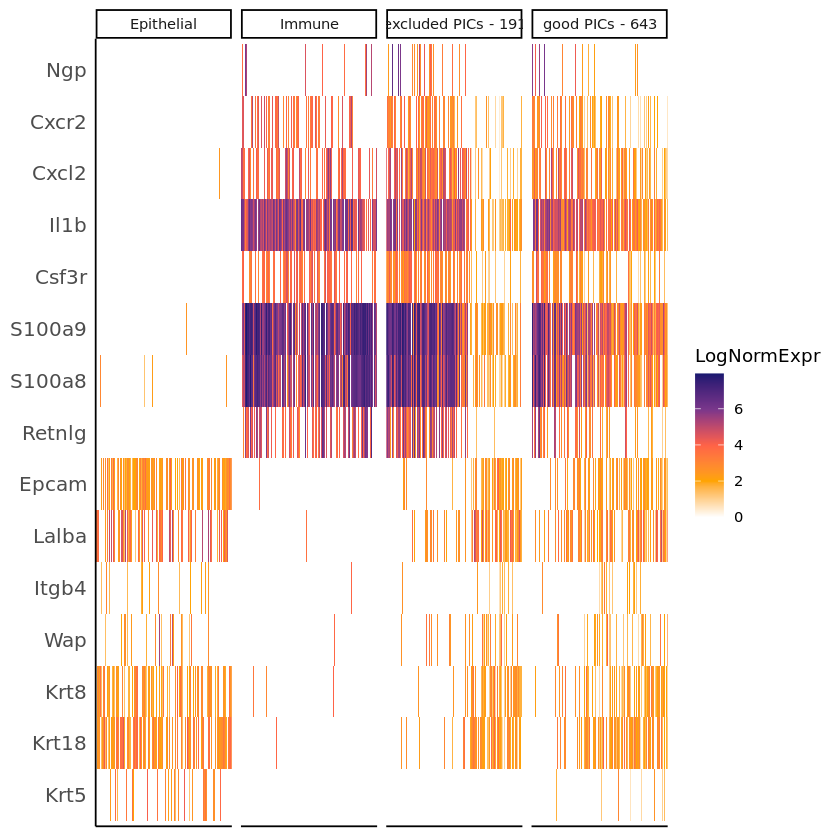

In [204]:
disp_genes = c('Krt5', 'Krt18', 'Krt8', 'Wap', 'Itgb4', 'Lalba', 'Epcam', 
               'Retnlg', 'S100a8', 'S100a9', 'Csf3r', 'Il1b', 'Cxcl2', 'Cxcr2', 'Ngp')

db_umis = read_large_umis("neutrophil_clean_pics", cells = rownames(mle_res))
epithelial_umis = read_large_umis("merged_neutrophil_epithelial_mat", cells = epithelial_cells)
immune_umis = read_large_umis("merged_neutrophil_epithelial_mat", cells = immune_cells)
focus_mat = t(db_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))

df1 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% 
    cbind(source=rep(ifelse(pmin(mle_res$epi_diff, mle_res$imm_diff) < thresh, 
                            paste0('excluded PICs - ', length(diff_excluded)), 
                            paste0('good PICs - ', length(good_pics))), 
                     each=length(disp_genes)))

focus_mat = t(epithelial_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))
df2 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='Epithelial')

focus_mat = t(immune_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))
df3 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='Immune')

df1$cell_name = factor(df1$cell_name, 
                       levels=rownames(mle_res)[order(mle_res$alpha)])

ggplot(rbind(df1, df2, df3) %>% 
           mutate(source=factor(source, levels=c('Epithelial', 'Immune', 
                                                 paste0('excluded PICs - ', length(diff_excluded)), 
                                                 paste0('good PICs - ', length(good_pics))))), 
       aes(x=cell_name, y=gene, fill=LogNormExpr)) +
    geom_tile() +
    scale_fill_gradientn(colors=c("white", "orange", "tomato", "mediumorchid4", "midnightblue")) +
    facet_grid(~ source, scales = 'free_x') +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks = element_blank(),
          axis.title.y = element_blank(), axis.text = element_text(size = 12))

ggsave("final_figs/supp4/gene_compare_all.png", dpi=1200, width=15, height=5)

In [37]:
#rerun
good_pics = rownames(mle_res)
good_pics = good_pics[pmin(mle_res$imm_diff, mle_res$epi_diff) >= thresh]
#good_pics = good_pics[db_mat@cell_metadata[good_pics,'total_counts'] >= 650]
alpha = mle_res[good_pics, "alpha"]; names(alpha) = good_pics
epithelial_mc = mle_res[good_pics, "a_mc"]; names(epithelial_mc) = good_pics
immune_mc = mle_res[good_pics, "b_mc"]; names(immune_mc) = good_pics
parser_epithelial = color2name[ sin_cl@colors[ epithelial_mc]]; names(parser_epithelial) = good_pics
parser_immune = color2name[ sin_cl@colors[ immune_mc]]; names(parser_immune) = good_pics

table(parser_epithelial)
table(parser_immune)

parser_epithelial
          Alveolar Alveolar secretory     Alveolar spp l    Alveolar spp1 h 
                17                 58                347                129 
                HS      Myoepithelial             MyoLum       Progenitor 1 
                11                  9                 19                 25 
      Progenitor 2 
                28 

parser_immune
            AP high       Cystatin high          Ptgs2 high                TAN1 
                194                  12                 130                  95 
               TAN2                TAN3 Young Cystatin high 
                 80                 120                  12 

In [206]:
writeLines(good_pics, 'annotations/neutrophil_good_pics.txt')

In [38]:
length(good_pics)

[1] 643

In [36]:
table(db_mat@cell_metadata[good_pics, c('Age', 'condition')] %>% mutate(Age = factor(Age, levels=age_order)))

     condition
Age   normal tumor
  10d      0     0
  3w       1     0
  6w       1     8
  8w       0    55
  10w      0   257
  12w      2   319

### Unified heatmap

In [209]:
cell_stats = rbind(db_mat@cell_metadata, sin_mat@cell_metadata[colnames(db_mat@cell_metadata)])
comb = with(cell_stats, paste0(ifelse(rownames(cell_stats) %in% db_mat@cells, "PIC", "Singlet"), "@",
                               condition, "@", Age, "@", Cell_type)); 
names(comb) = rownames(cell_stats)

In [210]:
cell_stats$is_pic = ifelse(rownames(cell_stats) %in% db_mat@cells, "PIC", "Singlet")

In [211]:
cell_stats$epithelial_type = ifelse(rownames(cell_stats) %in% good_pics, 
                                    parser_epithelial[rownames(cell_stats)], 
                                    ifelse(sin_cl@annots[sin_cl@mc[rownames(cell_stats)]] %in% epithelial_pops,
                                           sin_cl@annots[sin_cl@mc[rownames(cell_stats)]], NA))

In [212]:
cell_stats$immune_type = ifelse(rownames(cell_stats) %in% good_pics, 
                                parser_immune[rownames(cell_stats)], 
                                ifelse(sin_cl@annots[sin_cl@mc[rownames(cell_stats)]] %in% immune_pops,
                                           sin_cl@annots[sin_cl@mc[rownames(cell_stats)]], NA))

In [213]:
full_cell_stats = cell_stats

In [214]:
imhm_genes = rev(c("S100a9", "S100a8", "Wfdc17", "Ifitm1", 
                   "Cxcl2", "Ccrl2", "Tnfaip3", "Ptgs2", "Nfkbid", "Ccl3", 
                   "H2-Ab1", "Cd74", "H2-Aa", "Ccl6", 
                   "Retnla", "Cstdc6", "Cstdc5", "Cstdc4", "Csta3", "Stfa3", "Stfa2", "Stfa2l1", "Stfa1", 
                   "Retnlg", "Lyz2", "Pglyrp1", "Wfdc21", 
                   "Camp", "Ngp", "Arhgdib", "Ifitm6", "Mmp8", "Cd177", "Ly6a2", "Adpgk"))
epi_hm_genes = c("Kit", "Aldh1a3", "Mfge8", "Fcgbp", "Wfdc18", "Krt8", "Krt18", "Cp", 
                 "Lalba", "Csn3", 
                 "Cited1", "Pgr", "Esr1", "Prlr", 
                 "Myl9", "Acta2", #"Pdpn", "Mylk", "Myh11", "Ecrg4", "Oxtr", "Tpm2", 
                 "Krt5", "Krt14", 
                 "Krt17", "Rbp1", "Rflnb", "Gja1", #"Pclaf", "Tuba1b", "Hmgb2", "Ccna2",
                 #"Spp1",
                 "Wap", "Csn1s1", "Csn1s2a", "Csn2", "Thrsp", "Car6", "Saa1", "Saa2")
disp_genes = c(imhm_genes, epi_hm_genes)

In [215]:
hm_stats = full_cell_stats %>% 
    filter(!is.na(epithelial_type) | !is.na(immune_type)) %>% 
    select(Age, condition, is_pic, epithelial_type, immune_type)

In [216]:
pic_rows = which(hm_stats$is_pic == 'PIC')

In [217]:
epithelial_rows = which(is.na(hm_stats$immune_type))

In [218]:
immune_rows = which(is.na(hm_stats$epithelial_type))

In [219]:
hm_df = hm_stats[c(pic_rows, sample(epithelial_rows, length(pic_rows)), sample(immune_rows, length(pic_rows))),]

In [220]:
hm_df$alpha = ifelse(hm_df$is_pic == 'PIC', alpha[rownames(hm_df)], 
                     ifelse(is.na(hm_df$immune_type), 1, 0))

In [221]:
hm_df = hm_df %>% mutate(Source = factor(ifelse(is_pic == "PIC", 'PIC', ifelse(is.na(epithelial_type), 'Immune', 'Epithelial')),
                                         levels=c('Immune', 'Epithelial', 'PIC')),
                         immune_type=factor(immune_type, levels=cell_order),
                         epithelial_type=factor(epithelial_type, levels=cell_order))

In [222]:
hmgene_df = rbind(apply(t(sin_mat@mat[,rownames(hm_df %>% filter(is_pic =='Singlet'))]), 1, 
                        function(x){log1p(1e4 * x / sum(x))}) %>% t %>% as.data.frame %>% select(disp_genes),
                  apply(t(db_mat@mat[,rownames(hm_df %>% filter(is_pic =='PIC'))]), 1, 
                        function(x){log1p(1e4 * x / sum(x))}) %>% t %>% as.data.frame %>% select(disp_genes)) %>%
    as.matrix %>% t

In [223]:
c_vec = sin_cl@colors[!duplicated(sin_cl@colors)]
names(c_vec) = sin_cl@annots[!duplicated(sin_cl@annots)]

In [224]:
ha1 = HeatmapAnnotation(show_legend = F,
                        Immune_annot=factor(hm_df$immune_type, levels = cell_order), 
                        Epithelial_annot=factor(hm_df$epithelial_type, levels = cell_order), 
                        col = list(Immune_annot=c_vec, Epithelial_annot=c_vec))

ha2 = HeatmapAnnotation(alpha=hm_df$alpha,
                        col = list(alpha=colorRamp2(c(0, 0.5, 1), c("limegreen", "gray40", "firebrick3"))))

In [225]:
png(file="final_figs/supp4/heatmap_comb.png", 
    width = 10,
    height    = 6,
    units     = "in",
    res       = 1200,
    pointsize = 1
)

hm_plot = Heatmap(hmgene_df[,rownames(hm_df)], 
                  row_names_gp = gpar(fontsize=6), 
                  show_column_dend = F, 
                  column_order = rownames(hm_df %>% arrange(is_pic, immune_type, epithelial_type, alpha)), 
                  row_order = disp_genes,
                  column_split = hm_df$Source,
                  row_split = factor(ifelse(disp_genes %in% imhm_genes, "Immune genes", "Epithelial genes"), 
                                            levels=c("Immune genes", "Epithelial genes")),
                  heatmap_legend_param = list(labels_gp = gpar(fontsize = 6)),
                  cluster_rows = F, 
                  cluster_columns =  F, 
                  top_annotation = ha1, 
                  bottom_annotation = ha2, 
                  show_column_names = F,
                  col = colorRampPalette(c("white", "orange", "tomato", "mediumorchid4", "midnightblue"))(10000), 
                  use_raster = F)
plot(hm_plot)
dev.off()

png 
  2

In [226]:
write_lines(disp_genes, "final_figs/supp4/hm_gene_list.txt")

# Composition analysis

In [227]:
cell_stats[rownames(cell_stats) %in% good_pics & cell_stats$condition == 'tumor',] %>% dcast(Age ~ Replicate)

Using immune_type as value column: use value.var to override.

Aggregation function missing: defaulting to length



Age 1  2  3   4   5 
1 6w   0  0   8   0  0
2 8w   0  0  55   0  0
3 10w  0  0   0 202 55
4 12w 53 59 139  68  0

In [228]:
cell_stats[rownames(cell_stats) %in% good_pics & cell_stats$condition == 'normal',] %>% dcast(Age ~ Replicate)

Using immune_type as value column: use value.var to override.

Aggregation function missing: defaulting to length



Age 2 3 4
1 3w  0 0 1
2 6w  0 1 0
3 12w 2 0 0

In [229]:
cell_stats = cell_stats[cell_stats$condition == 'tumor' & cell_stats$Age %in% c('8w', '10w', '12w'),]

In [230]:
cell_stats$Cell_type %>% unique

[1] EPCAM-CD45 EPCAM-LY6G CD45+      EPCAM      CD45-      LY6G      
Levels: EPCAM-CD45 EPCAM-LY6G CD45+ CD45- EPCAM LY6G

In [231]:
immune_replicate_df = cell_stats %>%
    filter(Cell_type %in% c('LY6G', 'EPCAM-LY6G')) %>%
    #filter(Age != '10w') %>%
    #filter(Age %in% c('8w', '10w', '12w') & condition == 'tumor') %>%
    group_by(Age, condition, is_pic, immune_type, Replicate) %>% 
    summarise(Count=length(Age)) %>% drop_na() %>% as.data.frame %>%
    complete(Age, condition, is_pic, immune_type, Replicate, fill=list(Count=0)) %>%
    group_by(Age, condition, is_pic, Replicate) %>% 
    summarise(Age=Age,
              condition=condition,
              is_pic=is_pic,
              annotation=immune_type,
              Replicate=Replicate,
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count)) %>%
    filter(total > 10)

immune_replicate_df$annotation = factor(immune_replicate_df$annotation, levels=cell_order)
immune_replicate_df$condition = factor(immune_replicate_df$condition, levels=rev(cond_order))
immune_replicate_df$Age = factor(immune_replicate_df$Age, levels=age_order)
immune_replicate_df$is_pic = factor(immune_replicate_df$is_pic, levels=c('Singlet', 'PIC'))
#immune_replicate_df = remove_missing(immune_replicate_df)

`summarise()` has grouped output by 'Age', 'condition', 'is_pic',
'immune_type'. You can override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'is_pic', 'Replicate'.
You can override using the `.groups` argument.


In [232]:
epithelial_replicate_df = cell_stats %>%
    filter(Cell_type %in% c('EPCAM', 'EPCAM-LY6G')) %>%
    #filter(Age != '10w') %>%
    #filter(Age %in% c('8w', '10w', '12w') & condition == 'tumor') %>%
    group_by(Age, condition, is_pic, epithelial_type, Replicate) %>% 
    summarise(Count=length(Age)) %>% drop_na() %>% as.data.frame %>%
    complete(Age, condition, is_pic, epithelial_type, Replicate, fill=list(Count=0)) %>%
    group_by(Age, condition, is_pic, Replicate) %>% 
    summarise(Age=Age,
              condition=condition,
              is_pic=is_pic,
              annotation=epithelial_type,
              Replicate=Replicate,
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count)) %>%
    filter(total > 10)

epithelial_replicate_df$annotation = factor(epithelial_replicate_df$annotation, levels=cell_order)
epithelial_replicate_df$condition = factor(epithelial_replicate_df$condition, levels=rev(cond_order))
epithelial_replicate_df$Age = factor(epithelial_replicate_df$Age, levels=age_order)
epithelial_replicate_df$is_pic = factor(epithelial_replicate_df$is_pic, levels=c('Singlet', 'PIC'))
#epithelial_replicate_df = remove_missing(epithelial_replicate_df)

`summarise()` has grouped output by 'Age', 'condition', 'is_pic',
'epithelial_type'. You can override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'is_pic', 'Replicate'.
You can override using the `.groups` argument.


In [233]:
composition_plots = function(replicate_df, pop_name, exclude_ages=c(), basedir='final_figs/fig4/pic_composition/'){
    means_df = replicate_df %>%
    group_by(Age, condition, is_pic, annotation) %>% 
    summarise(mean_fraction=mean(fraction)) %>%
    mutate_all(~replace(., is.na(.), 0)) %>%
    filter(!Age %in% exclude_ages) %>%
    mutate(Age=factor(Age, levels=age_order), 
           condition=factor(condition, levels=cond_order), 
           is_pic=factor(is_pic, levels=c('Singlet', 'PIC')))
        
    p = ggplot(means_df, aes(y=mean_fraction, x=is_pic, fill=annotation)) + 
    geom_bar(position="fill", stat="identity", orientation = "x") +
    scale_fill_manual(values = group.colors) +
    facet_grid(condition ~ Age) +
    theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.x = element_blank(),
          axis.text.x = element_text(vjust = 0.5, hjust = 1, angle = 90),
          legend.box.margin = margin(c(0,0,0,5)),
          legend.title = element_text(size=12),   
          strip.background = element_rect(linetype="blank"),
          axis.text.y = element_blank(), axis.title.y = element_blank(),
          axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
          axis.line.x = element_blank(), axis.line.y = element_blank())

    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))

    ggsave(paste0(basedir, "/composition_bar_", pop_name, ".png"), plot = p, width = 5, height = 6, dpi = 1200)
    ggsave(paste0(basedir, "/composition_bar_", pop_name, "_legend.png"), plot = l, width=4, height=6)
    
    for (annot in unique(means_df$annotation)){
        boxplot_df = replicate_df[replicate_df$annotation == annot,] %>% 
            mutate(condition=factor(condition, levels=rev(cond_order)), 
                   Age=factor(Age, levels=age_order), 
                   is_pic=factor(is_pic, levels=c('Singlet', 'PIC')))
        plot_df = means_df[means_df$annotation == annot,] %>% 
            mutate(condition=factor(condition, levels=rev(cond_order)), 
                   Age=factor(Age, levels=age_order), 
                   is_pic=factor(is_pic, levels=c('Singlet', 'PIC')))
        ggplot(plot_df, aes(x=Age, y=mean_fraction, col=is_pic)) +
            geom_line(aes(group=is_pic), size=1) +
            geom_boxplot(data=boxplot_df, 
                         aes(y=fraction), size=0.5, show.legend = F, width=0.2,
                         position = position_dodge(width = 0.25)) +
            scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1.5))) +
            #facet_grid(~ condition) +
            labs(title=paste(annot, "fraction of cells")) +
            scale_x_discrete(limits=age_order[4:6]) +
            expand_limits(y = 0) +
            theme(plot.title = element_text(hjust=0.5, size=20, face='bold'), strip.text = element_text(size=12))

        ggsave(paste0(basedir, "/fraction_final/fraction_", annot, "_box.png"), dpi = 1200)
    }
}

In [234]:
composition_plots(epithelial_replicate_df, 'epithelial')

`summarise()` has grouped output by 'Age', 'condition', 'is_pic'. You can
override using the `.groups` argument.
`mutate_all()` ignored the following grouping variables:
• Columns `Age`, `condition`, `is_pic`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.
Warning message:
“There were 6 warnings in `mutate()`.
The first warning was:
ℹ In argument: `annotation = (structure(function (..., .x = ..1, .y = ..2, . =
  ..1) ...`.
ℹ In group 1: `Age = 8w`, `condition = tumor`, `is_pic = Singlet`.
Caused by warning in `[<-.factor`:
! invalid factor level, NA generated
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [235]:
composition_plots(immune_replicate_df, 'neutrophil')

`summarise()` has grouped output by 'Age', 'condition', 'is_pic'. You can
override using the `.groups` argument.
`mutate_all()` ignored the following grouping variables:
• Columns `Age`, `condition`, `is_pic`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.
Warning message:
“There were 6 warnings in `mutate()`.
The first warning was:
ℹ In argument: `annotation = (structure(function (..., .x = ..1, .y = ..2, . =
  ..1) ...`.
ℹ In group 1: `Age = 8w`, `condition = tumor`, `is_pic = Singlet`.
Caused by warning in `[<-.factor`:
! invalid factor level, NA generated
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


# Comb validation

In [236]:
df = data.frame(cbind(parser_immune, parser_epithelial))

In [237]:
df$Age = factor(full_cell_stats[rownames(df),'Age'], levels=age_order)
df$condition = factor(full_cell_stats[rownames(df),'condition'], levels=cond_order)

In [238]:
df[df$condition == 'tumor',] %>% group_by(parser_immune, parser_epithelial) %>%
    summarise(num=length(Age))  %>%
    dcast(parser_immune ~ parser_epithelial, fill = 0) %>%
    column_to_rownames('parser_immune') %>%
    cbind(total=rowSums(.)) %>%
    rbind(total=colSums(.))

`summarise()` has grouped output by 'parser_immune'. You can override using the
`.groups` argument.
Using num as value column: use value.var to override.



Alveolar Alveolar secretory Alveolar spp l Alveolar spp1 h
AP high              8       13                 105             26            
Cystatin high        0        0                  10              0            
Ptgs2 high           3       13                  68             31            
TAN1                 2       10                  53             19            
TAN2                 1        7                  43             22            
TAN3                 2       14                  62             28            
Young Cystatin high  0        1                   6              3            
total               16       58                 347            129            
                    HS Myoepithelial MyoLum Progenitor 1 Progenitor 2 total
AP high              5 4             10      9           11           191  
Cystatin high        0 0              0      0            1            11  
Ptgs2 high           0 3              3      3            6           130  
TAN1                 2 1              2      2            4            95  
TAN2                 1 0              1      4            1            80  
TAN3                 3 1              3      3            4           120  
Young Cystatin high  0 0              0      2            0            12  
total               11 9             19     23           27           639

`summarise()` has grouped output by 'parser_immune', 'parser_epithelial'. You
can override using the `.groups` argument.
Saving 6.67 x 6.67 in image


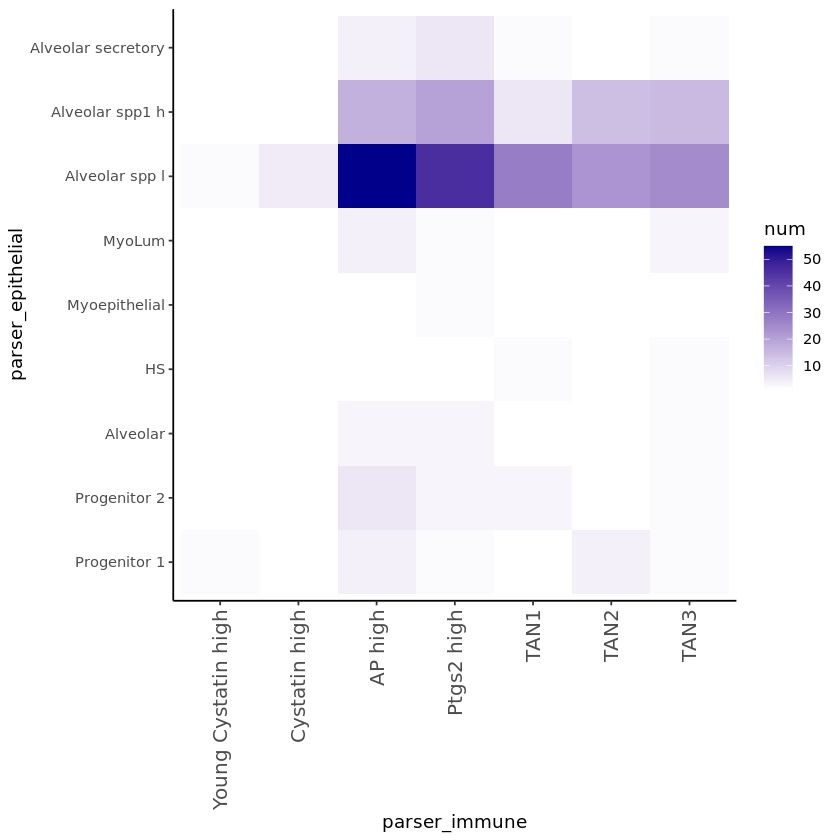

In [239]:
df[df$condition == 'tumor',] %>% group_by(parser_immune, parser_epithelial, Age) %>%
    summarise(num=length(Age))  %>%
    mutate(parser_epithelial=factor(parser_epithelial, levels=cell_order), 
           parser_immune=factor(parser_immune, levels=cell_order)) %>%
    filter(Age %in% c('8w', '10w', '12w')) %>%
    ggplot(aes(x=parser_immune, y=parser_epithelial, fill=num)) +
    geom_tile() +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size=12)) +
    scale_fill_gradient(low='white', high='darkblue')
ggsave('final_figs/supp4/comb_abundance.png', dpi=1200)

`summarise()` has grouped output by 'parser_immune', 'parser_epithelial'. You
can override using the `.groups` argument.
Saving 6.67 x 6.67 in image


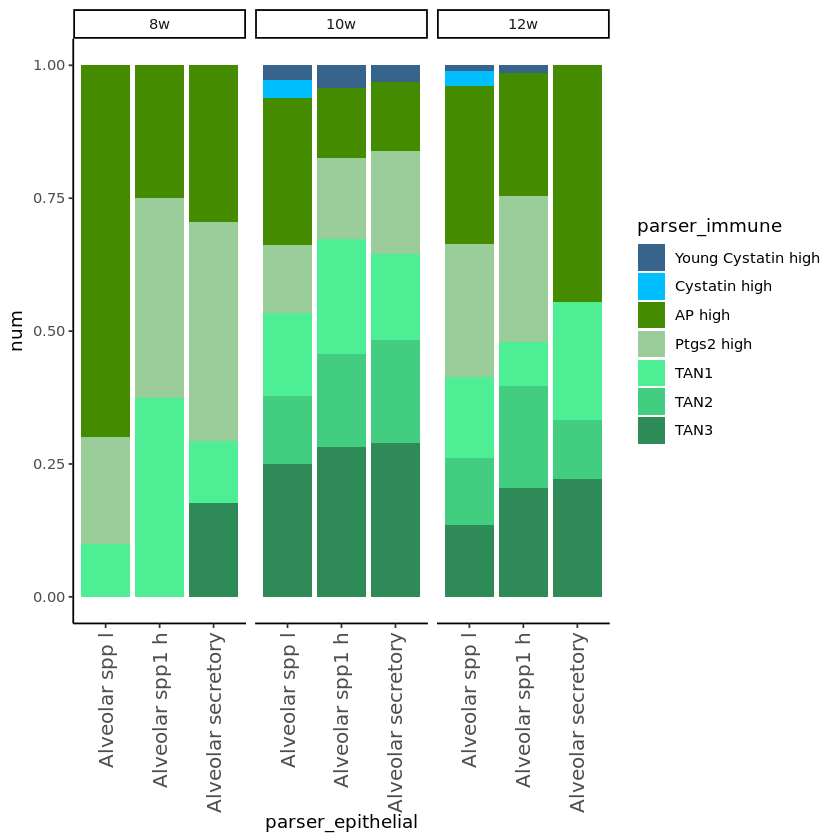

In [240]:
df[df$condition == 'tumor',] %>% group_by(parser_immune, parser_epithelial, Age) %>%
    summarise(num=length(Age))  %>%
    mutate(parser_epithelial=factor(parser_epithelial, levels=cell_order), 
           parser_immune=factor(parser_immune, levels=cell_order)) %>%
    filter(Age %in% c('8w', '10w', '12w')) %>%
    filter(parser_epithelial %in% c('Alveolar secretory', 'Alveolar spp1 h', 'Alveolar spp l')) %>%
    ggplot(aes(x=parser_epithelial, y=num, fill=parser_immune)) +
    geom_bar(stat='identity', position='fill') +
    scale_fill_manual(values = group.colors) +
    facet_grid(~ Age) +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size=12))

ggsave('final_figs/supp4/subcomposition_immune.png', dpi=1200)

`summarise()` has grouped output by 'parser_immune', 'parser_epithelial'. You
can override using the `.groups` argument.
Saving 6.67 x 6.67 in image


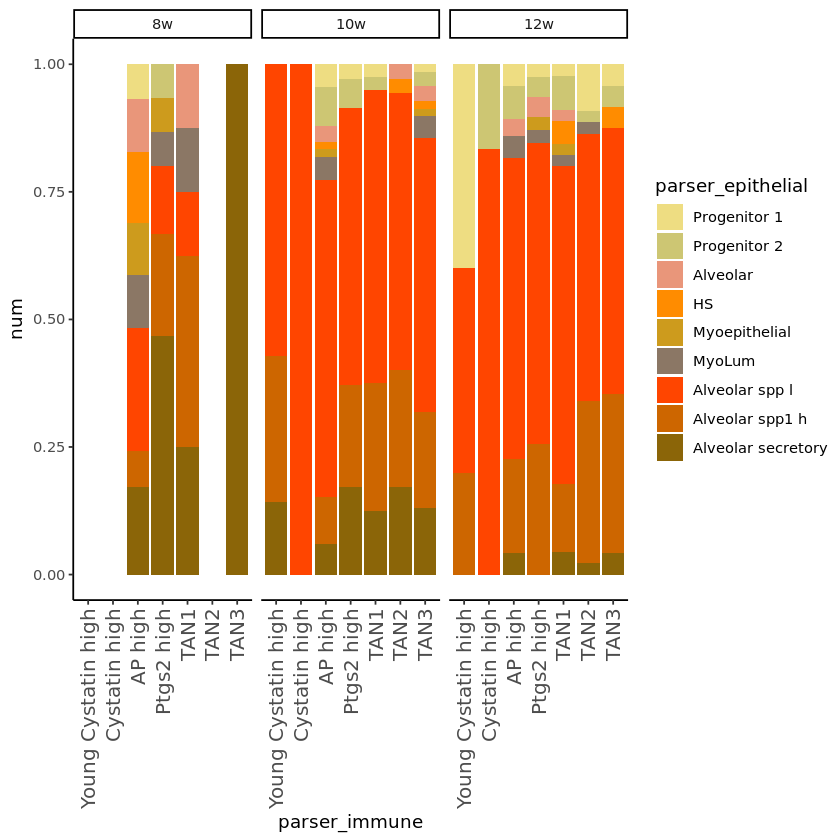

In [245]:
df[df$condition == 'tumor',] %>% group_by(parser_immune, parser_epithelial, Age) %>%
    summarise(num=length(Age))  %>%
    mutate(parser_epithelial=factor(parser_epithelial, levels=cell_order), 
           parser_immune=factor(parser_immune, levels=cell_order)) %>%
    filter(Age %in% c('8w', '10w', '12w')) %>%
    #filter(parser_immune %in% c('TAN1', 'TAN2', 'Recruiters', 'Mature')) %>%
    ggplot(aes(x=parser_immune, y=num, fill=parser_epithelial)) +
    geom_bar(stat='identity', position='fill') +
    scale_fill_manual(values = group.colors) +
    facet_grid(~ Age) +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size=12))

ggsave('final_figs/supp4/subcomposition_epithelial.png', dpi=1200)

# New DGE analysis

In [24]:
good_pics = read_lines('annotations/neutrophil_good_pics_final.txt')

In [25]:
db_mat@cell_metadata[good_pics, 'Cell_type'] %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       161        482 

In [24]:
161 + 482

[1] 643

In [119]:
numis=500
pic_umis = read_large_umis("neutrophil_clean_pics", cells = good_pics)
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

Retained 643 PIC with >500 UMI



In [44]:
analyzed_pics = good_pics[db_mat@cell_metadata[good_pics,'Age'] %in% c('8w', '10w', '12w') & 
                          db_mat@cell_metadata[good_pics,'condition'] == 'tumor' &
                          parser_epithelial[good_pics] %in% c('Alveolar spp l', 'Alveolar spp1 h', 'Alveolar secretory')]

In [45]:
analyzed_parser = parser_immune[analyzed_pics]

In [46]:
length(sin_mat@genes)

[1] 36893

In [47]:
length(rownames(pic_umis))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'pic_umis' not found


In [124]:
shared_mat_genes = intersect(names(which(rowSums(sin_mat@mat[,c(immune_cells, epithelial_cells)]) > 3)), 
                             names(which(rowSums(pic_umis[,analyzed_pics]) > 3))) %>%
    setdiff(bad_genes)

In [48]:
length(shared_mat_genes)

ERROR: Error in eval(expr, envir, enclos): object 'shared_mat_genes' not found


In [45]:
simulate_npics = function(cell_name, n=50, return_separated=T, select_half=0){
    numis = sum(pic_umis[shared_mat_genes, cell_name])
    mc_a = mle_res[cell_name,'a_mc']
    mc_b = mle_res[cell_name,'b_mc']
    alpha = mle_res[cell_name,'alpha']
    numis_a = round(alpha * numis)
    numis_b = numis - numis_a
    cell_a_options = names(which(sin_cl@mc == mc_a))
    cell_b_options = names(which(sin_cl@mc == mc_b))
    if (select_half == 1){
        cell_a_options = cell_a_options[1:floor(length(cell_a_options) / 2)]
        cell_b_options = cell_b_options[1:floor(length(cell_b_options) / 2)]
    } else if (select_half == 2){
        cell_a_options = cell_a_options[ceiling(length(cell_a_options) / 2):length(cell_a_options)]
        cell_b_options = cell_b_options[ceiling(length(cell_b_options) / 2):length(cell_b_options)]
    }
    cells_a = sample(cell_a_options, size = n, replace = T)
    cells_b = sample(cell_b_options, size = n, replace = T)
    cell_sizes = colSums(sin_mat@mat[shared_mat_genes, c(cells_a, cells_b)])
    a_modifier = pmax(ceiling(numis_a / cell_sizes[cells_a]), 1)
    b_modifier = pmax(ceiling(numis_b / cell_sizes[cells_b]), 1)
    a_umis = .downsamp_var(sweep(sin_mat@mat[shared_mat_genes, cells_a], 2, a_modifier, "*"), rep(numis_a, n), replace=F)
    colnames(a_umis) = paste(cell_name, "sim", 1:n, "epi", sep="_")
    b_umis = .downsamp_var(sweep(sin_mat@mat[shared_mat_genes, cells_b], 2, b_modifier, "*"), rep(numis_b, n), replace=F)
    colnames(b_umis) = paste(cell_name, "sim", 1:n, "imm", sep="_")
    simpic_umis = a_umis + b_umis
    colnames(simpic_umis) = paste(cell_name, "sim", 1:n, sep="_")
    if (return_separated){
        return(cbind(a_umis, b_umis, simpic_umis))
    } else {
        return(simpic_umis)
    }
    
}

In [720]:
simpics_full = sapply(analyzed_pics, function(x){simulate_npics(x, n=1000, return_separated=T)}) %>% do.call(cbind, .)

In [721]:
scdb_add_mat("sims_1000_new", simpics_full)

In [126]:
simpics_full = scdb_mat("sims_1000_select_genes")

In [127]:
nrow(simpics_full)

[1] 10303

In [128]:
ncol(simpics_full)

[1] 1578000

In [130]:
simpics_imm = simpics_full[,grepl("imm", colnames(simpics_full))]
simpics_epi = simpics_full[,grepl("epi", colnames(simpics_full))]
simpics = simpics_full[,!(grepl("imm", colnames(simpics_full)) | grepl("epi", colnames(simpics_full)))]

In [ ]:
sim_pics_2 = sapply(analyzed_pics, function(x){simulate_npics(x, n=3, return_separated = F)}) %>% do.call(cbind, .)

In [51]:
sim_pics_sin1 = sim_pics_2[,seq(1,ncol(sim_pics_2),3)]
sim_pics_sin2 = sim_pics_2[,seq(2,ncol(sim_pics_2),3)]
sim_pics_sin3 = sim_pics_2[,seq(3,ncol(sim_pics_2),3)]

In [131]:
all(colSums(simpics[shared_mat_genes,]) == rep(colSums(pic_umis[shared_mat_genes,analyzed_pics]), each=1000))

[1] TRUE

In [132]:
all_mat = t(pic_umis[shared_mat_genes,])

In [133]:
all_mat = t(pic_umis[shared_mat_genes,analyzed_pics])
norm_num = median(rowSums(all_mat))
norm_mat = norm_num * all_mat / rowSums(all_mat)
message("Normalized by ", norm_num)
#lognorm_mat = log1p(10000 * all_mat / rowSums(all_mat))

Normalized by 653.5



In [55]:
norm_sim1 = norm_num * t(sim_pics_sin1) / colSums(sim_pics_sin1)

In [56]:
norm_sim2 = norm_num * t(sim_pics_sin2) / colSums(sim_pics_sin2)

In [57]:
norm_sim3 = norm_num * t(sim_pics_sin3) / colSums(sim_pics_sin3)

In [58]:
norm_sim = norm_num * t(simpics) / colSums(simpics)

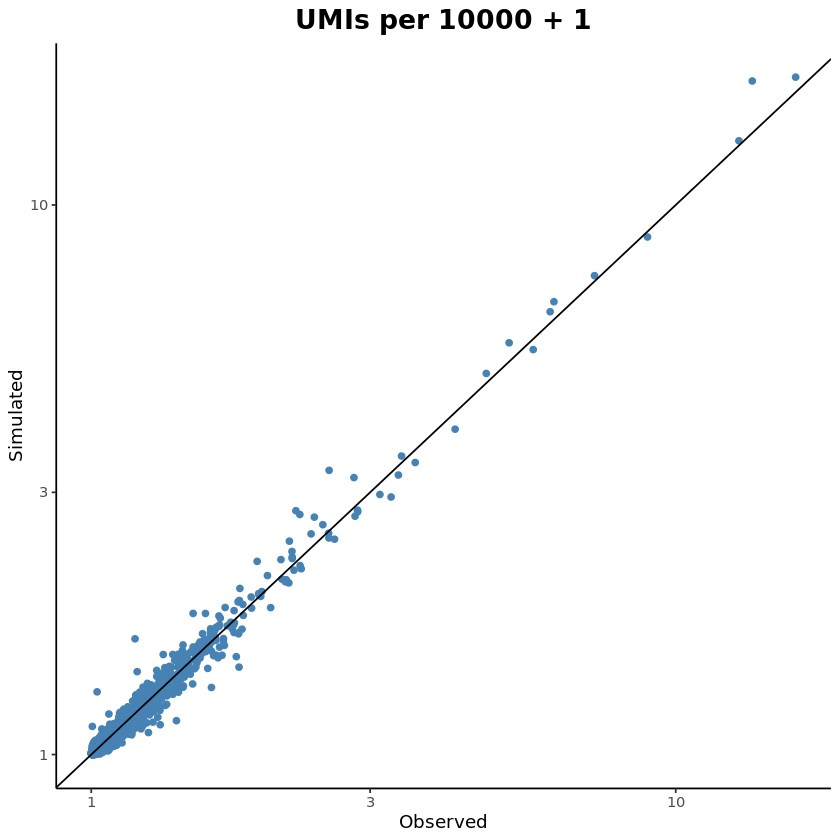

In [59]:
data.frame(x=1 + colMeans(norm_mat), y=1 + colMeans(norm_sim)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    scale_x_log10(labels=scales::number) +
    scale_y_log10(labels=scales::number) +
    labs(x="Observed", y="Simulated", title = "UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

In [60]:
data.frame(x=1 + colMeans(norm_mat), y=1 + colMeans(norm_sim)) %>% lm(formula = x~y) %>% summary


Call:
lm(formula = x ~ y, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.01856 -0.00790 -0.00253  0.00443  0.82345 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.085846   0.001163    73.8   <2e-16 ***
y           0.919274   0.001049   876.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03357 on 10301 degrees of freedom
Multiple R-squared:  0.9868,	Adjusted R-squared:  0.9868 
F-statistic: 7.684e+05 on 1 and 10301 DF,  p-value: < 2.2e-16


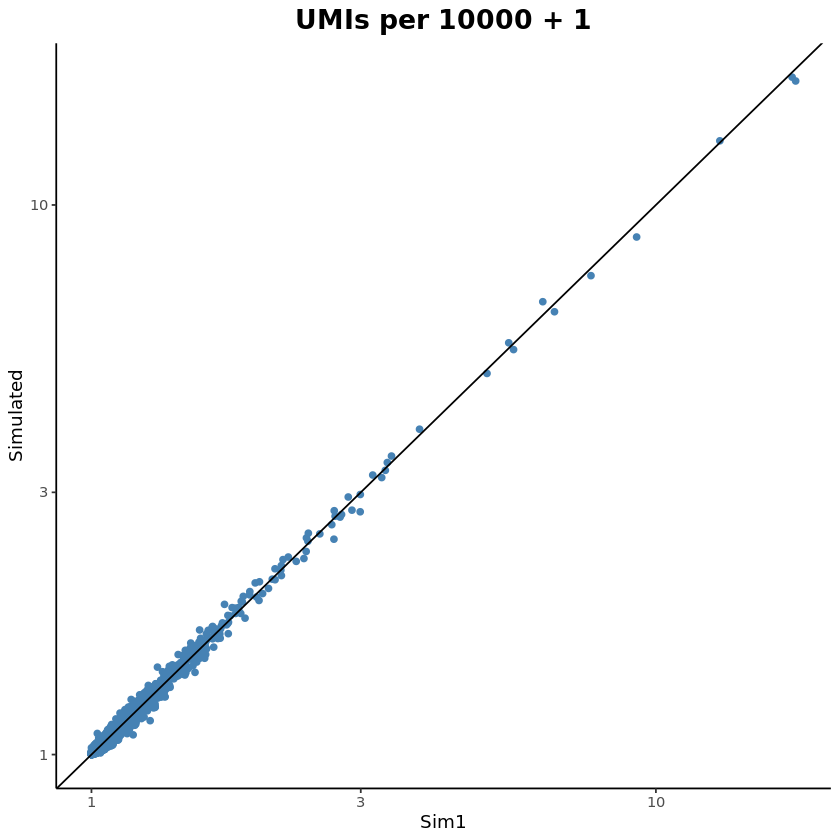

In [61]:
data.frame(x=1 + colMeans(norm_sim1), y=1 + colMeans(norm_sim)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    scale_x_log10(labels=scales::number) +
    scale_y_log10(labels=scales::number) +
    labs(x="Sim1", y="Simulated", title = "UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

In [62]:
data.frame(x=1 + colMeans(norm_sim1), y=1 + colMeans(norm_sim)) %>% lm(formula = x~y) %>% summary


Call:
lm(formula = x ~ y, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48397 -0.00483  0.00016  0.00548  0.53693 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0228036  0.0005720  -39.87   <2e-16 ***
y            1.0214434  0.0005157 1980.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01651 on 10301 degrees of freedom
Multiple R-squared:  0.9974,	Adjusted R-squared:  0.9974 
F-statistic: 3.924e+06 on 1 and 10301 DF,  p-value: < 2.2e-16


# Means analysis

In [269]:
all_mat = t(pic_umis[shared_mat_genes,analyzed_pics])
norm_num = median(rowSums(all_mat))
norm_mat = norm_num * all_mat / rowSums(all_mat)
message("Normalized by ", norm_num)
#lognorm_mat = log1p(10000 * all_mat / rowSums(all_mat))

Normalized by 653.5



In [271]:
norm_sim = norm_num * t(simpics) / colSums(simpics)
#lognorm_sim = log1p(10000 * t(simpics) / colSums(simpics))

In [272]:
norm_sim_epi = rep(mle_res[analyzed_pics,'alpha'], each=1000) * norm_num * t(simpics_epi) / colSums(simpics_epi)
norm_sim_imm = (1 - rep(mle_res[analyzed_pics,'alpha'], each=1000)) * norm_num * t(simpics_imm) / colSums(simpics_imm)

In [273]:
plot_scatter = function(df, fname=NA, pval_thresh=0.01){
    p = ggplot(df %>% arrange(desc(adj_pval)), aes(x=log(0.1 + Simulated_mean), y=log(0.1 + Observed_mean), 
                                                   color=color, size=size, label=label)) +
        geom_text_repel(max.overlaps = 1000, color='black') +
        geom_point() +
        scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) +
        scale_size_identity() +
        geom_abline(intercept = 0, slope=1, color='black', linetype='solid')
    if (!is.na(fname)){
        l = get_legend(p)
        p = plot_grid(p + theme(legend.position="none"))

        ggsave(fname, plot = p, dpi = 1200)
        ggsave(paste0(fname, "_legend.png"), plot = l, dpi=1200)
    }
}

In [274]:
plot_volcano = function(df, fname=NA, pval_thresh=0.01, lfc_thresh=0.5){
    p = ggplot(df %>% arrange(desc(adj_pval)), aes(x=lfc, y=-log10(adj_pval), color=color, size=size, label=label)) +
        geom_point(show.legend=F) +
        geom_text_repel(max.overlaps = 1000, color='black') +
        scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) +
        scale_size_identity() +
        geom_hline(yintercept = -log10(pval_thresh), linetype='longdash', color='gray') +
        geom_vline(xintercept = c(-lfc_thresh, lfc_thresh), linetype='longdash', color='gray')
    if (!is.na(fname)){
        l = get_legend(p)
        p = plot_grid(p + theme(legend.position="none"))

        ggsave(fname, plot = p, dpi = 1200)
        ggsave(paste0(fname, "_legend.png"), plot = l, dpi=1200)
    }
}

In [275]:
per_gene_plots = function(gene, dirname, focus_sim_means, focus_norm_sim, focus_norm_mat, epi_means, imm_means,
                          pval, lfc){
    plot_df = data.frame(mean_norm_expr=c(focus_sim_means[gene,], mean(focus_norm_mat[,gene])),
                         source=c(rep("Simulated", 1000), "Observed"))
    gene_mean = mean(plot_df[plot_df$source == "Simulated","mean_norm_expr"])
    gene_sd = sd(plot_df[plot_df$source == "Simulated","mean_norm_expr"])
    
    # Distribution with SDs
    ggplot(plot_df, aes(x=mean_norm_expr)) +
        geom_density(data=plot_df[plot_df$source == "Simulated",]) +
        geom_vline(xintercept = gene_mean, color='blue', linetype='longdash') +
        geom_vline(xintercept = c(gene_mean + gene_sd, gene_mean - gene_sd), color='steelblue', linetype='longdash') +
        geom_vline(xintercept = c(gene_mean + (2 * gene_sd), gene_mean - (2 * gene_sd)), color='gray', linetype='longdash') +
        geom_vline(xintercept = plot_df[plot_df$source == "Observed","mean_norm_expr"], color='red') +
        geom_point(data=plot_df[plot_df$source == "Observed",], aes(y=0), color='red', size=3) +
        labs(title=gene, subtitle = paste0("adj_pval", pval, " ; lfc = ", round(lfc, 2))) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'), plot.subtitle = element_text(size=12, hjust=0.5))
    ggsave(paste0("final_figs/fig4/new_gene_sd/", dirname, "/", gene, "_dist.png"), dpi=1200)
    
    # Plot of all means
    ggplot(plot_df, aes(x=1, y=mean_norm_expr)) +
        geom_boxplot(data=. %>% filter(source == "Simulated")) +
        geom_jitter(width=0.1, aes(color=source, shape=source, size=source)) +
        scale_shape_manual(values = c(19, 1)) +
        scale_size_manual(values = c(5, 3)) +
        labs(title=gene, subtitle = paste0("adj_pval", pval, " ; lfc = ", round(lfc, 2))) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'), plot.subtitle = element_text(size=12, hjust=0.5),
              axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank())
        #scale_x_discrete(limits=c("Simulated", "Observed"))
    ggsave(paste0("final_figs/fig4/new_gene_sd/", dirname, "/", gene, "_means.png"), dpi=1200, width=5, height=15)
    
    # Violin plot
    #plot_df = data.frame(LogNorm_expression=log1p(c(focus_norm_sim[,gene], focus_norm_mat[,gene])),
    #                     Source=factor(c(rep("Simulated", nrow(focus_norm_sim)), rep("Observed", nrow(focus_norm_mat))),
    #                                   levels = c("Simulated", "Observed")))
    #ggplot(plot_df, aes(x=Source, fill=Source, y=LogNorm_expression)) +
    #    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75)) +
    #    labs(title=gene) +
    #    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'))
    #ggsave(paste0("final_figs/fig4/new_gene_sd/", dirname, "/", gene, "_violin.png"), dpi=1200)
    
    # Bar plot
    bar_df = data.frame(source=factor(c(rep("Simulated", 2), "Observed"), levels=c("Simulated", "Observed")),
                        cell=c("Epithelial", "Neutrophil", "PIC"),
                        expression=c(epi_means[gene], imm_means[gene], mean(focus_norm_mat[,gene])))

    ggplot(bar_df, aes(x=source, y=expression, fill=cell)) +
        geom_bar(stat = 'identity', position = 'stack', color='black') +
        labs(title=gene, subtitle = paste0("adj_pval", pval, " ; lfc = ", round(lfc, 2))) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'), plot.subtitle = element_text(size=12, hjust=0.5))
    ggsave(paste0("final_figs/fig4/new_gene_sd/", dirname, "/", gene, "_barplot.png"), dpi=1200)

}

In [30]:
p = ggplot(data.frame(x=1, y=1, color=seq(0,1,length.out = 1000)), aes(x=x, y=y, color=color)) +
    geom_tile() +
    scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) 
l = get_legend(p)

In [32]:
ggsave(filename = "final_figs/fig4/color_legend.png", dpi=1200, plot=l)

Saving 6.67 x 6.67 in image


In [ ]:
n_sims=1000
pval_thresh=0.05
lfc_thresh=0.5
per_gene = T
min_topn = 2
n_topn = 3

for (pop_name in c('All', 'AP high', 'Ptgs2 high', 'TAN1', 'TAN2', 'TAN3')){
    message("===================================================")
    message(pop_name)
    if (pop_name == "All"){
        focus_singlets = sin_mat@mat[,sin_cl@annots[sin_cl@mc[sin_mat@cells]] %in% c('Alveolar spp l', 'Alveolar spp1 h', 
                                                                                     'Alveolar secretory', immune_pops)]
        is_focus = T
    } else {
        focus_singlets = sin_mat@mat[,sin_cl@annots[sin_cl@mc[sin_mat@cells]] %in% c('Alveolar spp l', 'Alveolar spp1 h', 
                                                                                     'Alveolar secretory', pop_name)]
        is_focus = parser_immune[analyzed_pics] == pop_name
    }
    focus_mat = pic_umis[,analyzed_pics][,is_focus]
    focus_norm_mat = norm_mat[is_focus,]
    focus_means = colMeans(focus_norm_mat)
    
    # Simulation means    
    sim_means_file = paste0("final_figs/fig4/new_gene_sd/", pop_name, "_sim_means.csv")
    if (file.exists(sim_means_file)) {
        message("---Simulation means file found - loading...")
        focus_sim_means = as.matrix(read.csv(sim_means_file, row.names = 1))
    } else {
        message("---Calculating simulation means...")
        all_focus_sim = norm_sim[rep(is_focus, each=n_sims),]
        focus_sim_means = sapply(1:n_sims, function(n){colMeans(all_focus_sim[seq(n, nrow(all_focus_sim), n_sims),])}) 
        message("---Saving...")
        write.csv(focus_sim_means, sim_means_file)
    }
    
    # Gene data
    analysis_genes = shared_mat_genes[(rowSums(focus_mat[shared_mat_genes,] > min_topn) >= n_topn) | 
                                      (rowSums(focus_singlets[shared_mat_genes,] > min_topn) >= n_topn)] %>% 
        setdiff('Rn18s-rs5')
    gene_data_file = paste0("final_figs/fig4/new_gene_sd/", pop_name, "_genedata.csv")
    if (file.exists(gene_data_file)) {
        message("---Gene data file found - loading...")
        gene_df = read.csv(gene_data_file, row.names = 1) %>% as.matrix %>% as.data.frame
    } else {
        message("---Calculating z-score pvals, lfcs etc...")
        focus_sim_sds = sapply(analysis_genes, function(gene){
            sim_vals = focus_sim_means[gene,]
            return(sd(sim_vals))
        })
        focus_z_scores = sapply(analysis_genes, function(gene){
            sim_vals = focus_sim_means[gene,]
            z_score = (focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
            return(z_score)
        })
        focus_z_pvals = 2 * pnorm(abs(focus_z_scores), lower.tail = F)

        focus_sim_meanofmeans = rowMeans(focus_sim_means)
        focus_lfcs = log2((0.1 + focus_means[analysis_genes]) / (0.1 + focus_sim_meanofmeans[analysis_genes]))
        epi_means = colMeans(norm_sim_epi[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),analysis_genes])
        imm_means = colMeans(norm_sim_imm[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),analysis_genes])
        epi_imm_ratio = epi_means / (epi_means + imm_means)

        gene_df = data.frame(Observed_mean = focus_means[analysis_genes],
                             Simulated_mean = focus_sim_meanofmeans[analysis_genes],
                             Sim_SD = focus_sim_sds,
                             z_scores = focus_z_scores,
                             full_adj_pval=p.adjust(focus_z_pvals %>% replace_na(1), method='fdr'),
                             lfc=focus_lfcs,
                             epi_imm_ratio=epi_imm_ratio)
        gene_df$adj_pval = ifelse(gene_df$full_adj_pval < 1e-5, 1e-5, gene_df$full_adj_pval)
        write.csv(gene_df, gene_data_file)
    }
    
    # Plots
    message("---Creating plots...")    
    plot_df = gene_df %>% 
        mutate(color=ifelse(adj_pval < pval_thresh, epi_imm_ratio, NA),
               size=ifelse(adj_pval < pval_thresh, 3, 1),
               label=ifelse(adj_pval < pval_thresh, rownames(.), ""))
    
    plot_scatter(plot_df, pval_thresh = pval_thresh, 
                 fname=paste0("final_figs/fig4/new_gene_sd/", pop_name, "_scatter.png"))
    plot_volcano(plot_df, pval_thresh = pval_thresh, lfc_thresh = lfc_thresh,
                 fname=paste0("final_figs/fig4/new_gene_sd/", pop_name, "_volcano.png"))
    if (per_gene){
        sig_genes = rownames(gene_df)[gene_df$adj_pval < pval_thresh]
        for (gene in sig_genes){
            gene = unlist(str_split(gene, "\\."))[1]
            message(paste0("    ", gene))
            per_gene_plots(gene, pop_name, focus_sim_means, focus_norm_sim, focus_norm_mat, epi_means, imm_means,
                           ifelse(gene_df[gene, 'adj_pval'] == 1e-5, 
                                  ' < 1e-5', 
                                  paste0(" = ", round(gene_df[gene, 'adj_pval'], 5))), 
                           gene_df[gene, 'lfc'])
        }
    }
}

In [276]:
sin_mat@mat[,sin_cl@annots[sin_cl@mc]]

   [[ suppressing 32 column names ‘AB529_N3’, ‘AB541_G24’, ‘AB541_I20’ ... ]]

   [[ suppressing 32 column names ‘AB529_N3’, ‘AB541_G24’, ‘AB541_I20’ ... ]]

   [[ suppressing 32 column names ‘AB529_N3’, ‘AB541_G24’, ‘AB541_I20’ ... ]]



36893 x 12523 sparse Matrix of class "dgCMatrix"
                                                                                      
0610005C13Rik  . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . ......
0610006L08Rik  . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . ......
0610009B22Rik  . 1 1 1 1 1 1 . .  . . . . . . . . . . . . . . . . . . . . . . . ......
0610009E02Rik  . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . ......
0610009L18Rik  . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . ......
0610010K14Rik  . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . ......
0610012D04Rik  . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . ......
0610012G03Rik  . 1 . . . . . 1 1  2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 . . . . . . . . ......
0610025J13Rik  . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . ......
0610030E20Rik  . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . .

In [285]:
# FOR ALL 10-12W TANs

n_sims=1000
pval_thresh=0.05
lfc_thresh=0.5
per_gene = T
min_topn = 2
n_topn = 3

focus_singlets = sin_mat@mat[,sin_cl@annots[sin_cl@mc[sin_mat@cells]] %in% c('Alveolar spp l', 'Alveolar spp1 h', 
                                                                             'Alveolar secretory', 'TAN2', 'TAN3')]
is_focus = parser_immune[analyzed_pics] %in% c('TAN2', 'TAN3') & db_mat@cell_metadata[analyzed_pics,'Age'] %in% c('10w', '12w')

focus_mat = pic_umis[,analyzed_pics][,is_focus]
focus_norm_mat = norm_mat[is_focus,]
focus_means = colMeans(focus_norm_mat)

# Simulation means    
sim_means_file = paste0("final_figs/fig4/new_gene_sd/TANs_merged_1012w_sim_means.csv")
if (file.exists(sim_means_file)) {
    message("---Simulation means file found - loading...")
    focus_sim_means = as.matrix(read.csv(sim_means_file, row.names = 1))
} else {
    message("---Calculating simulation means...")
    all_focus_sim = norm_sim[rep(is_focus, each=n_sims),]
    focus_sim_means = sapply(1:n_sims, function(n){colMeans(all_focus_sim[seq(n, nrow(all_focus_sim), n_sims),])}) 
    message("---Saving...")
    write.csv(focus_sim_means, sim_means_file)
}

# Gene data
analysis_genes = shared_mat_genes[(rowSums(focus_mat[shared_mat_genes,] > min_topn) >= n_topn) | 
                                  (rowSums(focus_singlets[shared_mat_genes,] > min_topn) >= n_topn)] %>% 
    setdiff('Rn18s-rs5')
gene_data_file = paste0("final_figs/fig4/new_gene_sd/TANs_merged_1012w_genedata.csv")
if (file.exists(gene_data_file)) {
    message("---Gene data file found - loading...")
    gene_df = read.csv(gene_data_file, row.names = 1) %>% as.matrix %>% as.data.frame
} else {
    message("---Calculating z-score pvals, lfcs etc...")
    focus_sim_sds = sapply(analysis_genes, function(gene){
        sim_vals = focus_sim_means[gene,]
        return(sd(sim_vals))
    })
    focus_z_scores = sapply(analysis_genes, function(gene){
        sim_vals = focus_sim_means[gene,]
        z_score = (focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
        return(z_score)
    })
    focus_z_pvals = 2 * pnorm(abs(focus_z_scores), lower.tail = F)

    focus_sim_meanofmeans = rowMeans(focus_sim_means)
    focus_lfcs = log2((0.1 + focus_means[analysis_genes]) / (0.1 + focus_sim_meanofmeans[analysis_genes]))
    epi_means = colMeans(norm_sim_epi[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),analysis_genes])
    imm_means = colMeans(norm_sim_imm[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),analysis_genes])
    epi_imm_ratio = epi_means / (epi_means + imm_means)

    gene_df = data.frame(Observed_mean = focus_means[analysis_genes],
                         Simulated_mean = focus_sim_meanofmeans[analysis_genes],
                         Sim_SD = focus_sim_sds,
                         z_scores = focus_z_scores,
                         full_adj_pval=p.adjust(focus_z_pvals %>% replace_na(1), method='fdr'),
                         lfc=focus_lfcs,
                         epi_imm_ratio=epi_imm_ratio)
    gene_df$adj_pval = ifelse(gene_df$full_adj_pval < 1e-5, 1e-5, gene_df$full_adj_pval)
    write.csv(gene_df, gene_data_file)
}

# Plots
message("---Creating plots...")    
plot_df = gene_df %>% 
    mutate(color=ifelse(adj_pval < pval_thresh, epi_imm_ratio, NA),
           size=ifelse(adj_pval < pval_thresh, 3, 1),
           label=ifelse(adj_pval < pval_thresh, rownames(.), ""))

plot_scatter(plot_df, pval_thresh = pval_thresh, 
             fname=paste0("final_figs/fig4/new_gene_sd/TANs_merged_1012w_scatter.png"))
plot_volcano(plot_df, pval_thresh = pval_thresh, lfc_thresh = lfc_thresh,
             fname=paste0("final_figs/fig4/new_gene_sd/TANs_merged_1012w_volcano.png"))
if (per_gene){
    sig_genes = rownames(gene_df)[gene_df$adj_pval < pval_thresh]
    for (gene in sig_genes){
        gene = unlist(str_split(gene, "\\."))[1]
        message(paste0("    ", gene))
        per_gene_plots(gene, "TANs_merged_1012w", focus_sim_means, focus_norm_sim, focus_norm_mat, epi_means, imm_means,
                       ifelse(gene_df[gene, 'adj_pval'] == 1e-5, 
                              ' < 1e-5', 
                              paste0(" = ", round(gene_df[gene, 'adj_pval'], 5))), 
                       gene_df[gene, 'lfc'])
    }
}

---Calculating simulation means...

---Saving...

---Calculating z-score pvals, lfcs etc...

---Creating plots...

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Acod1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Anxa1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Babam2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Btbd7

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Btg2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Ccdc9

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Cxcl2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Dtx3l

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Ell2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Fcgbp

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Flii

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Gadd45g

Saving 6.67 x 6.67 in ima

n_sims=1000
pval_thresh=0.05
lfc_thresh=0.5
per_gene = T
min_topn = 2
n_topn = 3

for (pop_name in c('All', 'AP high', 'Ptgs2 high', 'TAN1', 'TAN2', 'TAN3')){
    message("===================================================")
    message(pop_name)
    if (pop_name == "All"){
        focus_singlets = sin_mat@mat[,sin_cl@annots[sin_cl@mc[sin_mat@cells]] %in% c('Alveolar spp l', 'Alveolar spp1 h', 
                                                                                     'Alveolar secretory', immune_pops)]
        is_focus = T
    } else {
        focus_singlets = sin_mat@mat[,sin_cl@annots[sin_cl@mc[sin_mat@cells]] %in% c('Alveolar spp l', 'Alveolar spp1 h', 
                                                                                     'Alveolar secretory', pop_name)]
        is_focus = parser_immune[analyzed_pics] == pop_name
    }
    focus_mat = pic_umis[,analyzed_pics][,is_focus]
    focus_norm_mat = norm_mat[is_focus,]
    focus_means = colMeans(focus_norm_mat)
    
    # Simulation means    
    sim_means_file = paste0("final_figs/fig4/new_gene/", pop_name, "_sim_means.csv")
    if (file.exists(sim_means_file)) {
        message("---Simulation means file found - loading...")
        focus_sim_means = as.matrix(read.csv(sim_means_file, row.names = 1))
    } else {
        message("---Calculating simulation means...")
        all_focus_sim = norm_sim[rep(is_focus, each=n_sims),]
        focus_sim_means = sapply(1:n_sims, function(n){colMeans(all_focus_sim[seq(n, nrow(all_focus_sim), n_sims),])}) 
        message("---Saving...")
        write.csv(focus_sim_means, sim_means_file)
    }
    
    # Gene data
    analysis_genes = shared_mat_genes[(rowSums(focus_mat[shared_mat_genes,] > min_topn) >= n_topn) | 
                                      (rowSums(focus_singlets[shared_mat_genes,] > min_topn) >= n_topn)] %>% 
        setdiff('Rn18s-rs5')
    gene_data_file = paste0("final_figs/fig4/new_gene/", pop_name, "_genedata.csv")
    if (file.exists(gene_data_file)) {
        message("---Gene data file found - loading...")
        gene_df = read.csv(gene_data_file, row.names = 1) %>% as.matrix %>% as.data.frame
    } else {
        message("---Calculating z-score pvals, lfcs etc...")
        focus_z_scores = sapply(analysis_genes, function(gene){
            sim_vals = focus_sim_means[gene,]
            z_score = (focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
            return(z_score)
        })
        focus_z_pvals = 2 * pnorm(abs(focus_z_scores), lower.tail = F)

        focus_sim_meanofmeans = rowMeans(focus_sim_means)
        focus_lfcs = log2((0.1 + focus_means[analysis_genes]) / (0.1 + focus_sim_meanofmeans[analysis_genes]))
        epi_means = colMeans(norm_sim_epi[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),analysis_genes])
        imm_means = colMeans(norm_sim_imm[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),analysis_genes])
        epi_imm_ratio = epi_means / (epi_means + imm_means)

        gene_df = data.frame(Observed_mean = focus_means[analysis_genes],
                             Simulated_mean = focus_sim_meanofmeans[analysis_genes],
                             z_scores = focus_z_scores,
                             full_adj_pval=p.adjust(focus_z_pvals %>% replace_na(1), method='fdr'),
                             lfc=focus_lfcs,
                             epi_imm_ratio=epi_imm_ratio)
        gene_df$adj_pval = ifelse(gene_df$full_adj_pval < 1e-5, 1e-5, gene_df$full_adj_pval)
        write.csv(gene_df, gene_data_file)
    }
    
    # Plots
    message("---Creating plots...")    
    plot_df = gene_df %>% 
        mutate(color=ifelse(adj_pval < pval_thresh, epi_imm_ratio, NA),
               size=ifelse(adj_pval < pval_thresh, 3, 1),
               label=ifelse(adj_pval < pval_thresh, rownames(.), ""))
    
    plot_scatter(plot_df, pval_thresh = pval_thresh, 
                 fname=paste0("final_figs/fig4/new_gene/", pop_name, "_scatter.png"))
    plot_volcano(plot_df, pval_thresh = pval_thresh, lfc_thresh = lfc_thresh,
                 fname=paste0("final_figs/fig4/new_gene/", pop_name, "_volcano.png"))
    if (per_gene){
        sig_genes = rownames(gene_df)[gene_df$adj_pval < pval_thresh]
        for (gene in sig_genes){
            gene = unlist(str_split(gene, "\\."))[1]
            message(paste0("    ", gene))
            per_gene_plots(gene, pop_name, focus_sim_means, focus_norm_sim, focus_norm_mat, epi_means, imm_means, 
                           ifelse(gene_df[gene, 'adj_pval'] == 1e-5, 
                                  ' < 1e-5', 
                                  paste0(" = ", round(gene_df[gene, 'adj_pval'], 5))), 
                           gene_df[gene, 'lfc'])
        }
    }
}

In [65]:
gene_df = read.csv("final_figs/fig4/new_gene/All_genedata.csv", row.names = 1) %>% as.matrix %>% as.data.frame

In [104]:
focus_genes = c("Scamp3", "Bcl3", "Azin1", "Vegfa", "Lilrb4b", "Vegfb", "Rsad2", "Vapb", "Arhgef3", "Rock2", "Tnfaip3", 
                "Fabp4", "Lpl", "Fabp5", "Lalba", "Lap3", "Bst2", "Epas1")
manual_genes = c('Fabp4', 'Lilrb4b', 'Csn3', 'Lalba', 'Cstdc5', 'Stfa2', 'Ngp', 'Ccl6', "Itm2b", "Comt", "Vmp1")
plot_df = gene_df %>% 
    mutate(color=ifelse(adj_pval < 0.05, epi_imm_ratio, NA),
           size=ifelse(adj_pval < 0.05, 3, 1),
           label=ifelse(adj_pval < 0.05 & rownames(.) %in% c(focus_genes, manual_genes), rownames(.), ""))

In [115]:
fname="final_figs/fig4/new_gene/All_scatter_manual.png"
p = ggplot(plot_df %>% arrange(desc(adj_pval)), aes(x=log(0.1 + Simulated_mean), y=log(0.1 + Observed_mean), 
                                               color=color, size=size, label=label)) +
    geom_point() +
    geom_text_repel(max.overlaps = 1000, color='black', min.segment.length = 0, force = 5, force_pull = 0.5) +
    scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) +
    scale_size_identity() +
    geom_abline(intercept = 0, slope=1, color='black', linetype='solid')

l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave(fname, plot = p, dpi = 1200)
ggsave(paste0(fname, "_legend.png"), plot = l, dpi=1200)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [116]:
focus_genes = c("Scamp3", "Bcl3", "Azin1", "Vegfa", "Lilrb4b", "Vegfb", "Rsad2", "Vapb", "Arhgef3", "Rock2", "Tnfaip3", 
                "Fabp4", "Lpl", "Fabp5", "Lalba", "Lap3", "Bst2", "Epas1")
manual_genes = c('Fabp4', 'Lilrb4b', 'Csn3', 'Lalba', 'Cstdc5', 'Stfa2', 'Ngp', 'Ccl6', "Itm2b", "Comt", "Vmp1")
plot_df = gene_df %>% 
    mutate(color=ifelse(adj_pval < 0.05, epi_imm_ratio, NA),
           size=ifelse(adj_pval < 0.05, 3, 1),
           label= "")

In [117]:
fname="final_figs/fig4/new_gene/All_scatter_blank.png"
p = ggplot(plot_df %>% arrange(desc(adj_pval)), aes(x=log(0.1 + Simulated_mean), y=log(0.1 + Observed_mean), 
                                               color=color, size=size, label=label)) +
    geom_point() +
    geom_text_repel(max.overlaps = 1000, color='black', min.segment.length = 0, force = 5, force_pull = 0.5) +
    scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) +
    scale_size_identity() +
    geom_abline(intercept = 0, slope=1, color='black', linetype='solid')

l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave(fname, plot = p, dpi = 1200)
ggsave(paste0(fname, "_legend.png"), plot = l, dpi=1200)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [82]:
pop_name = "All"

In [83]:
    sim_means_file = paste0("final_figs/fig4/new_gene/", pop_name, "_sim_means.csv")
    if (file.exists(sim_means_file)) {
        message("---Simulation means file found - loading...")
        focus_sim_means = as.matrix(read.csv(sim_means_file, row.names = 1))
    } else {
        message("---Calculating simulation means...")
        all_focus_sim = norm_sim[rep(is_focus, each=n_sims),]
        focus_sim_means = sapply(1:n_sims, function(n){colMeans(all_focus_sim[seq(n, nrow(all_focus_sim), n_sims),])}) 
        message("---Saving...")
        write.csv(focus_sim_means, sim_means_file)
    }


---Simulation means file found - loading...



In [84]:
tan3_file_means = focus_sim_means

In [85]:
is_focus = T

In [86]:
n_sims = 1000

In [87]:
all_focus_sim = norm_sim[rep(is_focus, each=n_sims),]

In [88]:
focus_sim_means = sapply(1:n_sims, function(n){colMeans(all_focus_sim[seq(n, nrow(all_focus_sim), n_sims),])}) 

In [89]:
any(focus_sim_means - tan3_file_means > 1e-10)

[1] FALSE

In [2]:
cluster_go_enrichment = function(pop_name, dirname, gene_df, gene_pval_thresh=0.05, lfc_thresh=0, go_pval_thresh=0.05, 
                                 FWER_thresh=0.05){
    
    gene_names = rownames(gene_df)
    
    all_go_terms = get_anno_categories(gene_names, database = 'Mus.musculus')
    all_go_terms = all_go_terms[all_go_terms$domain == 'biological_process',]
    all_go_terms$lfc = gene_df[all_go_terms$gene,'lfc']
    all_go_terms$adj_pval = gene_df[all_go_terms$gene,'adj_pval']
    
    go_res = go_enrich(data.frame(Gene_Ids = gene_names, 
                                  Is_candidate = ifelse(gene_df$lfc > lfc_thresh & gene_df$adj_pval < gene_pval_thresh, 1, 0)), 
                       organismDb='Mus.musculus',
                       domains=c('biological_process'))
    write_csv(go_res[[1]], paste0(dirname, pop_name, "_up_full_unrefined.csv"))
    
    message("up full unrefined")

    if (any(go_res[[1]]$FWER_overrep < FWER_thresh)){

        go_stats = refine(go_res, fwer_col = 7, fwer=FWER_thresh)
        go_stats$genes = sapply(go_stats$node_id, function(x){
            paste(get_anno_genes(x, database = 'Mus.musculus', genes = gene_names)$gene, collapse = ", ")
        })
        write_csv(go_stats, paste0(dirname, pop_name, "_up_full.csv"))

        message("up full")

        go_stats = go_stats %>% 
            filter(refined_p_overrep < go_pval_thresh) %>% 
            arrange(refined_p_overrep)
        go_stats$node_name = factor(go_stats$node_name, 
                                    levels=go_stats$node_name[order(go_stats$refined_p_overrep, decreasing = T)])
        write_csv(go_stats, paste0(dirname, pop_name, "_sig.csv"))

        message("up sig")

        ggplot(head(go_stats, 50), aes(x=-log10(refined_p_overrep), y=node_name)) +
            geom_bar(stat='identity', fill='steelblue') +
            labs(title = paste0("GO enrichment - UP - ", pop_name)) +
            scale_x_continuous(limits = c(0,max(-log10(go_stats$refined_p_overrep)))) +
            xlab("-log10(pval)") +
            theme(axis.title.y = element_blank(), title = element_text(hjust=0.5))
        ggsave(paste0(dirname, pop_name, "_up.png"), dpi=1200, height=6, width=18)
    
    } else {
        message(paste0("NO GENES WOULD SURVIVE REFINEMENT WITH CURRENT FWER THRESHOLD (", FWER_thresh, ")"))
    }

    go_res = go_enrich(data.frame(Gene_Ids = gene_names, 
                                  Is_candidate = ifelse(gene_df$lfc < -lfc_thresh & gene_df$adj_pval < gene_pval_thresh, 1, 0)), 
                   organismDb='Mus.musculus',
                   domains=c('biological_process'))
    write_csv(go_res[[1]], paste0(dirname, pop_name, "_down_full_unrefined.csv"))
    
    message("down full unrefined")

    if (any(go_res[[1]]$FWER_overrep < FWER_thresh)){

        go_stats = refine(go_res, fwer_col = 7, fwer=FWER_thresh)
        go_stats$genes = sapply(go_stats$node_id, function(x){
            paste(get_anno_genes(x, database = 'Mus.musculus', genes = gene_names)$gene, collapse = ", ")
        })
        write_csv(go_stats, paste0(dirname, pop_name, "_down_full.csv"))

        message("down full")
    
        go_stats = go_stats %>% 
            filter(refined_p_overrep < go_pval_thresh) %>% 
            arrange(refined_p_overrep)
        go_stats$node_name = factor(go_stats$node_name, 
                                    levels=go_stats$node_name[order(go_stats$refined_p_overrep, decreasing = T)])
        write_csv(go_stats, paste0(dirname, pop_name, "_sig.csv"))

        message("down sig")

        ggplot(head(go_stats, 50), aes(x=-log10(refined_p_overrep), y=node_name)) +
            geom_bar(stat='identity', fill='steelblue') +
            labs(title = paste0("GO enrichment - DOWN - ", pop_name)) +
            scale_x_continuous(limits = c(0,max(-log10(go_stats$refined_p_overrep)))) +
            xlab("-log10(pval)") +
            theme(axis.title.y = element_blank(), title = element_text(hjust=0.5))
        ggsave(paste0(dirname, pop_name, "_down.png"), dpi=1200, height=6, width=18)
        
    } else {
        message(paste0("NO GENES WOULD SURVIVE REFINEMENT WITH CURRENT FWER THRESHOLD (", FWER_thresh, ")"))
    }

}

In [ ]:
pval_thresh = 0.05
basedir = "final_figs/fig4/new_gene/"

for (pop_name in c("All", "AP high", "Ptgs2 high", "TAN1", "TAN2", "TAN3")[c(6)]){
    message("===================================================")
    message(pop_name)
    dirname = paste0(basedir, "go_results/", pop_name, "/")
    dir.create(dirname)
    gene_data_file = paste0(basedir, pop_name, "_genedata.csv")
    message("---Gene data file found - loading...")
    gene_df = read.csv(gene_data_file, row.names = 1) %>% as.matrix %>% as.data.frame
    print(head(gene_df))
    cluster_go_enrichment(pop_name, dirname, gene_df)
    rm(gene_df)
}


TAN3

---Gene data file found - loading...



         Observed_mean Simulated_mean   z_scores full_adj_pval        lfc
A2m        0.026720921    0.004203071  3.3036840     0.0652626  0.2822569
AU020206   0.003181597    0.019715461 -1.1799693     0.9404623 -0.2144238
AU040320   0.016838152    0.019778648 -0.1793291     0.9915780 -0.0358593
AY036118   0.003051799    0.042600611 -1.2851437     0.9404623 -0.4686105
Aaas       0.008556991    0.030816434 -0.9869942     0.9404623 -0.2690912
Aagab      0.036515530    0.070285177 -0.9485773     0.9404623 -0.3188878
         epi_imm_ratio  adj_pval
A2m          1.0000000 0.0652626
AU020206     1.0000000 0.9404623
AU040320     1.0000000 0.9915780
AY036118     1.0000000 0.9404623
Aaas         0.4919280 0.9404623
Aagab        0.3848121 0.9404623


Find associated categories using database 'Mus.musculus'...

Remove annotated categories not present in GO-graph...

Checking arguments...

Write temporary files...

Find associated categories using database 'Mus.musculus'...

Remove annotated categories not present in GO-graph...

Found root_nodes: biological_process, cellular_component, molecular_function

Remove invalid genes...

Warning message in go_enrich(data.frame(Gene_Ids = gene_names, Is_candidate = ifelse(gene_df$lfc > :
“No GO-annotation for genes: Fth1-ps, Ftl1-ps1, Gpx4-ps2, H4c8, H4c9, Ldhb-ps, Lilr4b, Mir703, Naa12, Ndufa12-ps, Nudc-ps1, Nutf2-ps1, Ppp1ccb, Prdx2-ps1, Scp2-ps2, Srsf3-ps, Tmem189, Tmem254a, Tpt1-ps3, Ubb-ps.
  These genes were not included in the analysis.”


Processing root node: biological_process...


Run Func...




Read 47205 terms.
Found 28642 nodes.
Graph created.
Reading nodes_per_gene file... 
Found 4549 usable entrys in /tmp/RtmpgsR4JL/file18b92554b8e0ae_GO:0008150 with 12140 GOs
Creating 1000 randomsets with size 60
Finished

Evaluating randomsets: 
No. of significant ontology nodes for
under-representation			over-representation
of candidate genes at p-value thresholds
0.1	0.05	0.01	0.001	0.0001	0.1	0.05	0.01	0.001	0.0001
57	19	4	0	0	306	140	14	0	0	
25	11	2	0	0	319	165	15	1	0	
2	0	0	0	0	644	328	50	2	0	
34	15	0	0	0	326	154	19	1	0	
15	4	0	0	0	310	137	12	0	0	
46	17	2	0	0	280	149	11	0	0	
25	0	0	0	0	372	205	21	2	0	
19	9	1	0	0	398	177	16	3	0	
71	24	4	1	0	347	180	15	1	0	
10	2	1	0	0	335	171	23	3	0	
19	7	0	0	0	493	242	30	6	2	
36	15	1	0	0	220	101	7	0	0	
12	2	0	0	0	982	634	167	43	13	
17	5	0	0	0	405	223	51	2	1	
9	4	0	0	0	465	255	49	18	7	
9	4	1	0	0	388	169	13	2	0	
12	6	1	0	0	717	426	80	6	0	
8	3	0	0	0	361	206	19	1	0	
8	2	0	0	0	466	251	24	3	0	
12	4	1	0	0	462	231	24	0	0	
1	0	0	0	0	882	519	73	9	2	
36	15	0	0


Done.



In [56]:
    go_res = go_enrich(data.frame(Gene_Ids = gene_names, 
                                  Is_candidate = ifelse(lfc_table$lfc > lfc_thresh, 1, 0)), 
                       organismDb='Mus.musculus',
                       domains=c('biological_process'))
    write_csv(go_res[[1]], paste0(dirname, "focus_name_go_", focus_name, "_full_unrefined.csv"))
    go_stats = refine(go_res, fwer_col = 7, fwer=0.05)

ERROR: Error in data.frame(Gene_Ids = gene_names, Is_candidate = ifelse(lfc_table$lfc > : object 'gene_names' not found


data.frame(x=1 + colMeans(norm_mat), y=1 + colMeans(norm_sim_alpha1)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    scale_x_log10(labels=scales::number) +
    scale_y_log10(labels=scales::number) +
    labs(x="Observed", y="Simulated", title = "UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

data.frame(x=1 + colMeans(norm_mat), y=1 + colMeans(norm_sim_alpha2)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    scale_x_log10(labels=scales::number) +
    scale_y_log10(labels=scales::number) +
    labs(x="Observed", y="Simulated", title = "UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

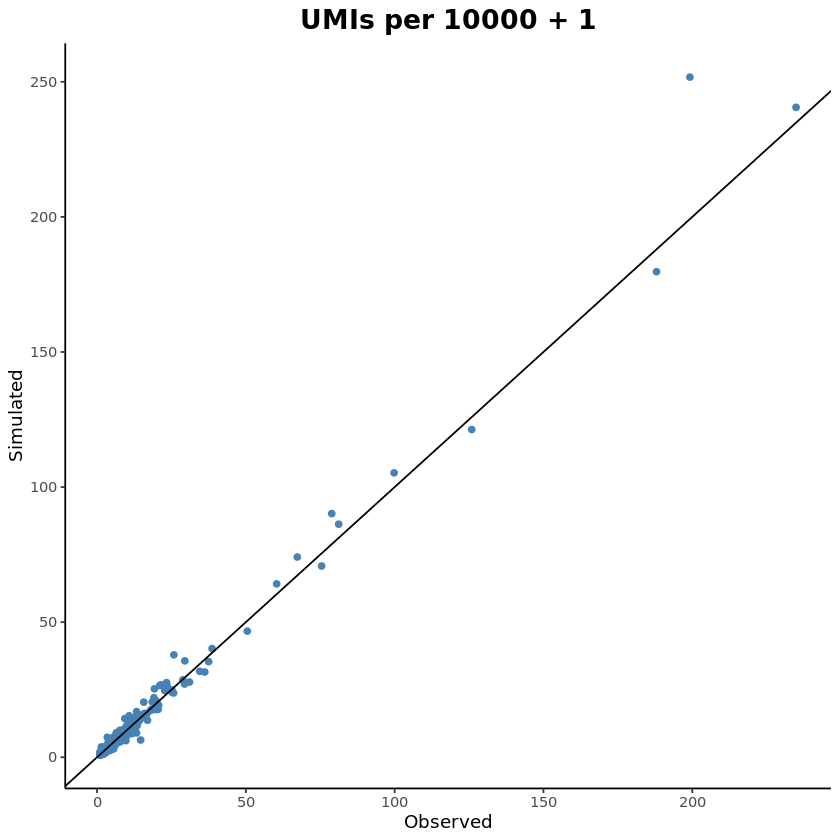

In [342]:
data.frame(x=1 + colMeans(norm_mat), y=1 + colMeans(norm_sim)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    labs(x="Observed", y="Simulated", title = "UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

In [343]:
data.frame(x=colMeans(lognorm_mat), y=colMeans(lognorm_sim)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    labs(x="Observed", y="Simulated", title = "Log UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'colMeans': object 'lognorm_mat' not found


In [353]:
data.frame(x=colMeans(norm_mat), y=colMeans(norm_sim)) %>% lm(formula = x~y) %>% summary


Call:
lm(formula = x ~ y, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.846  -0.117  -0.034   0.071  20.148 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.065280   0.005801   11.25   <2e-16 ***
y           0.933238   0.001170  797.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5751 on 10225 degrees of freedom
Multiple R-squared:  0.9842,	Adjusted R-squared:  0.9842 
F-statistic: 6.363e+05 on 1 and 10225 DF,  p-value: < 2.2e-16


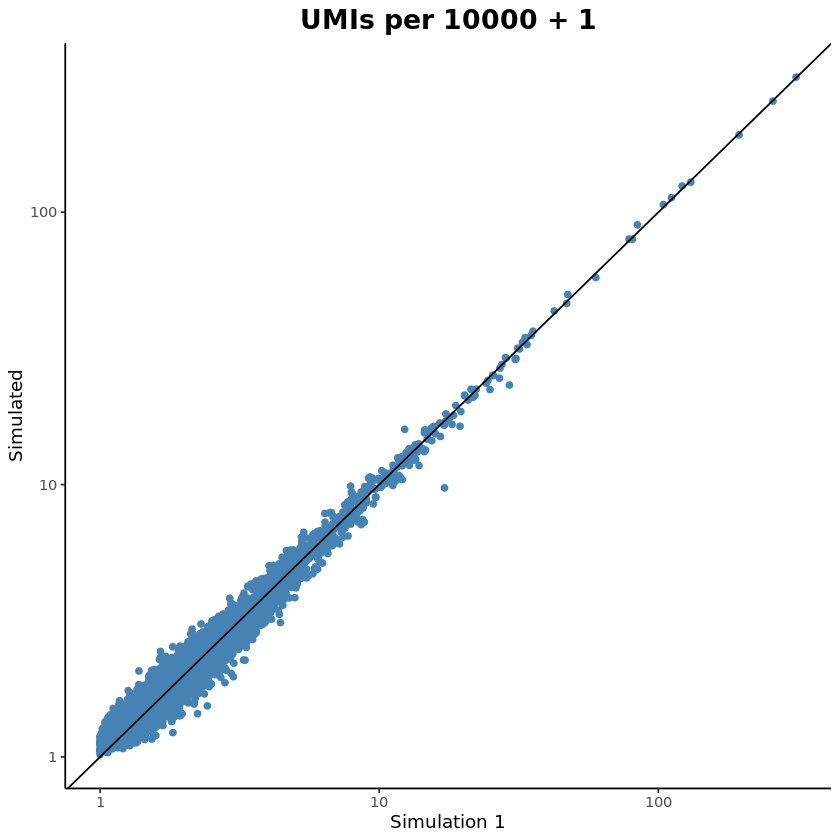

In [271]:
data.frame(x=1 + colMeans(norm_sim1), y=1 + colMeans(norm_sim)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    scale_x_log10(labels=scales::number) +
    scale_y_log10(labels=scales::number) +
    labs(x="Simulation 1", y="Simulated", title = "UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

In [272]:
data.frame(x=1 + colMeans(norm_sim1), y=1 + colMeans(norm_sim)) %>% lm(formula = x~y) %>% summary


Call:
lm(formula = x ~ y, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5682 -0.1606 -0.0123  0.1453  7.4283 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 0.0068636  0.0054621    1.257    0.209    
y           0.9977256  0.0006406 1557.452   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3596 on 4954 degrees of freedom
Multiple R-squared:  0.998,	Adjusted R-squared:  0.998 
F-statistic: 2.426e+06 on 1 and 4954 DF,  p-value: < 2.2e-16


In [274]:
sum((colMeans(norm_mat) - colMeans(norm_sim)) ** 2)

[1] 15892.59

In [275]:
sum((colMeans(norm_sim1) - colMeans(norm_sim)) ** 2)

[1] 642.3823

In [282]:
sum((colMeans(norm_sim2) - colMeans(norm_sim)) ** 2)

[1] 998.7568

In [283]:
sum((colMeans(norm_sim3) - colMeans(norm_sim)) ** 2)

[1] 929.4284

In [70]:
sim_gene_means = sapply(1:1000, function(n){colMeans(norm_sim[grepl(paste0("sim_", n, "$"), rownames(norm_sim)),])}) 

sim_gene_means_alpha1 = sapply(1:50, function(n){colMeans(norm_sim_alpha1[grepl(paste0("sim_", n, "$"), rownames(norm_sim_alpha1)),])}) 

In [41]:
colnames(sim_gene_means) = paste0("Sim", 1:1000)

ERROR: Error in colnames(sim_gene_means) = paste0("Sim", 1:1000): object 'sim_gene_means' not found


In [42]:
z_pvals = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means[gene,]
    z_score = abs(mean(norm_mat[,gene]) - mean(sim_vals)) / sd(sim_vals)
    2 * pnorm(z_score, lower.tail = F)
})

ERROR: Error in FUN(X[[i]], ...): object 'sim_gene_means' not found


In [39]:
new_gene_analysis = function(norm_mat, norm_sim, is_focus, fname, pval_thresh=0.01, lfc_thresh=0.5, per_gene=T){
    focus_norm_mat = norm_mat[is_focus,]
    focus_means = colMeans(focus_norm_mat)

    focus_norm_sim = norm_sim[rep(is_focus, each=1000),]
    sim_means_file = paste0("final_figs/fig4/new_gene/", fname, "_sim_means.csv")
    if (file.exists(sim_means_file)){
        focus_sim_means = as.matrix(read.csv(sim_means_file, row.names = 1))
    } else{
        focus_sim_means = sapply(1:1000, function(n){colMeans(focus_norm_sim[grepl(paste0("sim_", n, "$"), 
                                                                           rownames(focus_norm_sim)),])}) 
        write.csv(focus_sim_means, sim_means_file)
    }
    
    focus_z_pvals = sapply(shared_mat_genes, function(gene){
        sim_vals = focus_sim_means[gene,]
        z_score = abs(focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
        2 * pnorm(z_score, lower.tail = F)
    })
    
    adj_pval = p.adjust(focus_z_pvals %>% replace_na(1), method='fdr')
    focus_sim_meanofmeans = rowMeans(focus_sim_means)
    focus_lfcs = log2((1 + focus_means) / (1 + focus_sim_meanofmeans))
    df = data.frame(Observed_mean = focus_means,
                    Simulated_mean = focus_sim_meanofmeans,
                    adj_pval=adj_pval,
                    lfc=focus_lfcs,
                    label=names(focus_means))
    df$adj_pval = ifelse(df$adj_pval < 1e-5, 1e-5, df$adj_pval)
    write_csv(df, paste0("final_figs/fig4/new_gene/", fname, "_data.csv"))
    plot_scatter(df, thresh = pval_thresh, 
                 fname=paste0("final_figs/fig4/new_gene/", fname, "_scatter.png"))
    plot_volcano(df, pval_thresh = pval_thresh, lfc_thresh = lfc_thresh,
                 fname=paste0("final_figs/fig4/new_gene/", fname, "_volcano.png"))
    if (per_gene){
        sig_genes = names(which(focus_z_pvals < pval_thresh))
        for (gene in sig_genes){
            gene = unlist(str_split(gene, "\\."))[1]
            message(paste0("    ", gene))
            per_gene_plots(gene, fname, focus_sim_means, focus_norm_sim, focus_norm_mat)
        }
    }
}

In [ ]:
for (neutrophil in c('Recruiters', 'Mature', 'TAN1', 'TAN2', 'All')){
    message(neutrophil)
    if (neutrophil == "All"){
        is_focus = T
    } else {
        is_focus = parser_immune[analyzed_pics] == neutrophil
    }
    new_gene_analysis(norm_mat, norm_sim, is_focus, neutrophil, pval_thresh=0.01, lfc_thresh=0.5, per_gene=T)
}   

Recruiters

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    A2m

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    AI662270

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Aars

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in im

Saving 6.67 x 6.67 in image
    Alkbh2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Alox5ap

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ambp

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Anapc4

Saving 6.67 x 6.67 in 

Saving 6.67 x 6.67 in image
    Axdnd1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    B2m

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    B4galt5

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    BC024063

Saving 6.67 x 6.67 in

Saving 6.67 x 6.67 in image
    Camp

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Carmil2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cartpt

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Casp1

Saving 6.67 x 6.67 in i

Saving 6.67 x 6.67 in image
    Cdc14a

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cdc42ep2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cdc5l

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cdh5

Saving 6.67 x 6.67 in 

Saving 6.67 x 6.67 in image
    Col5a2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Comt

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Coq6

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cox10

Saving 6.67 x 6.67 in imag

Saving 6.67 x 6.67 in image
    Ctss

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cttnbp2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cul7

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cwc22

Saving 6.67 x 6.67 in ima

Saving 6.67 x 6.67 in image
    Dnaaf10

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Dnajc19-ps

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Dpcd

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Dpp10

Saving 6.67 x 6.67 

Saving 6.67 x 6.67 in image
    Eno1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Entpd1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Eps8

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ercc1

Saving 6.67 x 6.67 in imag

Saving 6.67 x 6.67 in image
    Fgd3

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Fhip1b

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Fhip2a

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Fkbp10

Saving 6.67 x 6.67 in i

Saving 6.67 x 6.67 in image
    Ggt5

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Gimap4

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Gimap6

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Gja1

Saving 6.67 x 6.67 in ima

Saving 6.67 x 6.67 in image
    Hagh

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Hcst

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Hilpda

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Hinfp

Saving 6.67 x 6.67 in imag

Saving 6.67 x 6.67 in image
    Il2rg

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ing3

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Inpp5j

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ints11

Saving 6.67 x 6.67 in im

Saving 6.67 x 6.67 in image
    Ksr1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Lad1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Lalba

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Lamb3

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image
    Ly6g

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Lypd6b

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Lyz1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Lyz2

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image
    Mrgpra2a

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Mrpl33

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Mrpl40

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ms4a4c

Saving 6.67 x 6.67 

Saving 6.67 x 6.67 in image
    Ngp

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Nme5

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Notch2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Npl

Saving 6.67 x 6.67 in image
W

Saving 6.67 x 6.67 in image
    Pcgf5

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Pcnt

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Pcyt1a

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Phaf1

Saving 6.67 x 6.67 in ima

Saving 6.67 x 6.67 in image
    Poc1b

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Polg

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Polr2a

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Polr2b

Saving 6.67 x 6.67 in im

Saving 6.67 x 6.67 in image
    Retn

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Retnlg

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Rfx2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Rgs18

Saving 6.67 x 6.67 in imag

Saving 6.67 x 6.67 in image
    Scimp

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Sco1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Sell

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Sema3f

Saving 6.67 x 6.67 in imag

Saving 6.67 x 6.67 in image
    Slc9a8

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Slf2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Slfn2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Slfn4

Saving 6.67 x 6.67 in ima

Saving 6.67 x 6.67 in image
    Stat4

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Stbd1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Stfa2l1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Stfa3

Saving 6.67 x 6.67 in i

Saving 6.67 x 6.67 in image
    Tmem143

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Tmem177

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Tmem203

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Tmem254

Saving 6.67 x 6.6

Saving 6.67 x 6.67 in image
    Trip4

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Trpv2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Tsc1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Tsen54

Saving 6.67 x 6.67 in ima

Saving 6.67 x 6.67 in image
    Xpo6

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Yrdc

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Zbtb11

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Zbtb14

Saving 6.67 x 6.67 in ima

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Actr3-ps

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Adpgk

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Adrm1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Atp5o

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Atpaf1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Aup1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geo

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Btla

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    C1qtnf9

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cactin

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`g

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cdkn2aip

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cecr2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Celsr1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Csf2rb

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Csn3

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Cspp1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geo

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Donson

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Dubr

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Dvl1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Fcgr4

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Fchsd1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Fcrla

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`ge

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Gnb1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Gng11

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Gpr137

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geo

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ifitm6

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ift80

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Igfbp5

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`g

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ldlrad3

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Lepr

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Lhx1os

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`g

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Mcl1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Med12

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Med20

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Naa20

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Narf

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ndrg1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Olfr369-ps1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Osbpl11

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Osbpl8

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing val

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Pom121

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ppfia4

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ppp1r10

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Ranbp2

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Rasl12

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Rbm38

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`g

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    S1pr4

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Sacm1l

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Sbf1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geo

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Slc35f3

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Slc36a3

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Slc38a7

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 ro

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Steap4

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Stfa1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Stfa2l1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows 

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Tns1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Tor3a

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Tpi1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows conta

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Wdr53

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Wdyhv1

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
    Wfdc12

Saving 6.67 x 6.67 in image
Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows c

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Saving 6.67 x 6.67 in image
TAN1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [98]:
    is_focus = parser_immune[analyzed_pics] == neutrophil
    focus_norm_sim = norm_sim[rep(is_focus, each=1000),]
    focus_sim_means = sapply(1:1000, function(n){colMeans(focus_norm_sim[grepl(paste0("sim_", n, "$"), 
                                                                               rownames(focus_norm_sim)),])}) 
    focus_means = colMeans(norm_mat[is_focus,])
    focus_genes = shared_mat_genes[focus_means[shared_mat_genes] > 0]
    focus_means = focus_means[focus_genes]
    focus_z_pvals = sapply(focus_genes, function(gene){
        sim_vals = focus_sim_means[gene,]
        z_score = abs(focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
        2 * pnorm(z_score, lower.tail = F)
    })
    focus_sim_meanofmeans = rowMeans(focus_sim_means)[focus_genes]
    focus_lfcs = log2((0.1 + focus_means) / (0.1 + focus_sim_meanofmeans))
    df = data.frame(Observed_mean = focus_means,
                    Simulated_mean = focus_sim_meanofmeans,
                    adj_pvals=p.adjust(focus_z_pvals, method='fdr'),
                    lfc=focus_lfcs)


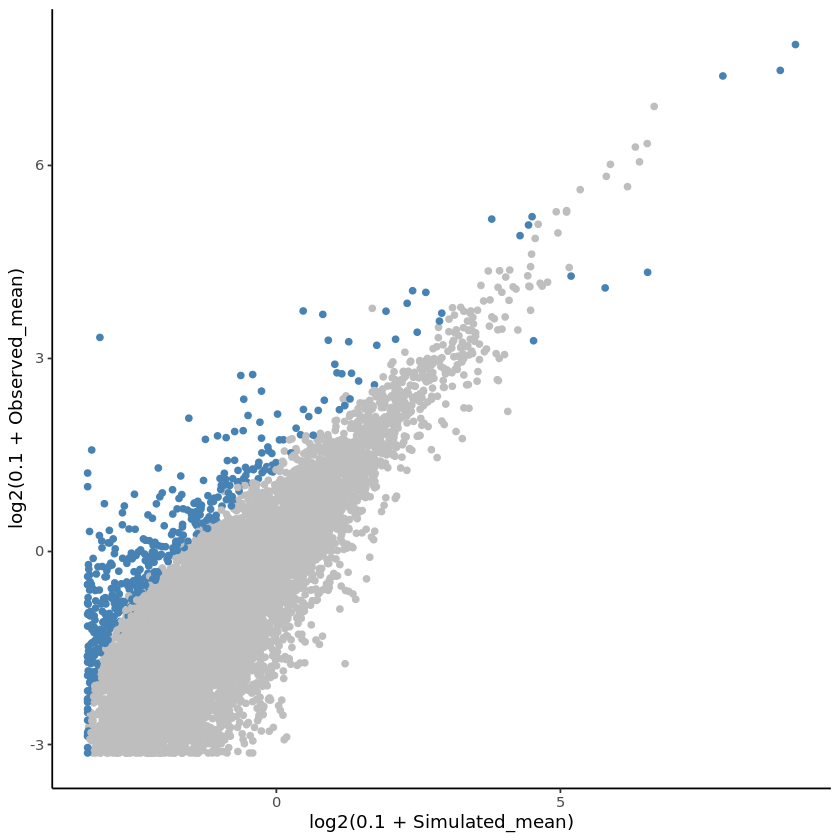

In [101]:
plot_scatter("", df)

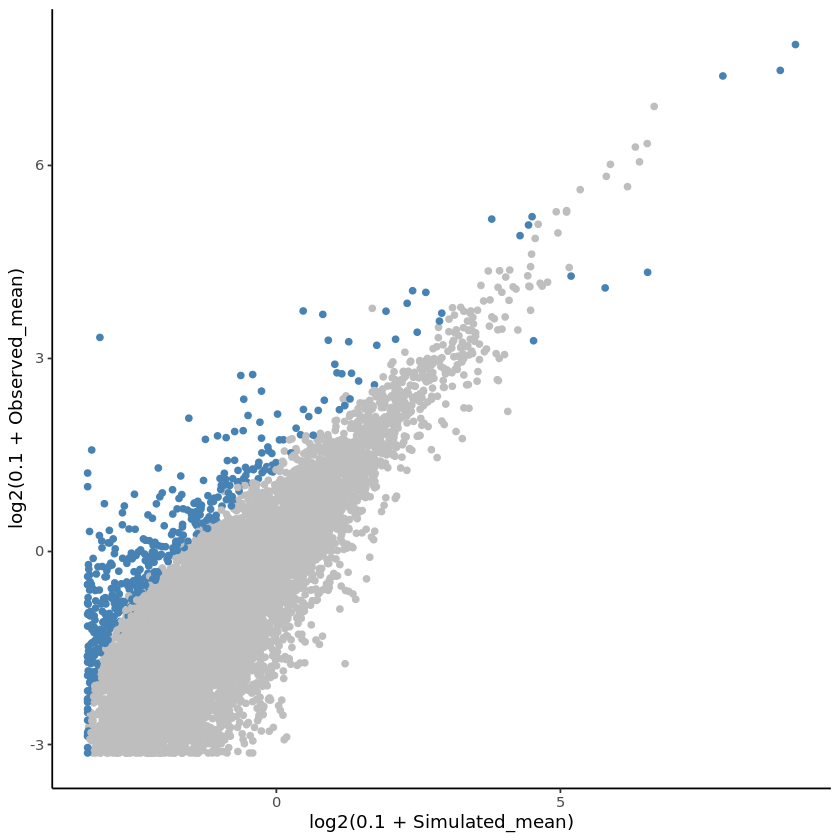

In [101]:
plot_scatter("", df)

In [75]:
neutrophil = "TAN2"

In [78]:
is_focus = parser_immune[analyzed_pics] == neutrophil
focus_norm_sim = norm_sim[rep(is_focus, each=1000),]
focus_sim_means = sapply(1:1000, function(n){colMeans(focus_norm_sim[grepl(paste0("sim_", n, "$"), 
                                                                           rownames(focus_norm_sim)),])}) 
focus_means = colMeans(norm_mat[is_focus,])
focus_z_pvals = sapply(shared_mat_genes[focus_means[shared_mat_genes] > 0], function(gene){
    sim_vals = focus_sim_means[gene,]
    z_score = (focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'X' in selecting a method for function 'sapply': incorrect number of dimensions


In [84]:
focus_z_pvals = sapply(shared_mat_genes[focus_means[shared_mat_genes] > 0], function(gene){
    sim_vals = focus_sim_means[gene,]
    z_score = (focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})


In [86]:
0.05 / 4

[1] 0.0125

In [87]:
sum(p.adjust(focus_z_pvals, method='fdr') < 0.01)

[1] 487

In [471]:
z_pvals = sapply(shared_mat_genes, function(gene){
    sim_vals = focus_sim_means[gene,]
    z_score = (focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

ERROR: Error in FUN(X[[i]], ...): object 'focus_sim_means' not found


In [535]:
double_names = str_split(names(z_pvals), '\\.') %>% unlist
names(z_pvals) = double_names[seq(1, length(double_names), 2)]

In [412]:
cat(names(which(p.adjust(z_pvals, method='fdr') < 0.05)), sep="\n")

In [73]:
sum(p.adjust(z_pvals %>% replace_na(1), method='fdr') < 0.05)

[1] 412

In [74]:
cat(names(which(p.adjust(z_pvals, method='fdr') < 0.05)), sep="\n")

A2m
AI506816
Abcc9
Abtb1
Acap1
Acod1
Acox3
Adcy4
Adgrf5
Ago2
Agr2
Ahr
Aif1
Ak4
Akap13
Anp32b-ps1
Anxa3
Ap1m1
Apaf1
Apoe
Arc
Arglu1
Arhgef1
Arhgef3
Arid1b
Arih1
Arih2
Arl4d
Arl5b
Armc5
Atf6
Atg2b
Atp10b
Axdnd1
B2m
BC024063
Bcl2a1a
Bgn
Blm
Bnip3
Bsdc1
Bst2
Btbd19
Btbd7
Btk
Btla
C1qtnf9
Cabyr
Cactin
Capn2
Carmil2
Cav1
Cavin2
Ccdc102a
Ccdc28b
Ccdc88b
Ccdc9
Ccl3
Ccl5
Ccl8
Ccl9
Ccnj
Cd101
Cd14
Cd177
Cd300lf
Cd300lg
Cd48
Cd74
Cd84
Cdh5
Cdk12
Cep55
Chst15
Cilp
Ckap2
Clcn2
Clec14a
Clec4a1
Clec4a3
Clec4n
Cltc
Cmpk2
Cmtm3
Col12a1
Col15a1
Col1a1
Col4a2
Comt
Creb5
Crebrf
Cryab
Csf2rb
Csf2rb2
Cst3
Ctbs
Ctla2a
Ctsb
Ctsk
Ctss
Cttnbp2
Cxcl12
Cybb
Cyth1
Dapk3
Ddit4
Ddx21
Ddx58
Dennd4c
Depp1
Dgkh
Dhx58
Dlgap1
Dmkn
Dnal1
Dusp1
Dynlt1a
Eef1a1
Egfl7
Eif3a
Eif4ebp2
Eif5
Elf4
Emp1
Epas1
Eps8
Esm1
Exoc1
Exoc6b
F2r
Fabp4
Fabp5
Fam118a
Fastkd3
Fbxl5
Fcgbp
Fcgr1
Fcgr2b
Fcho2
Fcrla
Fgd3
Flt1
Flt3l
Fn1
Fntb
Foxk2
Ftl1
Fus
Fxyd2
Fzd4
Gadd45b
Gapdh
Gapdh-ps16
Gbp9
Gimap6
Gja1
Glycam1
Gna13
Gng11
Golm1
Gpi1
Gpr146
Gpr

In [476]:
sig_genes = names(which(p.adjust(z_pvals, method='fdr') < 0.05))

In [397]:
gene_sizes = rowSums(pic_umis)

In [ ]:
1

In [453]:
z_pvals = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means_firsthalf[gene,]
    z_score = (mean(norm_mat[,gene]) - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

In [454]:
z_pvals_sim1 = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means_firsthalf[gene,]
    z_score = (mean(norm_sim1[,gene]) - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

In [455]:
z_pvals_sim2 = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means_firsthalf[gene,]
    z_score = (mean(norm_sim2[,gene]) - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

In [456]:
z_pvals_sim3 = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means_firsthalf[gene,]
    z_score = (mean(norm_sim3[,gene]) - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

In [457]:
message("Sim1: ", length(names(which(p.adjust(z_pvals_sim1, method='fdr') < 0.05))))
message("Sim2: ", length(names(which(p.adjust(z_pvals_sim2, method='fdr') < 0.05))))
message("Sim3: ", length(names(which(p.adjust(z_pvals_sim3, method='fdr') < 0.05))))
message("Observed: ", length(names(which(p.adjust(z_pvals, method='fdr') < 0.05))))

Sim1: 99

Sim2: 70

Sim3: 30

Observed: 405



In [458]:
z_pvals = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means_secondhalf[gene,]
    z_score = (mean(norm_mat[,gene]) - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

In [459]:
z_pvals_sim1 = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means_secondhalf[gene,]
    z_score = (mean(norm_sim1[,gene]) - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

In [460]:
z_pvals_sim2 = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means_secondhalf[gene,]
    z_score = (mean(norm_sim2[,gene]) - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

In [461]:
z_pvals_sim3 = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means_secondhalf[gene,]
    z_score = (mean(norm_sim3[,gene]) - mean(sim_vals)) / sd(sim_vals)
    pnorm(z_score, lower.tail = F)
})

In [470]:
message("Sim1: ", length(names(which(p.adjust(z_pvals_sim1, method='fdr') < 0.05))))
message("Sim2: ", length(names(which(p.adjust(z_pvals_sim2, method='fdr') < 0.05))))
message("Sim3: ", length(names(which(p.adjust(z_pvals_sim3, method='fdr') < 0.05))))
message("Observed: ", length(names(which(p.adjust(z_pvals, method='fdr') < 0.05))))

Sim1: 99

Sim2: 70

Sim3: 30

Observed: 405



In [447]:
mean(norm_mat[,'Cxcl2'])

[1] 27.22509

In [452]:
zsig = names(which(p.adjust(z_pvals, method='fdr') < 0.05))

In [453]:
simple_pvals = sapply(shared_mat_genes, function(gene){
    sim_vals = sim_gene_means[gene,]
    sum(mean(norm_mat[,gene]) < sim_vals) / length(sim_vals) 
})

In [454]:
sum(p.adjust(simple_pvals + 1e-6, method='fdr') < 0.05)

[1] 123

In [455]:
simplesig = names(which(p.adjust(simple_pvals + 1e-6, method='fdr') < 0.05))

In [456]:
length(simplesig)

[1] 123

In [457]:
length(intersect(simplesig, zsig))

[1] 123

In [458]:
sum(simple_pvals == 0)

[1] 123

In [459]:
zsig

[1] "A2m"      "Abcg1"    "Abracl"   "Abtb1"    "Acap1"    "Acod1"   
  [7] "Acox3"    "Acsf2"    "Acsf3"    "Adamtsl4" "Adm"      "Ago2"    
 [13] "Ahr"      "Aif1"     "Akap13"   "Akr1b8"   "Aldoa"    "Ap4e1"   
 [19] "Aph1b"    "Aph1c"    "Apoe"     "Arc"      "Arhgef1"  "Arid1b"  
 [25] "Arih2"    "Arl5b"    "Armc5"    "Asb6"     "Atg2b"    "Atp5g2"  
 [31] "B4galnt1" "BC024063" "Babam2"   "Bahd1"    "Bgn"      "Bivm"    
 [37] "Blm"      "Bnip3"    "Borcs5"   "Bsdc1"    "Bst2"     "Btbd19"  
 [43] "Btbd7"    "Btk"      "Btla"     "C1qc"     "C2cd3"    "Cartpt"  
 [49] "Cav1"     "Ccdc102a" "Ccdc28b"  "Ccdc88b"  "Ccdc9"    "Ccl5"    
 [55] "Ccl8"     "Cd101"    "Cd247"    "Cd300lf"  "Cd48"     "Cd84"    
 [61] "Cdc23"    "Cdc42ep2" "Cdk12"    "Cdkn2b"   "Cenpu"    "Cep55"   
 [67] "Cfap97"   "Chek1"    "Chst15"   "Cisd3"    "Clcn2"    "Clec3b"  
 [73] "Clec4a3"  "Clec4n"   "Clip1"    "Clpb"     "Cndp2"    "Col12a1" 
 [79] "Col4a2"   "Comt"     "Coro6"    "Csf2rb"   "Csf2rb2"  "Cttnbp2" 
 [85] "Cxcl11"   "Cxcl9"    "Cysltr1"  "Cyth1"    "Dapk3"    "Dclre1c" 
 [91] "Dcpp1"    "Dcpp2"    "Ddit4"    "Dennd4c"  "Depp1"    "Dglucy"  
 [97] "Dhx9"     "Dnajb14"  "Eea1"     "Eef1a1"   "Eif3a"    "Eif4ebp2"
[103] "Eif5"     "Epas1"    "Eps8"     "Esm1"     "Exoc6b"   "F2r"     
[109] "Fabp4"    "Fabp5"    "Fam118a"  "Fam168a"  "Fastkd3"  "Fbxl15"  
[115] "Fbxl5"    "Flt1"     "Flt3l"    "Fn1"      "Foxk2"    "Gabpb2"  
[121] "Gadd45b"  "Gapdh"    "Ggt6"     "Gimap6"   "Glycam1"  "Gna13"   
[127] "Gng11"    "Golm1"    "Gpr146"   "Grap2"    "Gsn"      "Gtdc1"   
[133] "H19"      "H2-M2"    "H2-Ob"    "H2-Q4"    "H2-T10"   "Habp4"   
[139] "Hdac10"   "Hmga1b"   "Hsf2bp"   "Htatip2"  "Ier2"     "Ifi204"  
[145] "Ifrd2"    "Ift80"    "Il2rg"    "Ino80e"   "Invs"     "Isg20"   
[151] "Jag1"     "Jcad"     "Kansl1l"  "Kcnk4"    "Kctd11"   "Kctd17"  
[157] "Kctd20"   "Kin"      "Klf10"    "Klhl3"    "Lhx1os"   "Lilrb4b" 
[163] "Lonrf3"   "Loxl1"    "Lrch3"    "Lrrn2"    "Ltc4s"    "Ly86"    
[169] "Lyz1"     "Macrod2"  "Maff"     "Man2c1"   "Marf1"    "Mars2"   
[175] "Mbnl2"    "Mcmbp"    "Mctp2"    "Mettl5"   "Mettl7a1" "Mfap5"   
[181] "Mmp12"    "Mnt"      "Mpeg1"    "Mrpl40"   "Ms4a4c"   "Ms4a6b"  
[187] "Msr1"     "Mthfsl"   "Mtif2"    "Mtor"     "Mup5"     "Myo5a"   
[193] "Nadk2"    "Ncoa3"    "Ndrg1"    "Nek1"     "Nemp1"    "Nemp2"   
[199] "Nfatc4"   "Nfkbia"   "Nfrkb"    "Noc2l"    "Nr1d1"    "Nradd"   
[205] "Nrros"    "Nt5dc1"   "Ntrk2"    "Nup153"   "Nup88"    "Olfr1062"
[211] "Orc5"     "Pacsin1"  "Pak2"     "Pbld2"    "Pcdhb22"  "Pcyt1a"  
[217] "Pde8a"    "Pdlim2"   "Pex13"    "Phaf1"    "Phtf1"    "Picalm"  
[223] "Pip"      "Pitpnc1"  "Pitpnm2"  "Pkn3"     "Pla2g15"  "Platr4"  
[229] "Pnoc"     "Pnp"      "Pofut2"   "Pold3"    "Poldip3"  "Polr2c"  
[235] "Ppp1r1b"  "Praf2"    "Prg4"     "Prh1"     "Prkd2"    "Psip1"   
[241] "Ptgir"    "Ptprz1"   "Qpctl"    "Rab5if"   "Rasa4"    "Rbm27"   
[247] "Retn"     "Retreg3"  "Riiad1"   "Rlf"      "Rn7sk"    "Rnf207"  
[253] "Rnf25"    "Rnf32"    "Rnf8"     "Rock2"    "Rpgrip1l" "Rsad2"   
[259] "Rsbn1"    "Rsf1"     "Rtn2"     "S100pbp"  "Sacm1l"   "Sbno2"   
[265] "Scgb1b27" "Scgb2b26" "Scn1b"    "Sema3c"   "Sema3f"   "Senp5"   
[271] "Serpind1" "Sestd1"   "Sh2d4b"   "Simc1"    "Six1"     "Slc25a1" 
[277] "Slc25a27" "Slc36a1"  "Slfn4"    "Slfn5"    "Slu7"     "Smg9"    
[283] "Smr2"     "Sned1"    "Sorbs1"   "Sox14"    "Spn"      "Sptan1"  
[289] "Srek1"    "Ssbp2"    "St7l"     "Stard9"   "Swap70"   "Syde1"   
[295] "Synrg"    "Tagap"    "Taok1"    "Tbk1"     "Tcf12"    "Tcf7"    
[301] "Tiam2"    "Timm8a1"  "Tjap1"    "Tlr13"    "Tmem117"  "Tmem143" 
[307] "Tmem191c" "Tmem252"  "Tmem254"  "Tnfrsf26" "Tnfsf10"  "Tnip1"   
[313] "Tpp1"     "Trac"     "Traf3ip3" "Trip6"    "Trmt13"   "Trpm3"   
[319] "Trpv2"    "Trub2"    "Tsen54"   "Ttll3"    "Tusc2"    "Ubb"     
[325] "Ube2cbp"  "Ube2i"    "Ube2s"    "Ube3b"    "Urm1"     "Ushbp1"  
[331] "Usp18"    "Usp39"    "Vegfb"    "Vi

In [54]:
gene = "Vegfb"
plot_df = data.frame(mean_norm_expr=c(sim_gene_means[gene,], mean(norm_mat[,gene])),
                     source=c(rep("Simulated", 1000), "Observed"))

ERROR: Error in data.frame(mean_norm_expr = c(sim_gene_means[gene, ], mean(norm_mat[, : object 'sim_gene_means' not found


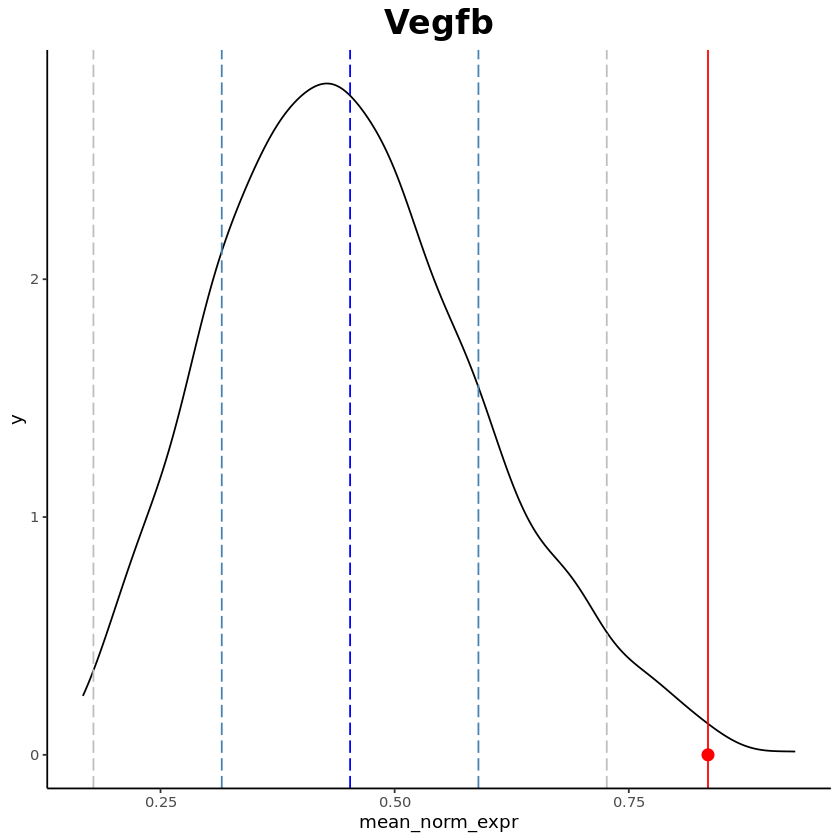

In [466]:
gene_mean = mean(plot_df[plot_df$source == "Simulated","mean_norm_expr"])
gene_sd = sd(plot_df[plot_df$source == "Simulated","mean_norm_expr"])
ggplot(plot_df, aes(x=mean_norm_expr)) +
    #geom_histogram(aes(y=after_stat(density)), alpha=0.5, position="identity")+
    geom_density(data=plot_df[plot_df$source == "Simulated",]) +
    geom_vline(xintercept = gene_mean, color='blue', linetype='longdash') +
    #ggtext::geom_richtext(x = gene_mean, y=1, color='blue', label='sim mean', angle=90) +
    geom_vline(xintercept = c(gene_mean + gene_sd, gene_mean - gene_sd), color='steelblue', linetype='longdash') +
    #ggtext::geom_richtext(x = gene_mean + gene_sd, y=1, color='steelblue', label='sim mean + sd', angle=90) +
    #ggtext::geom_richtext(x = gene_mean - gene_sd, y=1, color='steelblue', label='sim mean - sd', angle=90) +
    geom_vline(xintercept = c(gene_mean + (2 * gene_sd), gene_mean - (2 * gene_sd)), color='gray', linetype='longdash') +
    #ggtext::geom_richtext(x = gene_mean + (2 * gene_sd), y=1, color='gray', label='sim mean + 2sd', angle=90) +
    #ggtext::geom_richtext(x = gene_mean - (2 * gene_sd), y=1, color='gray', label='sim mean - 2sd', angle=90) +
    geom_vline(xintercept = plot_df[plot_df$source == "Observed","mean_norm_expr"], color='red') +
    geom_point(data=plot_df[plot_df$source == "Observed",], aes(y=0), color='red', size=3) +
    #ggtext::geom_richtext(x=plot_df[plot_df$source == "Observed","mean_norm_expr"], y=1, color='red', label='obs', angle=90) +
    labs(title=gene) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'))

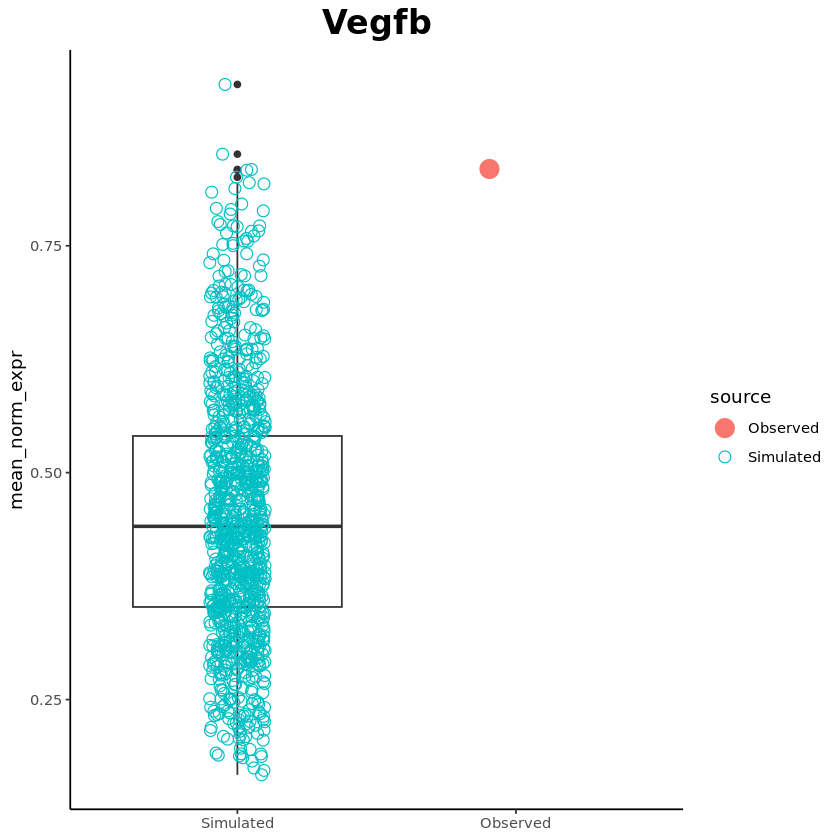

In [468]:
ggplot(plot_df, aes(x=source, y=mean_norm_expr)) +
    geom_boxplot(data=. %>% filter(source == "Simulated")) +
    geom_jitter(width=0.1, aes(color=source, shape=source, size=source)) +
    scale_shape_manual(values = c(19, 1)) +
    scale_size_manual(values = c(5, 3)) +
    labs(title=gene) +
    scale_x_discrete(limits=c("Simulated", "Observed")) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'), axis.title.x = element_blank())

Warning message in stat_summary(fungeom = "errorbar", width = 0.5, color = "red", :
“Ignoring unknown parameters: `fungeom` and `width`”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


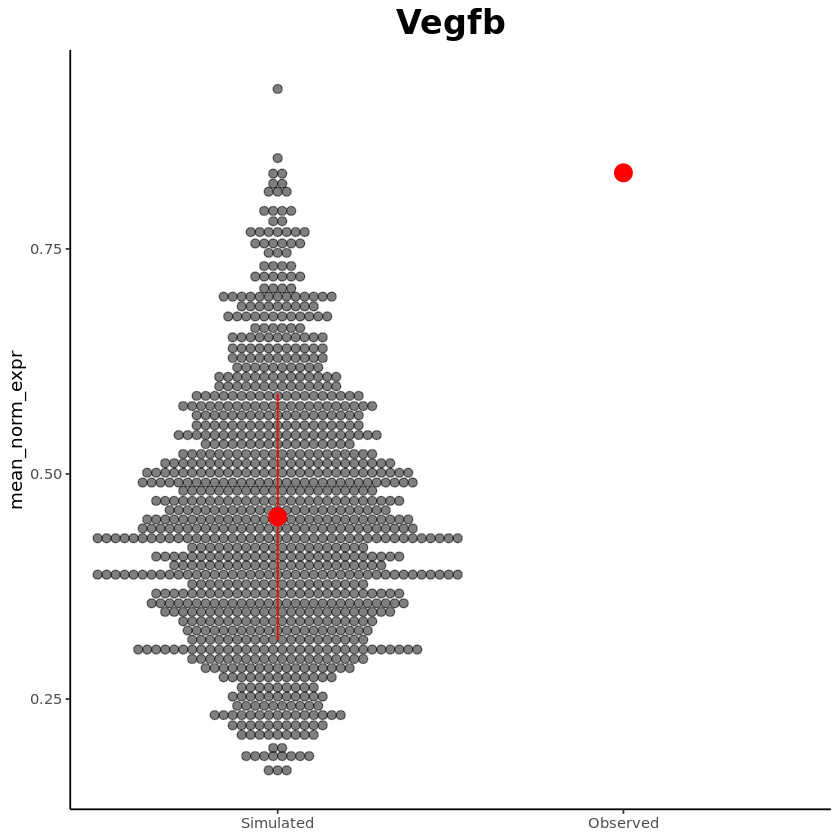

In [469]:
ggplot(plot_df, aes(x=source, y=mean_norm_expr)) +
    geom_dotplot(binaxis='y', stackdir='center', binwidth = 0.01, alpha=0.5) +
    stat_summary(fungeom="errorbar", width=0.5, color='red', size=1, fun.data = mean_sdl, fun.args = list(mult=1)) +
    scale_shape_manual(values = c(4, 1)) +
    labs(title=gene) +
    scale_x_discrete(limits=c("Simulated", "Observed")) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'), axis.title.x = element_blank())

In [387]:
p.adjust(z_pvals, method='fdr')[gene]

Vegfb 
0.001353688

In [2372]:
norm_sim_epi = rep(mle_res[focus_pics,'alpha'], each=50) * 10000 * t(simpics_epi) / colSums(simpics_epi)
norm_sim_imm = (1 - rep(mle_res[focus_pics,'alpha'], each=50)) * 10000 * t(simpics_imm) / colSums(simpics_imm)

In [2382]:
epi_means = colMeans(norm_sim_epi)
imm_means = colMeans(norm_sim_imm)
obs_means = colMeans(norm_sim)

In [2386]:
gene = "Csf1"

In [2387]:
bar_df = data.frame(source=factor(c(rep("Simulated", 2), "Observed"), levels=c("Simulated", "Observed")),
                    cell=c("Epithelial", "Neutrophil", "PIC"),
                    expression=c(epi_means[gene], imm_means[gene], obs_means[gene]))

ggplot(bar_df, aes(x=source, y=expression, fill=cell)) +
    geom_bar(stat = 'identity', position = 'stack', color='black') +
    labs(title=gene) +
    theme(plot.title = element_text(hjust=0.5, size=16, face='bold'))

In [2344]:
any(abs(rowMeans(simpics_epi) + rowMeans(simpics_imm) - rowMeans(simpics)) > 1e-10)

[1] FALSE

In [397]:
volcano_df = data.frame(lfc = log2((0.1 + colMeans(norm_mat)) / (0.1 + colMeans(norm_sim)))[names(z_pvals)],
                        adj_pval=p.adjust(z_pvals, method='fdr')) %>% 
    rownames_to_column('gene_name') %>%
    mutate(highlighted=abs(lfc) > 0.5 & adj_pval < 0.01, adj_pval=ifelse(adj_pval < 1e-5, 1e-5, adj_pval)) %>%
    mutate(label=ifelse(highlighted, gene_name, ""), color=ifelse(highlighted, "red", "gray50"))

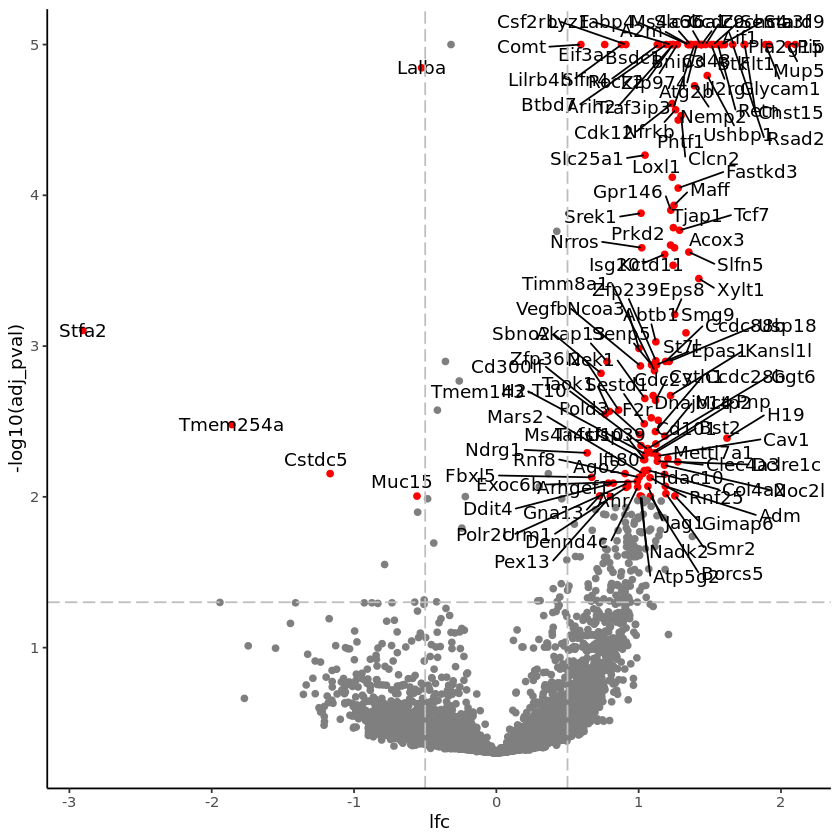

In [398]:
ggplot(volcano_df, aes(x=lfc, y=-log10(adj_pval), color=color, label=label)) +
    geom_point(show.legend=F) +
    geom_text_repel(max.overlaps = 1000, color='black') +
    scale_color_identity() +
    geom_hline(yintercept = -log10(0.05), linetype='longdash', color='gray') +
    geom_vline(xintercept = c(-0.5, 0.5), linetype='longdash', color='gray')

In [279]:
epithelial_mat = t(sc_mat@mat[shared_mat_genes,epithelial_cells])
norm_epithelial_mat = 10000 * epithelial_mat / rowSums(epithelial_mat)

In [280]:
immune_mat = t(sc_mat@mat[shared_mat_genes,immune_cells])
norm_immune_mat = 10000 * immune_mat / rowSums(immune_mat)

In [281]:
lfc = log2((1 + colMeans(norm_mat)) / (1 + colMeans(norm_sim)))

In [282]:
immune_lfc = log10((1 + colMeans(norm_immune_mat)) / (1 + colMeans(norm_epithelial_mat)))

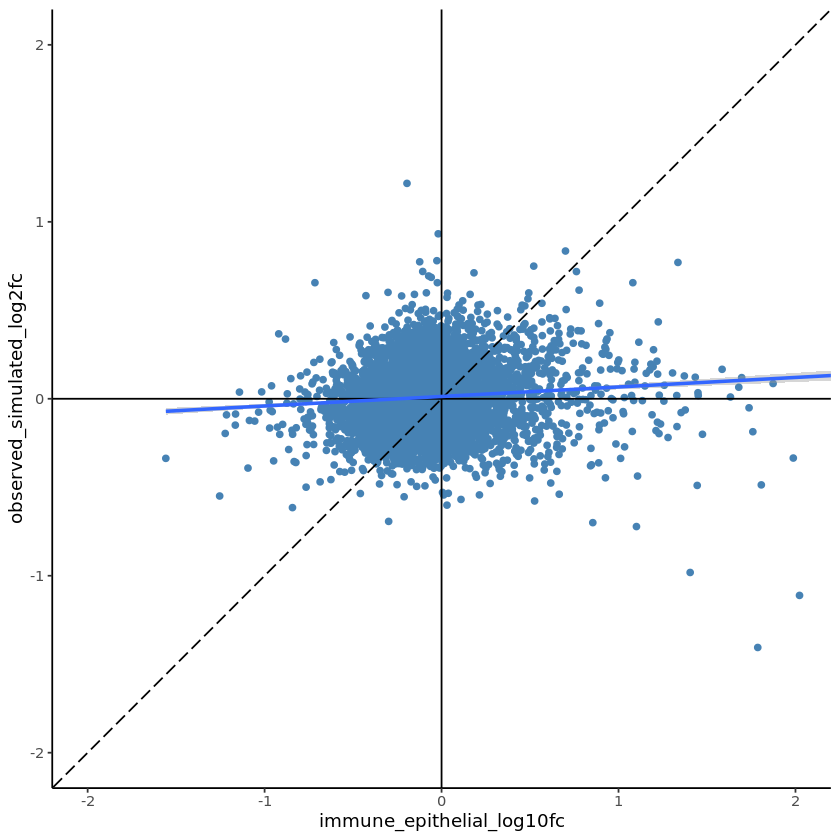

In [283]:
data.frame(immune_epithelial_log10fc=immune_lfc,
           observed_simulated_log2fc=lfc) %>%
    ggplot(aes(x=immune_epithelial_log10fc, y=observed_simulated_log2fc)) +
    geom_point(color='steelblue') +
    geom_abline(intercept = 0, slope=1, linetype='longdash') +
    geom_vline(xintercept = 0) +
    geom_hline(yintercept = 0) +
    geom_smooth(method = 'lm', formula = y ~ x) +
    coord_fixed(xlim = c(-2, 2), ylim=c(-2, 2))

In [284]:
data.frame(x=immune_lfc, y=lfc) %>% lm(formula = x~y) %>% summary


Call:
lm(formula = x ~ y, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.44277 -0.10188 -0.01123  0.05814  2.93630 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.072144   0.002357 -30.613   <2e-16 ***
y            0.128538   0.015243   8.432   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2379 on 10225 degrees of freedom
Multiple R-squared:  0.006906,	Adjusted R-squared:  0.006809 
F-statistic:  71.1 on 1 and 10225 DF,  p-value: < 2.2e-16


### Per replicate attempts

In [2267]:
pr_means = norm_mat %>% 
    as.data.frame %>% 
    cbind(age_replicate = interaction(as.character(db_mat@cell_metadata[focus_pics,'Age']), 
                                      as.character(db_mat@cell_metadata[focus_pics,'Replicate']))) %>%
    group_by(age_replicate) %>%
    summarise_all(mean) %>%
    cbind(source="Observed")

In [2269]:
pr_sim_means = norm_sim %>% 
    as.data.frame %>% 
    cbind(age_replicate = rep(interaction(as.character(db_mat@cell_metadata[focus_pics,'Age']), 
                                          as.character(db_mat@cell_metadata[focus_pics,'Replicate'])),
                              each=50), 
          simnum = paste0("sim", str_split_i(rownames(.), "\\_", i = 4))) %>%
    group_by(age_replicate, simnum) %>%
    summarise_all(mean) %>%
    cbind(source="Simulated")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.0 GiB”


In [2272]:
grouped_pr_sim_means = norm_sim %>% 
    as.data.frame %>% 
    cbind(age_replicate = rep(interaction(as.character(db_mat@cell_metadata[focus_pics,'Age']), 
                                          as.character(db_mat@cell_metadata[focus_pics,'Replicate'])),
                              each=50)) %>%
    group_by(age_replicate) %>%
    summarise_all(mean) %>%
    cbind(source="Simulated")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.0 GiB”


In [2278]:
all_means = rbind(pr_sim_means, pr_means) %>% 
    melt(variable.name = 'Gene', value.name = 'mean_norm_UMIs') %>% 
    mutate(source = factor(source, levels=c('Simulated', 'Observed'))) %>%
    group_by(age_replicate, Gene) %>%
    mutate(scaled_mean_norm_UMIs=scale(mean_norm_UMIs))

Using age_replicate, simnum, source as id variables



In [2290]:
paired_t_pvals = sapply(shared_mat_genes[rowSums(pic_umis[shared_mat_genes,]) > 10], function(gene){
    t_res = t.test(pr_means[,gene], grouped_pr_sim_means[,gene], paired=T)
    return(t_res$p.value)
})

In [2302]:
scaled_obs_means = all_means[all_means$source == "Observed",] %>% dcast(age_replicate ~ Gene)

Using scaled_mean_norm_UMIs as value column: use value.var to override.



In [2303]:
scaled_sim_means = all_means[all_means$source == "Simulated",] %>% dcast(age_replicate + simnum ~ Gene)

Using scaled_mean_norm_UMIs as value column: use value.var to override.



In [2304]:
scaled_t_pvals = sapply(shared_mat_genes[rowSums(pic_umis[shared_mat_genes,]) > 10], function(gene){
    t_res = t.test(scaled_obs_means[,gene],scaled_sim_means[,gene])
    return(t_res$p.value)
})

In [1620]:
grouped_means = rbind(grouped_pr_sim_means, pr_means)

In [1633]:
t_pvals = sapply(shared_mat_genes[rowSums(pic_umis[shared_mat_genes,]) > 30], function(gene){
    t_res = t.test(pr_means[,gene], grouped_pr_sim_means[,gene])
    return(t_res$p.value)
})

In [1634]:
t_pvals %>% p.adjust(method='fdr') %>% sort

Elf5       Mtx2      Pfdn1       Glo1    Tomm70a    Ppp2r2d      Pcmt1 
0.02911950 0.02911950 0.02911950 0.03109647 0.04858104 0.11218231 0.11585869 
      Brd1      Cdcp1      Cox6c      Idh3a     Inpp5k     Ndufs4     Ptp4a1 
0.11873521 0.11873521 0.11873521 0.11873521 0.11873521 0.11873521 0.11873521 
     Rab5c       Rxra    Timm17b       Tjp1     Impdh1   Aurkaip1      Cers2 
0.11873521 0.11873521 0.11873521 0.11873521 0.14498585 0.14550391 0.14550391 
    Mrpl30       Vta1      Inhbb       Pop5      Prpf8      Psmg2      Cnih1 
0.14550391 0.14550391 0.14704459 0.14704459 0.14704459 0.14704459 0.14838011 
    Ndufs2       Pck2    Atp6v1h     Borcs7       Bzw2       Ccn2      Eif1b 
0.14838011 0.14838011 0.18457226 0.18457226 0.18457226 0.18457226 0.19227065 
    Bmpr1a      Lalba      Nrbp1    Arl6ip4     Ube2r2     Adam10      Cnot8 
0.19309600 0.20525015 0.20531686 0.20789288 0.20789288 0.22114413 0.22139580 
     Dcakd      Plpp2      Atp5e       Ddb1       Hadh     Mrpl11     Mrpl57 
0.22139580 0.22139580 0.22551386 0.22551386 0.22551386 0.22551386 0.22551386 
   Oip5os1       Arl1      Elof1    Ccndbp1       Naxd      Enpp3     Card19 
0.22551386 0.23214622 0.23214622 0.23759974 0.23759974 0.24893686 0.25103453 
      Rcc2       Ccl3        Cd9      Med10     Plscr2       Areg       Ccni 
0.25103453 0.26153234 0.26153234 0.26153234 0.26153234 0.28026371 0.28026371 
     Cep20        Met      Psma6        Ide      Smim7      Snta1     Mrps35 
0.28026371 0.28026371 0.28331653 0.28554905 0.28554905 0.28554905 0.28716170 
     Kctd1      Nt5c2    Slc28a3      Aimp1       Mdh1     Ptpmt1      Taok1 
0.29102719 0.29102719 0.29102719 0.29111746 0.29111746 0.29111746 0.29111746 
      Adi1      Cnot6      Eif3a    Fam210a    Lamtor4      Plod3     S100a1 
0.29162614 0.29162614 0.29162614 0.29162614 0.29162614 0.29162614 0.29162614 
    Nfkbia       Pja1      Ssrp1     Elavl1      U2af1    Serinc1       Cib1 
0.29263765 0.29263765 0.29342076 0.29408982 0.29443864 0.29472445 0.29511329 
    Fam53b      Prss8       Pccb        Fus   Slc25a51      Rpain     Timm22 
0.29511329 0.29511329 0.29916498 0.30227665 0.30227665 0.30830974 0.30830974 
    Ubqln4      Fbxw7       Tbk1       Calu       Cltc      Glrx5      Kcnk1 
0.30830974 0.31548232 0.31725995 0.32658293 0.32658293 0.32658293 0.32658293 
    Rab11b       Dap3      Prmt1      Dpy30       Gdi1    Slc25a1       Ass1 
0.32658293 0.33528157 0.33528157 0.34322612 0.34322612 0.35296726 0.35518310 
      Itpa    Slc43a2      Aldh2       Cttn     Dnajc2      Gata3     Gtf2h5 
0.35727639 0.35883153 0.35991693 0.35991693 0.35991693 0.35991693 0.35991693 
     Ift20     Insig2     Man1a2     Mrpl38      Pmpcb    Retreg1      Rraga 
0.35991693 0.35991693 0.35991693 0.35991693 0.35991693 0.35991693 0.35991693 
    Sec24c     Slc6a6     Snrpd2       Suco       Svbp      Trak2    Tsc22d1 
0.35991693 0.35991693 0.35991693 0.35991693 0.35991693 0.35991693 0.35991693 
      Ubl5      Usp47      H2-D1        Lbp      Letm1   Nipsnap2      Peak1 
0.35991693 0.35991693 0.36354836 0.36354836 0.36354836 0.36354836 0.36354836 
    Smim19      Plrg1      Synrg      Cops9    Csnk2a2     Fblim1      Myo1c 
0.36354836 0.36470761 0.36470761 0.37241899 0.37241899 0.38402934 0.38402934 
   Zkscan1     Cdadc1      Rab4a      Cwc15     Duoxa1      Lin7c       Pex7 
0.39064832 0.39176888 0.39501760 0.39634853 0.39634853 0.39634853 0.39634853 
  Ebna1bp2      Eif4b      Bspry     Dnaja2      Gtf2i     Ifitm3  Kidins220 
0.39799585 0.39799585 0.40352253 0.40352253 0.40352253 0.40352253 0.40352253 
     Nr3c1     Rab3ip      Snrpc        Fn1    Aldh7a1     Atg101     Eef1b2 
0.40352253 0.40352253 0.40352253 0.41876606 0.42146223 0.42146223 0.42146223 
     H2az2      Kpna6      Muc15    Ndufa11      Pfdn6    Pigbos1     Polr3k 
0.42146223 0.42146223 0.42146223 0.42146223 0.42146223 0.42146223 0.42146223 
   S100a13        Tfg      Cdk12      Fbxl5   Rnaseh2b      Tgfb2     Atp5a1 
0.42146223 0.42146223 0.4232

In [1630]:
pr_means = cbind(pr_means, simnum=NA)

In [1587]:
all_means_tbl = rbind(pr_sim_means, pr_means)

In [1777]:
t_pvals = sapply(shared_mat_genes[rowSums(pic_umis[shared_mat_genes,]) > 30], function(gene){
    t_res = t.test(pr_means[,gene], pr_sim_means[,gene])
    return(t_res$p.value)
})

In [1607]:
t_genes = shared_mat_genes[rowSums(pic_umis[shared_mat_genes,]) > 30]

In [1608]:
t_pvals[names(which(colMeans(pr_means[,t_genes]) > colMeans(pr_sim_means[,t_genes])))] %>% p.adjust(method='fdr') %>% sort

AB124611      Aagab   Aasdhppt      Abcg1     Abracl      Acer3      Acod1 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Acot2      Acot9       Acp6      Actg1      Actn1      Actr3     Acvr1b 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
    Adam15      Adam8    Adipor1    Adipor2      Adrm1       Aff1     Afg3l1 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Aftph       Ago2        Ahr       Aif1      Aifm1        Ak2     Akap13 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
      Akt1    Aldh6a1    Aldh9a1    Alox5ap       Amfr       Amn1      Ampd3 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
   Anapc16     Angel2    Ankrd11   Ankrd13a    Ankrd22   Ankrd33b    Ankrd44 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
    Anp32a     Anxa11      Anxa2      Anxa5      Ap2s1      Ap3d1      Ap3s1 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
      Apoe     Appbp2       Araf       Arf4       Arf5     Arfip1     Arglu1 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
  Arhgap21   Arhgap25   Arhgap29    Arhgdia    Arhgef1    Arhgef3     Arid1a 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
    Arid1b      Arih1      Arih2      Arl5a      Arl5b      Arpc2      Arrb2 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
    Arrdc4       Asb7     Atad3a       Ate1       Atf2       Atf6     Atf7ip 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Atg4b     Atp1a1    Atp6v1a   Atp6v1b2   Atp6v1g1       Atrx     Atxn10 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
    Atxn2l    Atxn7l1      Auts2      Azin1   BC005537      Bbip1        Bbx 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Bccip       Bcl3       Bcor        Bid       Bin2      Birc3      Blcap 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Bmp2k      Bsdc1       Bst1       Bst2      Btaf1      Btbd1      Btbd7 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Bud23      C2cd3        C4b      C5ar2     Cacfd1       Cap1      Capn2 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
   Caprin1      Capzb     Card19       Cask      Casp4       Cbx4    Ccdc85b 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Ccdc9       Ccl3       Ccl4       Ccl9      Ccnd3       Ccnk       Ccr1 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Cd101       Cd14      Cd177    Cd300lb    Cd300lf       Cd52       Cd53 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
      Cd68       Cd74       Cd82      Cdc73      Cdk12    Cdk2ap2       Cdk9 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
    Cdkn1a     Cdkn1b      Cebpa      Cebpb      Cebpg      Cenpb     Cep120 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Cers6      Cflar        Cfp       Chd1       Chkb     Chmp2a     Chmp4c 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
      Chn2      Chpt1       Chuk        Cic      Cirbp      Cisd2     Cited4 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Cldn4      Cldn7     Clec4d     Clec4n     Clec7a      Clic4      Clip1 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
      Clk1       Clk2       Cln3       Clpb     Clptm1       Cltc      Cmtm3 
 0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948  0.9071948 
     Cmtm6      Cmtm7      Cndp2       Cnn3     Cnot6l     Col4a2     Col4a5 
 0.9071948  0.9071948  0

In [1592]:
t.test

In [1566]:
all_means = all_means_tbl %>% 
    melt(variable.name = 'Gene', value.name = 'mean_norm_UMIs') %>% 
    mutate(source = factor(source, levels=c('Simulated', 'Observed')))

Using age_replicate, simnum, source as id variables



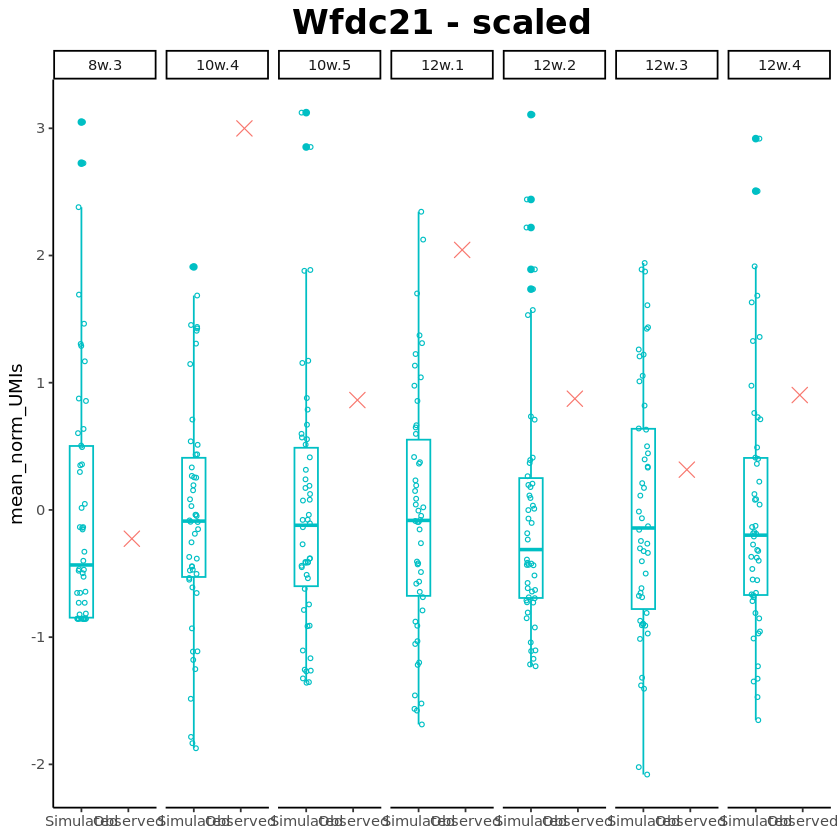

In [1763]:
gene = "Wfdc21"
ggplot(scaled_all_means %>% filter(Gene==gene) %>%
       mutate(age_replicate=factor(age_replicate, levels = c('8w.3', '10w.4', '10w.5', '12w.1', '12w.2', '12w.3', '12w.4'))), 
       aes(x=source, y=mean_norm_UMIs, color=source)) +
    geom_boxplot(width=0.5, data=scaled_all_means %>% filter(Gene==gene, source=="Simulated"), show.legend = F) +
    geom_jitter(width=0.1, aes(shape=source, size=source), show.legend = F) +
    scale_shape_manual(values = c(1, 4)) +
    scale_size_manual(values = c(1, 4)) +
    labs(title=paste(gene, "- scaled")) +
    facet_grid( ~ age_replicate) +
    scale_x_discrete(limits=c("Simulated", "Observed")) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'), axis.title.x = element_blank())

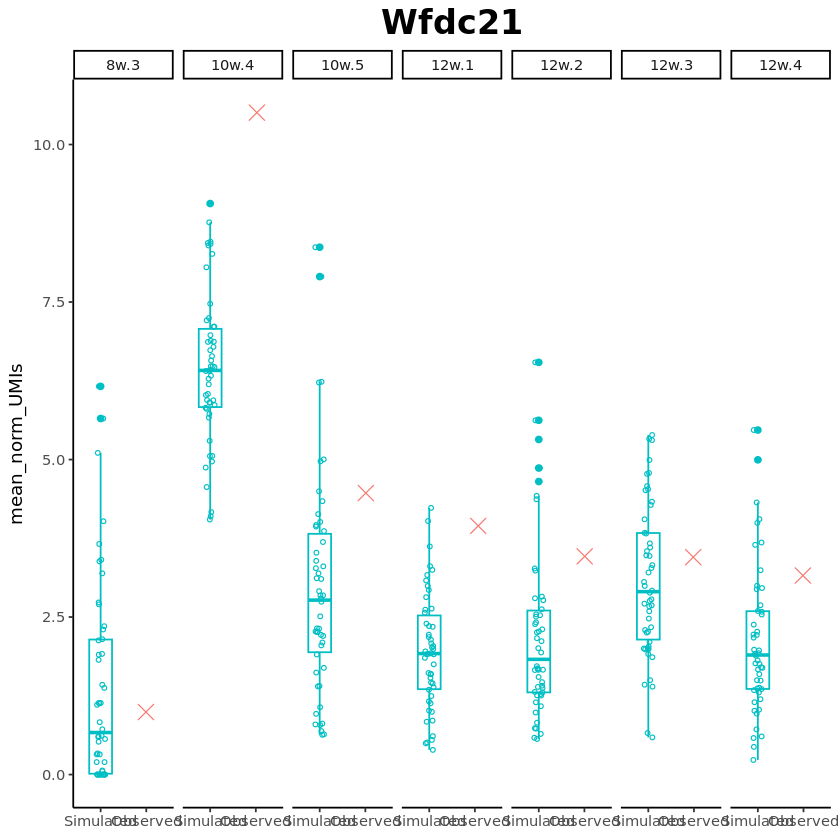

In [1764]:
gene = "Wfdc21"
ggplot(all_means %>% filter(Gene==gene)%>%
       mutate(age_replicate=factor(age_replicate, levels = c('8w.3', '10w.4', '10w.5', '12w.1', '12w.2', '12w.3', '12w.4'))), 
       aes(x=source, y=mean_norm_UMIs, color=source)) +
    geom_boxplot(width=0.5, data=all_means %>% filter(Gene==gene, source=="Simulated"), show.legend=F) +
    geom_jitter(width=0.1, aes(shape=source, size=source), show.legend = F) +
    scale_shape_manual(values = c(1, 4)) +
    scale_size_manual(values = c(1, 4)) +
    labs(title=gene) +
    facet_grid( ~ age_replicate) +
    scale_x_discrete(limits=c("Simulated", "Observed")) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'), axis.title.x = element_blank())

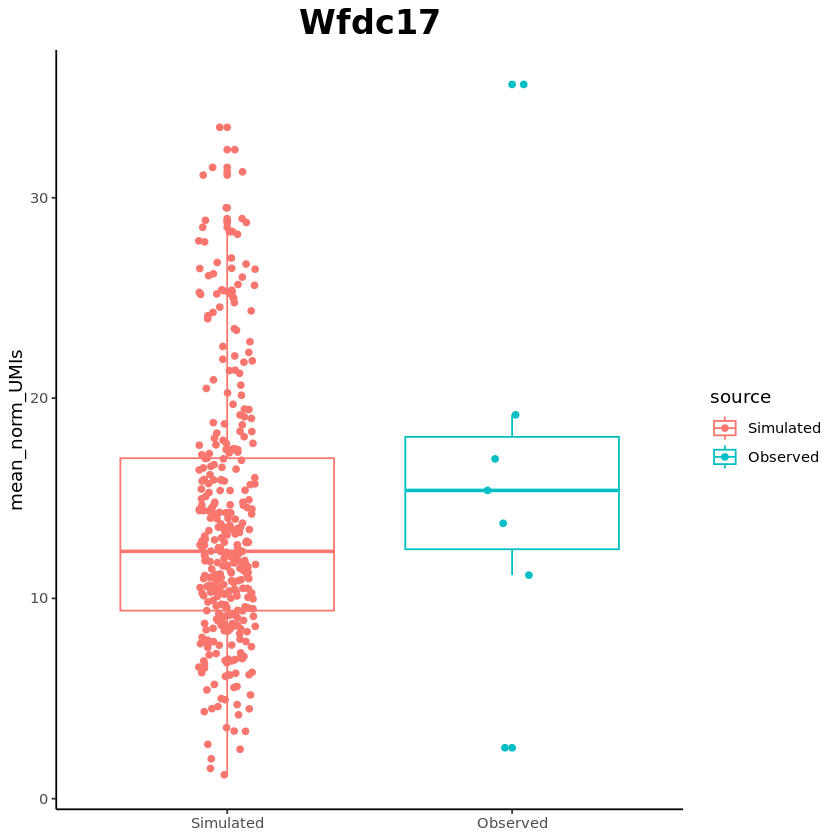

In [1570]:
gene = "Wfdc17"
ggplot(all_means %>% filter(Gene==gene), aes(x=source, y=mean_norm_UMIs, color=source)) +
    geom_boxplot() +
    geom_jitter(width=0.1) +
    labs(title=paste(gene, "- scaled")) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'), axis.title.x = element_blank())

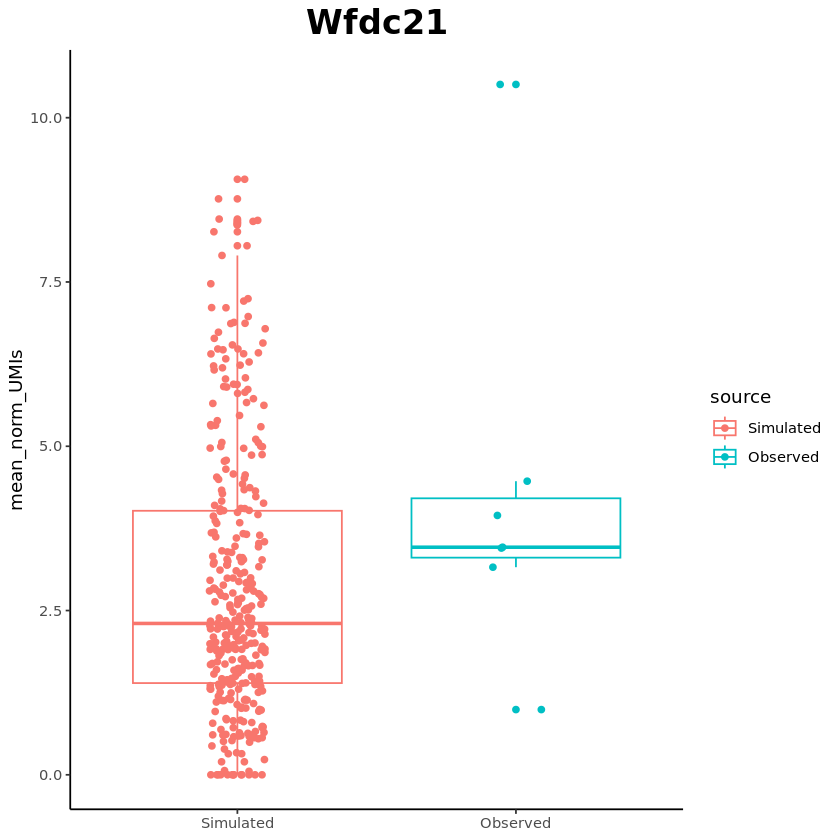

In [1571]:
gene = "Wfdc21"
ggplot(all_means %>% filter(Gene==gene), aes(x=source, y=mean_norm_UMIs, color=source)) +
    geom_boxplot() +
    geom_jitter(width=0.1) +
    labs(title=gene) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'), axis.title.x = element_blank())

In [1569]:
gene = "Wfdc21"
ggplot(all_means, aes(x=source, y=gene, color=source)) +
    geom_boxplot() +
    geom_jitter(width=0.1) +
    labs(title=gene) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'), axis.title.x = element_blank())

In [1769]:
pr_means

age_replicate A2m      AA467197  AA986860   AB124611  AI413582   AI429214   
1 12w.1         1.097238 0.2235655 0.07016805 1.9750165 0.00000000 0.379733973
2 12w.2         0.000000 0.1548371 0.15634772 0.3997729 0.14850015 0.000000000
3 12w.3         1.224031 0.2027880 0.16881104 3.2255702 0.06097189 0.449887014
4 8w.3          0.000000 0.0000000 0.00000000 1.1537299 0.29404846 0.000000000
5 10w.4         0.000000 1.1985733 0.03496878 2.6884265 0.07777605 0.005237006
6 12w.4         0.000000 0.1685204 0.36439091 1.7759923 0.72426107 0.058385637
7 10w.5         0.000000 0.0000000 0.00000000 0.8618673 0.36197156 0.382262997
  AI463229  AI467606  AI480526   ⋯ Zwilch     Zwint     Zxdb       Zxdc     
1 0.1246611 0.3555556 0.07184682 ⋯ 0.00000000 0.4837230 0.50794685 0.0000000
2 0.3815140 0.6558752 0.00000000 ⋯ 0.05430887 1.4829493 0.07670829 0.3398804
3 0.1543307 0.1417234 0.12826679 ⋯ 0.10834769 1.0141844 0.55610037 0.2881159
4 0.3549547 1.9107050 0.00000000 ⋯ 0.09892371 0.6054656 0.00000000 0.6473704
5 0.0120787 1.0213305 0.00000000 ⋯ 0.00000000 0.4838602 0.01698739 0.4643117
6 0.0000000 0.5262091 0.05838564 ⋯ 0.04300983 1.6331272 0.00000000 0.5086681
7 0.0000000 0.5068938 0.42955326 ⋯ 0.00000000 0.9555343 0.00000000 0.9932495
  Zyg11b     Zyx      Zzef1     Zzz3      source   simnum
1 0.44703323 8.561639 1.8605607 0.6583389 Observed NA    
2 0.58365675 3.294690 0.7189943 0.7442422 Observed NA    
3 0.27818538 5.067809 0.6923606 0.4742654 Observed NA    
4 0.07351211 5.708572 1.3494526 1.9468734 Observed NA    
5 0.43045849 6.321295 0.4633820 0.2003342 Observed NA    
6 0.21899463 3.798494 0.1013955 0.5347836 Observed NA    
7 0.00000000 9.597202 0.4197652 0.4538853 Observed NA

In [1480]:
gene = 'Wfdc21'
asduha = t.test(sim_gene_means[gene,], pr_means[,gene])

In [1660]:
sim_scaled = scaled_all_means %>% 
    filter(source == "Simulated") %>% 
    dcast(Gene ~ age_replicate + simnum) %>%
    column_to_rownames('Gene')

Using mean_norm_UMIs as value column: use value.var to override.



In [1662]:
obs_scaled = scaled_all_means %>% 
    filter(source == "Observed") %>% 
    dcast(Gene ~ age_replicate + simnum) %>%
    column_to_rownames('Gene')

Using mean_norm_UMIs as value column: use value.var to override.



In [1794]:
pr_means[,gene]

[1]  3.9471224  3.4634984  3.4503421  0.9924114 10.5063026  3.1593046  4.4684826

In [1793]:
t_pvals = sapply(shared_mat_genes[rowSums(pic_umis[shared_mat_genes,]) > 10], function(gene){
    t_res = t.test(sim_scaled[gene,],pr_means[,gene], paired = T)
    return(t_res$p.value)
})

ERROR: Error in complete.cases(x, y): not all arguments have the same length


In [1778]:
p.adjust(t_pvals, method='fdr')['Wfdc21']

Wfdc21 
0.7912581

In [1783]:
sum_pr_sim_means = pr_sim_means %>% group_by(age_replicate) %>% summarise_all(mean)

Warning message:
“There were 14 warnings in `summarise()`.
The first warning was:
ℹ In argument: `simnum = (new("standardGeneric", .Data = function (x, ...)
  ...`.
ℹ In group 1: `age_replicate = 12w.1`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 13 remaining warnings.”


In [1829]:
asd = scaled_all_means %>% filter(source == "Simulated") %>% group_by(Gene, age_replicate) %>%
    summarise(mean_norm_UMIs=mean(mean_norm_UMIs)) %>%
    dcast(Gene ~ age_replicate) %>%
    column_to_rownames('Gene')


`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Using mean_norm_UMIs as value column: use value.var to override.



In [1821]:
obs_scaled[gene,paste0(rep_order,'_NA')]

8w.3_NA    10w.4_NA 10w.5_NA  12w.1_NA 12w.2_NA  12w.3_NA  12w.4_NA 
Wfdc21 -0.2263852 2.999    0.8636814 2.043862 0.8742402 0.3165387 0.9031489

In [1801]:
sum_pr_sim_means[,gene] %>% unlist

Wfdc211  Wfdc212  Wfdc213  Wfdc214  Wfdc215  Wfdc216  Wfdc217 
1.960040 2.234169 3.064947 1.356854 6.451589 2.103956 2.947090

In [1807]:
rep_order=c('8w.3', '10w.4', '10w.5', '12w.1', '12w.2', '12w.3', '12w.4')

In [1815]:
sum_pr_sim_means = column_to_rownames(sum_pr_sim_means, 'age_replicate')
pr_means = column_to_rownames(pr_means, 'age_replicate')

In [1830]:
paired_t_pvals = sapply(shared_mat_genes[rowSums(pic_umis[shared_mat_genes,]) > 10], function(gene){
    t_res = t.test(asd[gene,rep_order], 
                   pr_means[rep_order,gene], paired=T)
    return(t_res$p.value)
})

ERROR: Error in complete.cases(x, y): not all arguments have the same length


In [1817]:
p.adjust(paired_t_pvals, method='fdr')['Wfdc21']

Wfdc21 
0.4953402

In [1837]:
asd[gene,rep_order] %>% unlist

8w.3        10w.4        10w.5        12w.1        12w.2        12w.3 
 0.004527703 -0.059980005 -0.017273628 -0.040877236 -0.017484804 -0.006330773 
       12w.4 
-0.018062979

In [1834]:
obs_scaled[gene,paste0(rep_order,'_NA')] %>% unlist

8w.3_NA   10w.4_NA   10w.5_NA   12w.1_NA   12w.2_NA   12w.3_NA   12w.4_NA 
-0.2263852  2.9990002  0.8636814  2.0438618  0.8742402  0.3165387  0.9031489

In [1838]:
paired_t_pvals = sapply(shared_mat_genes[rowSums(pic_umis[shared_mat_genes,]) > 10], function(gene){
    t_res = t.test(asd[gene,rep_order] %>% unlist, 
                   obs_scaled[gene,paste0(rep_order,'_NA')] %>% unlist, paired=T)
    return(t_res$p.value)
})

In [1839]:
p.adjust(paired_t_pvals, method='fdr')['Wfdc21']

Wfdc21 
0.450436

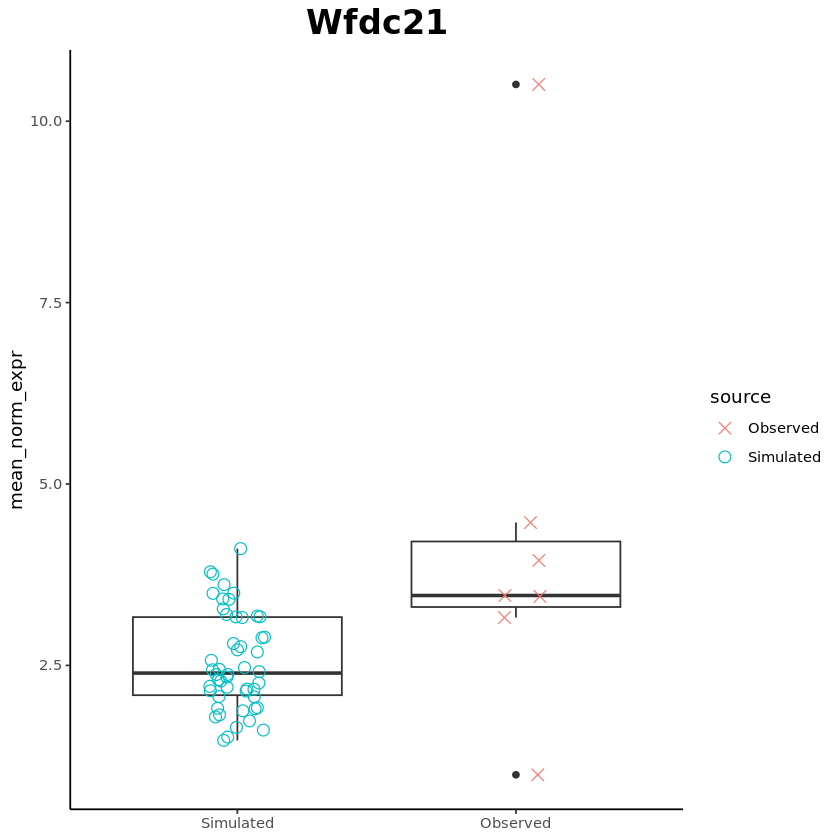

In [1504]:
gene = "Wfdc21"
data.frame(mean_norm_expr=c(sim_gene_means[gene,], pr_means[,gene]),
           source=c(rep("Simulated", 50), rep("Observed", nrow(pr_means)))) %>%
    ggplot(aes(x=source, y=mean_norm_expr)) +
    geom_boxplot() +
    geom_jitter(width=0.1, aes(color=source, shape=source), size=3) +
    scale_shape_manual(values = c(4, 1)) +
    labs(title=gene) +
    scale_x_discrete(limits=c("Simulated", "Observed")) +
    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'), axis.title.x = element_blank())

In [405]:
if (!require(devtools)) install.packages("devtools")
devtools::install_github("yanlinlin82/ggvenn")

labeling (0.4.2 -> 0.4.3) [CRAN]
gtable   (0.3.3 -> 0.3.4) [CRAN]
dplyr    (1.1.2 -> 1.1.3) [CRAN]


Installing 3 packages: labeling, gtable, dplyr

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



* checking for file ‘/tmp/Rtmp1SFk5m/remotes1403a73c9094a7/yanlinlin82-ggvenn-25fd3b5/DESCRIPTION’ ... OK
* preparing ‘ggvenn’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggvenn_0.1.10.tar.gz’



In [406]:
library(ggvenn)

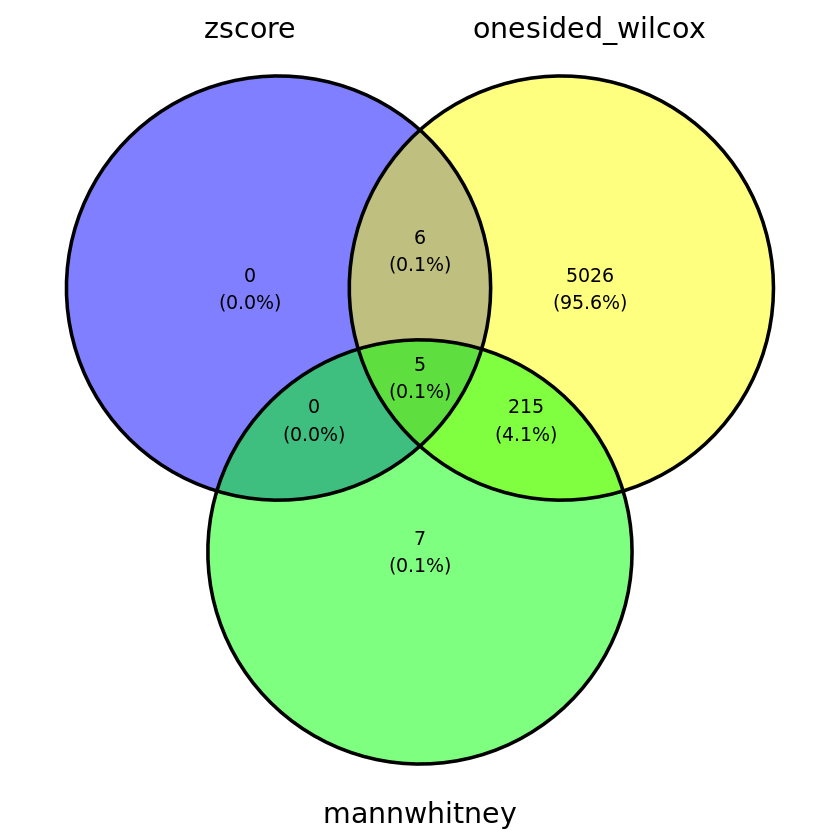

In [407]:
ggvenn(list(zscore=rownames(gene_df[gene_df$adj_pval < 0.05,]), 
            onesided_wilcox=rownames(gene_df[gene_df$adj_wilcox_onesided_pval < 0.05,]), 
            mannwhitney=rownames(gene_df[gene_df$adj_mw_pval < 0.05,])))

In [457]:
rownames(gene_df[gene_df$adj_mw_pval < 0.05 & gene_df$adj_pval >= 0.05,])

[1] "1600014C10Rik" "2210406H18Rik" "5031425E22Rik" "AA467197"     
  [5] "AB124611"      "AI467606"      "Actn1"         "Adam19"       
  [9] "Adam8"         "Add3"          "Adgrg3"        "Adpgk"        
 [13] "Alox5"         "Alox5ap"       "Amotl2"        "Ampd3"        
 [17] "Anxa1"         "Anxa2"         "Arpc2"         "Asprv1"       
 [21] "Atp6v1b2"      "Atxn10"        "Azin1"         "B2m"          
 [25] "Bcl3"          "Bst1"          "C5ar1"         "Cabin1"       
 [29] "Ccnd3"         "Ccrl2"         "Cd177"         "Cd52"         
 [33] "Cd53"          "Cd81"          "Cers6"         "Cfap97"       
 [37] "Cfp"           "Chst11"        "Cox4i1"        "Csf2rb"       
 [41] "Csn3"          "Cstdc4"        "Cstdc5"        "Cxcl2"        
 [45] "Cxcr1"         "Cyp4f18"       "Ddx6"          "Dock2"        
 [49] "Dst"           "Dynlt2b"       "Ebi3"          "Eef1b2"       
 [53] "Egr1"          "Emilin2"       "Fbxl5"         "Fpr1"         
 [57] "Fpr2"          "G0s2"          "G6pdx"         "Galnt6"       
 [61] "Gda"           "Glipr1"        "Glipr2"        "Glrx"         
 [65] "Glycam1"       "Gm10136"       "Gm10800"       "Gm11827"      
 [69] "Gm11942"       "Gm15349"       "Gm15501"       "Gm20100"      
 [73] "Gm28661"       "Gm31814"       "Gm37084"       "Gm44658"      
 [77] "Gm5781"        "Gm7665"        "Gm9034"        "Gm9439"       
 [81] "Gmfg"          "Gpsm3"         "Grina"         "Gsdmd"        
 [85] "Gsn"           "Gtf2h4"        "Hck"           "Hmgn2-ps"     
 [89] "Hnrnpa1"       "Hp"            "Hpcal1"        "Idh3b"        
 [93] "Ifitm1"        "Ifitm2"        "Ifitm6"        "Igfbp5"       
 [97] "Ikbkg"         "Il36g"         "Il4ra"         "Itgam"        
[101] "Itgb2"         "Itm2b"         "Kctd12"        "Klhl18"       
[105] "Lasp1"         "Lilrb4b"       "Lmnb1"         "Lrrc58"       
[109] "Ly6c2"         "Ly6g"          "Lypd6b"        "Lyst"         
[113] "Map2k3"        "Max"           "Mcam"          "Mcemp1"       
[117] "Milr1"         "Mirt2"         "Mlycd"         "Mmp8"         
[121] "Mmp9"          "Mrgpra2b"      "Mtus1"         "Myd88"        
[125] "Myo1f"         "Nfam1"         "Ngp"           "Nlrp12"       
[129] "Npl"           "Nr4a1"         "Nufip2"        "Ogfod1"       
[133] "Olfr550"       "Osm"           "Pak2"          "Pdlim2"       
[137] "Pglyrp1"       "Picalm"        "Plet1"         "Ppp1r18"      
[141] "Ppp2cb"        "Pramel12"      "Prkcb"         "Prok2"        
[145] "Prr13"         "Pygl"          "R3hdm4"        "Rab24"        
[149] "Rac2"          "Rara"          "Retnlg"        "Rn18s-rs5"    
[153] "Rnf144a"       "Rock2"         "Rpl11"         "Rpl17"        
[157] "Rpl17-ps8"     "Rpl18a"        "Rpl21"         "Rpl22"        
[161] "Rpl28"         "Rpl28-ps1"     "Rpl39"         "Rpl4"         
[165] "Rpl9"          "Rplp1"         "Rps11-ps2"     "Rps15"        
[169] "Rps19"         "Rps20"         "Rps26"         "Rps29"        
[173] "Rps3"          "Rps3a1"        "Rps5"          "Rps8"         
[177] "Rps9"          "Rpsa"          "S100a11"       "S100a6"       
[181] "S100a8"        "S100a9"        "Saa3"          "Scgb1b27"     
[185] "Serinc3"       "Slc15a2"       "Slc16a3"       "Slc22a15"     
[189] "Slc2a3"        "Slpi"          "Smg1"          "Stat3"        
[193] "Stfa2"         "Stfa2l1"       "Stk19"         "Syk"          
[197] "Taf7"          "Tarm1"         "Tasl"          "Tgds"         
[201] "Thap6"         "Timp2"         "Tlr13"         "Tlr6"         
[205] "Tmem268"       "Tnfrsf1b"      "Tspo"          "Ubb"          
[209] "Ube2h"         "Ubtd1"         "Upp1"          "Vim"          
[213] "Vmac"          "Wfdc17"        "Wfdc21"        "Xpc"          
[217] "Xpo6"          "Zbed5"         "Zbtb10"        "Zbtb7b"       
[221] "Zfp217"        "Zfp865"

In [458]:
for (gene in rownames(gene_df[gene_df$adj_mw_pval < 0.05 & gene_df$adj_pval >= 0.05,])){
    sim_df = data.frame(cell=str_split_i(colnames(focus_sims), "_s", 1), counts=focus_sims[gene,])
    obs_df = data.frame(cell=colnames(focus_mat), counts=focus_mat[gene,])

    pic_order = rev(names(sort(focus_mat[gene,])))

    sim_df = mutate(sim_df, cell=factor(cell, levels=pic_order))
    obs_df = mutate(obs_df, cell=factor(cell, levels=pic_order))

    ggplot(sim_df, aes(y=cell, x=counts)) +
        geom_boxplot(color = "slategray", outlier.alpha = 0.1) +
        geom_point(data=obs_df, color='red') +
        labs(title=gene) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'))
    ggsave(paste0("neutrophil_pic_figs/sum_gene_analysis/mw_shared/", gene, "_boxplots.png"), dpi=1200, height=12, width=4)
    
    plot_df = data.frame(UMI_sum=c(focus_sim_sums[gene,], mean(focus_sums[gene])),
                         source=c(rep("Simulated", 1000), "Observed"))
    gene_mean = mean(plot_df[plot_df$source == "Simulated","UMI_sum"])
    gene_sd = sd(plot_df[plot_df$source == "Simulated","UMI_sum"])
    
    # Distribution with SDs
    ggplot(plot_df, aes(x=UMI_sum)) +
        geom_density(data=plot_df[plot_df$source == "Simulated",]) +
        geom_vline(xintercept = gene_mean, color='blue', linetype='longdash') +
        geom_vline(xintercept = c(gene_mean + gene_sd, gene_mean - gene_sd), color='steelblue', linetype='longdash') +
        geom_vline(xintercept = c(gene_mean + (2 * gene_sd), gene_mean - (2 * gene_sd)), color='gray', linetype='longdash') +
        geom_vline(xintercept = plot_df[plot_df$source == "Observed","UMI_sum"], color='red') +
        geom_point(data=plot_df[plot_df$source == "Observed",], aes(y=0), color='red', size=3) +
        labs(title=gene) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'))
    ggsave(paste0("neutrophil_pic_figs/sum_gene_analysis/mw_shared/", gene, "_dist.png"), dpi=1200)
    
    # Plot of all means
    ggplot(plot_df, aes(x=1, y=UMI_sum)) +
        geom_boxplot(data=. %>% filter(source == "Simulated")) +
        geom_jitter(width=0.1, aes(color=source, shape=source, size=source)) +
        scale_shape_manual(values = c(19, 1)) +
        scale_size_manual(values = c(5, 3)) +
        labs(title=gene) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'), 
              axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank())
        #scale_x_discrete(limits=c("Simulated", "Observed"))
    ggsave(paste0("neutrophil_pic_figs/sum_gene_analysis/mw_shared/", gene, "_means.png"), dpi=1200, width=5, height=15)
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 i

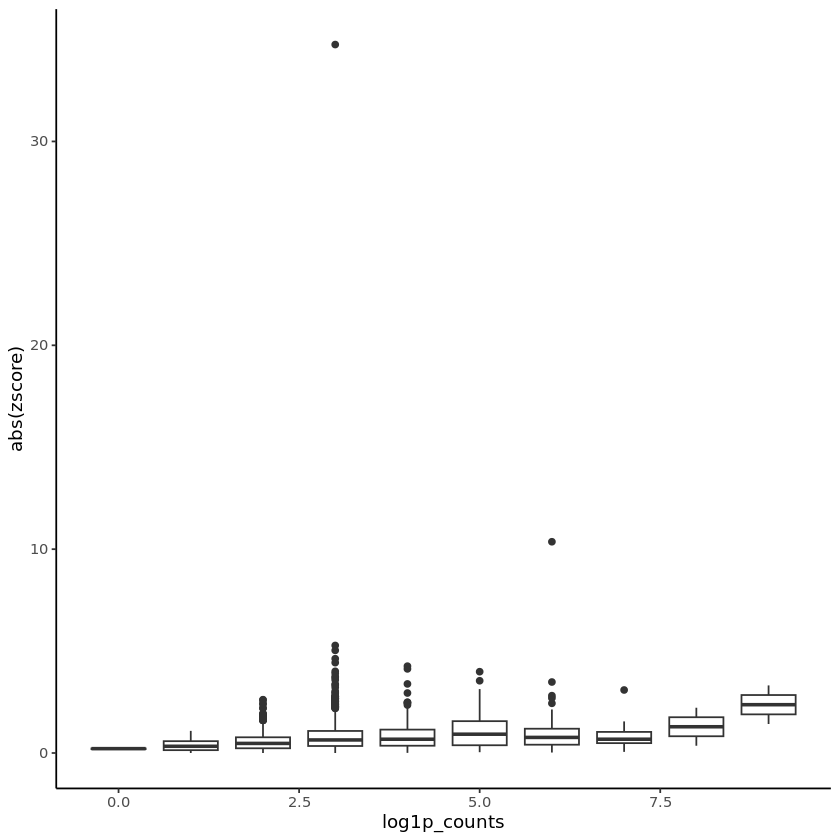

In [445]:
data.frame(log1p_counts=round(log1p(pmax(gene_df$Observed_sum, gene_df$Simulated_mean_sum))),
           zscore=gene_df$zscores) %>%
ggplot(aes(x=log1p_counts, y=abs(zscore), group=log1p_counts)) +
    geom_boxplot()

Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


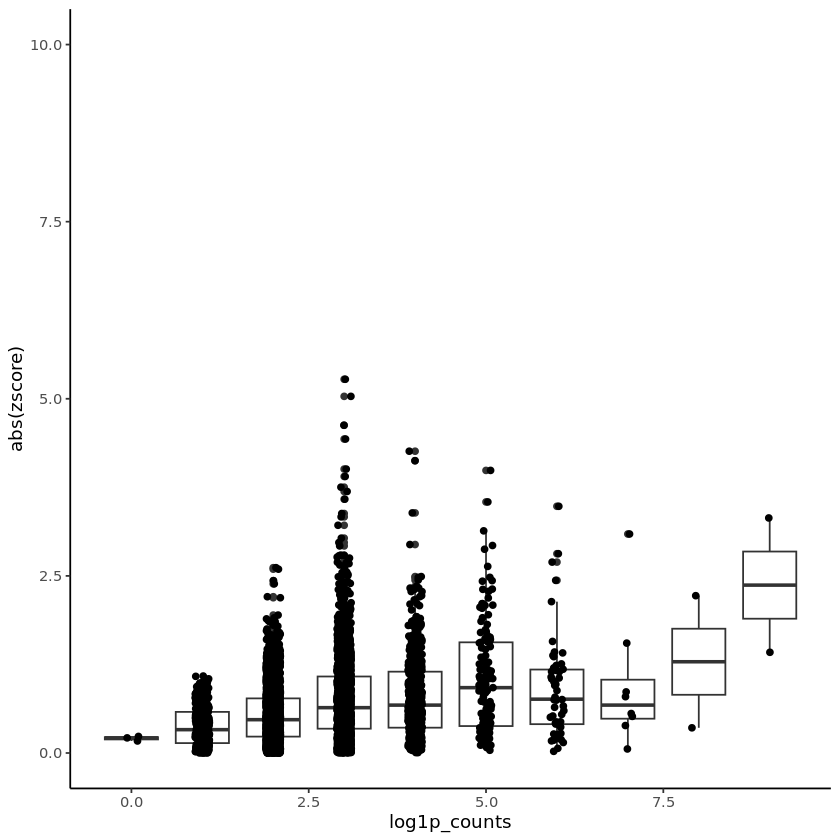

In [455]:
data.frame(log1p_counts=round(log1p(pmax(gene_df$Observed_sum, gene_df$Simulated_mean_sum))),
           zscore=gene_df$zscores) %>%
ggplot(aes(x=log1p_counts, y=abs(zscore), group=log1p_counts)) +
    geom_boxplot() +
    geom_jitter(width=0.1) +
    scale_y_continuous(limits = (c(0,10)))

In [617]:
tan3_new = read.csv("final_figs/fig4/new_gene/TAN3_sim_means.csv", row.names = 1)

In [619]:
tan3_old = read.csv("final_figs/fig4/new_gene_old/TAN3_sim_means.csv", row.names = 1)

In [620]:
both_genes = intersect(rownames(tan3_new), rownames(tan3_old))

In [621]:
length(both_genes)

[1] 4956

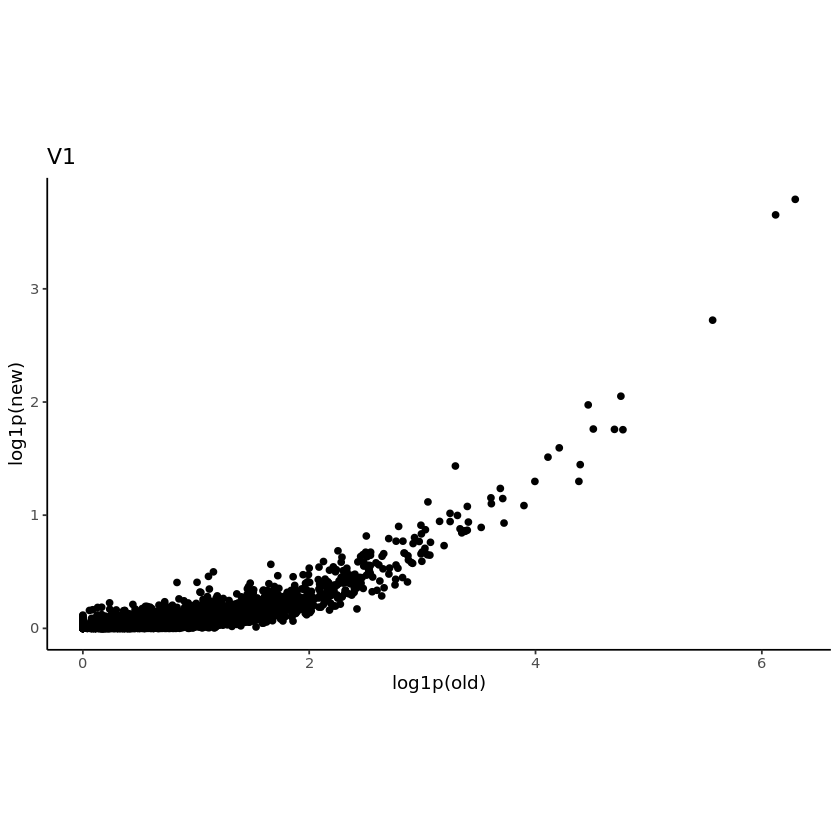

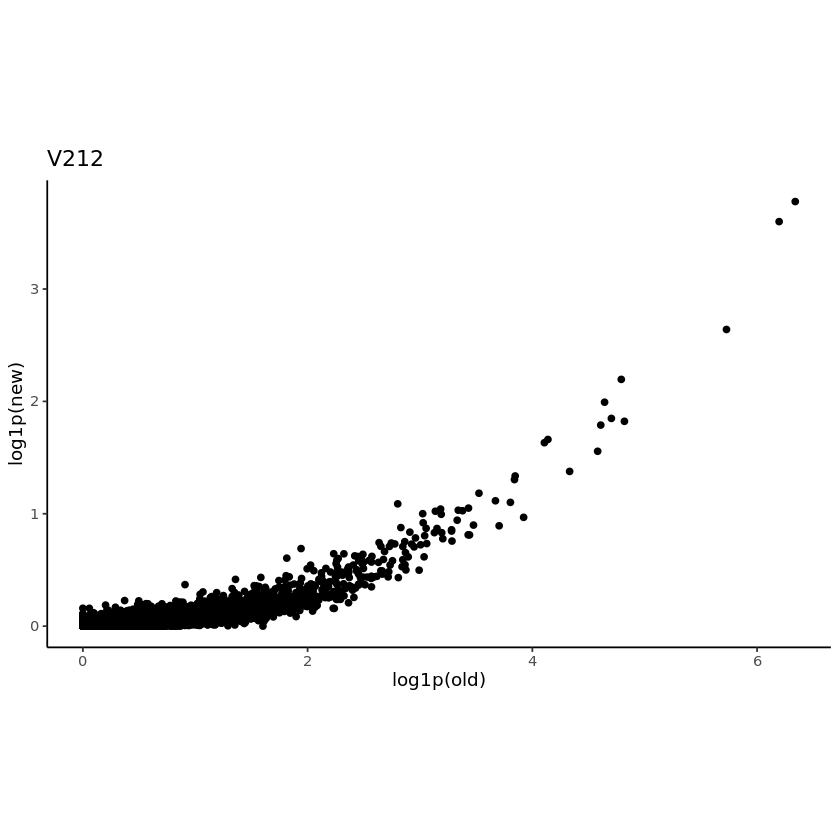

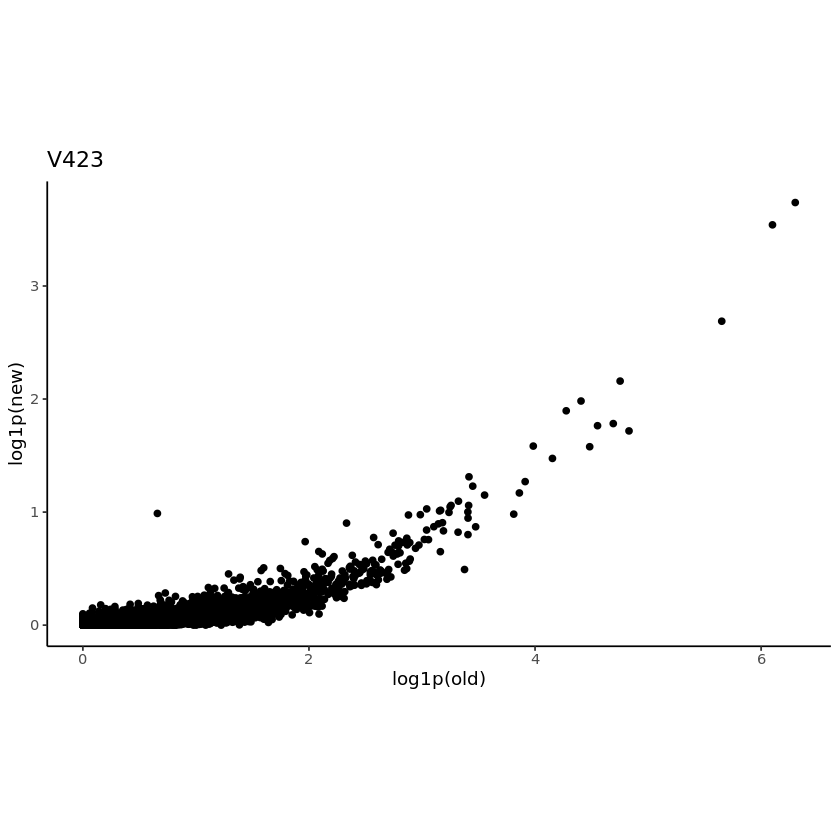

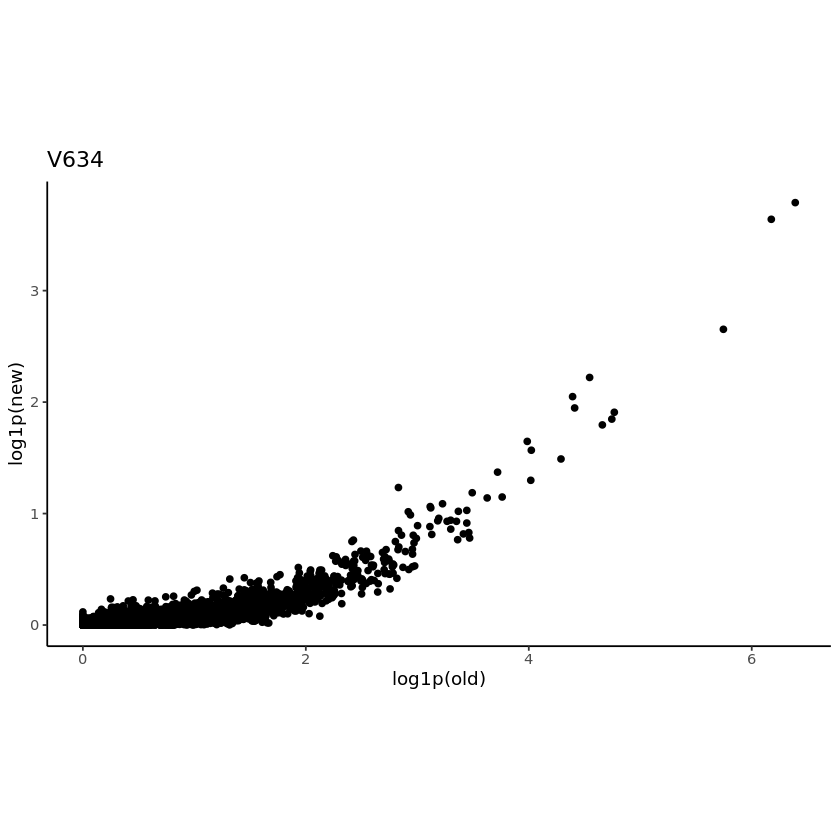

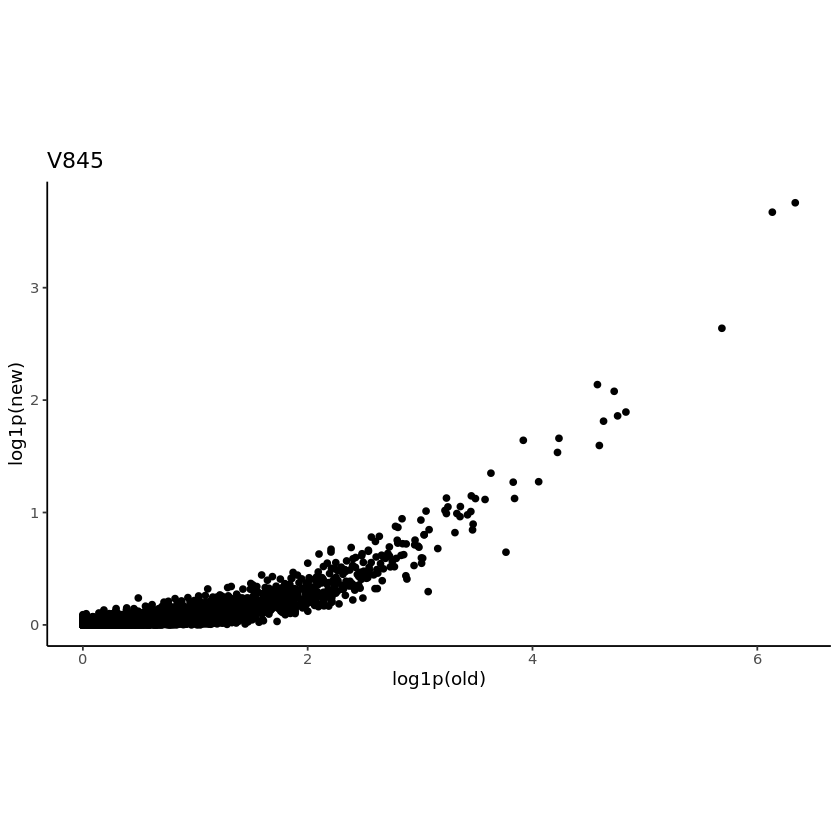

In [641]:
for (v in seq(1, 853, 211)){
    vnum = paste0("V", v)
    plot(data.frame(old=tan3_old[both_genes,vnum], new=tan3_new[both_genes,vnum]) %>%
        ggplot(aes(x=log1p(old), y=log1p(new))) +
        geom_point() +
        coord_fixed() +
        labs(title = vnum))
}

# GSEA analysis

In [63]:
?gseGO

In [ ]:
for (pop_name in c('AP high', 'Ptgs2 high', 'TAN1', 'TAN2', 'TAN3')){
    message(pop_name, "...")

    gene_df = read.csv(paste0("final_figs/fig4/new_gene_10kgenes_mediannorm/", pop_name, "_genedata.csv"), row.names = 1)

    zscore_vector = gene_df$lfc
    names(zscore_vector) = rownames(gene_df)

    zscore_vector <- sort(zscore_vector, decreasing = TRUE)

    gs_go_res = gseGO(zscore_vector,
                      ont = "BP",
                      OrgDb = 'org.Mm.eg.db',
                      keyType = "SYMBOL",
                      exponent = 1,
                      minGSSize = 5,
                      maxGSSize = 500,
                      eps = 0,
                      pvalueCutoff = 2,
                      pAdjustMethod = "BH",
                      verbose = TRUE,
                      seed = FALSE,
                      by = "fgsea")
        
    write_csv(gs_go_res %>% as.data.frame, 
              paste0("final_figs/fig4/new_gene_10kgenes_mediannorm/go_enrichment_", pop_name, ".csv"))
}

In [3]:
for (pop_name in c('All')){#, 'AP high', 'Ptgs2 high', 'TAN1', 'TAN2', 'TAN3')[4:6]){
    message(pop_name, "...")

    gene_df = read.csv(paste0("final_figs/fig4/new_gene/", pop_name, "_genedata.csv"), row.names = 1)

    zscore_vector = gene_df$lfc
    names(zscore_vector) = rownames(gene_df)

    zscore_vector <- sort(zscore_vector, decreasing = TRUE)

    gs_go_res = gseGO(zscore_vector,
                      ont = "BP",
                      OrgDb = 'org.Mm.eg.db',
                      keyType = "SYMBOL",
                      exponent = 1,
                      minGSSize = 5,
                      maxGSSize = 500,
                      eps = 0,
                      pvalueCutoff = 2,
                      pAdjustMethod = "BH",
                      verbose = TRUE,
                      seed = FALSE,
                      by = "fgsea")
    
    gs_go_res = simplify(gs_go_res, 
                         cutoff = 0.7,
                         by = "p.adjust",
                         select_fun = min,
                         measure = "Wang",
                         semData = NULL)
        
    #write_csv(gs_go_res %>% as.data.frame, 
     #         paste0("final_figs/fig4/new_gene/go_enrichment_", pop_name, ".csv"))
}

All...



In [64]:
?ggplot2

In [3]:
for (pop_name in c('TANs_merged_1012w')){#, 'AP high', 'Ptgs2 high', 'TAN1', 'TAN2', 'TAN3')[4:6]){
    message(pop_name, "...")

    gene_df = read.csv(paste0("final_figs/fig4/new_gene_sd/", pop_name, "_genedata.csv"), row.names = 1)

    zscore_vector = gene_df$lfc
    names(zscore_vector) = rownames(gene_df)

    zscore_vector <- sort(zscore_vector, decreasing = TRUE)

    gs_go_res = gseGO(zscore_vector,
                      ont = "BP",
                      OrgDb = 'org.Mm.eg.db',
                      keyType = "SYMBOL",
                      exponent = 1,
                      minGSSize = 5,
                      maxGSSize = 500,
                      eps = 0,
                      pvalueCutoff = 2,
                      pAdjustMethod = "BH",
                      verbose = TRUE,
                      seed = FALSE,
                      by = "fgsea")
    
    write_csv(gs_go_res %>% as.data.frame, 
              paste0("final_figs/fig4/new_gene_sd/go_enrichment_", pop_name, ".csv"))
}

TANs_merged_1012w...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



In [2]:
plot_df = read.csv(paste0("final_figs/fig4/new_gene/go_enrichment_", "All", ".csv"))

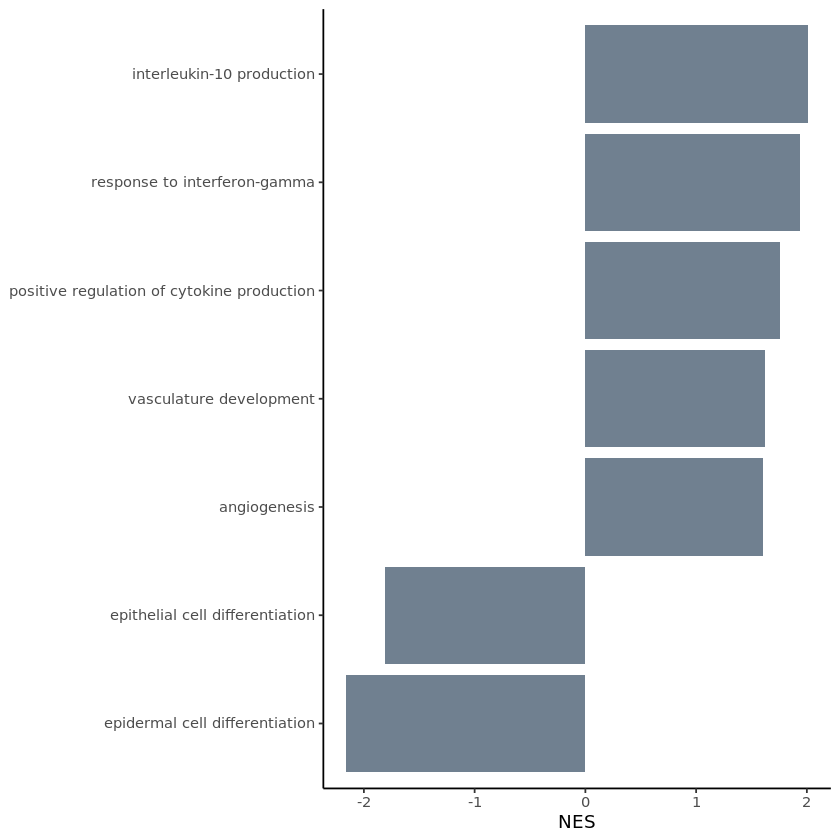

In [11]:
focus_terms = c("epithelial cell differentiation",
                "epidermal cell differentiation",
                "interleukin-10 production",
                "positive regulation of cytokine production",
                "response to interferon-gamma",
                "vasculature development",
                "angiogenesis")
plot_df %>% 
    filter(Description %in% focus_terms) %>%
    arrange(NES) %>%
    mutate(Description = factor(Description, levels=Description)) %>%
    ggplot(aes(x=NES, y=Description, fill=ifelse(NES > 0, "steelblue", "chocolate"))) +
        geom_bar(stat='identity', orientation = 'y', show.legend = F, fill='slategray') +
        theme(axis.title.y = element_blank())
ggsave("final_figs/fig4/new_gene/go_enrichment_barplot.png", dpi=1200, height=4, width=8)

In [ ]:
1

In [2]:
mm_hallmark_sets <- msigdbr(
    species = "Mus musculus", # Replace with species name relevant to your data
    category = "H",
    #subcategory = "GO:MF"
)

In [7]:
pop_name = "TAN3"

gene_df = read.csv(paste0("final_figs/fig4/new_gene_10kgenes_mediannorm/", pop_name, "_genedata.csv"), row.names = 1)

zscore_vector = gene_df$lfc
names(zscore_vector) = rownames(gene_df)

zscore_vector <- sort(zscore_vector, decreasing = TRUE)


In [9]:
gsea_results <- GSEA(
  geneList = zscore_vector, # Ordered ranked gene list
  minGSSize = 10, # Minimum gene set size
  maxGSSize = 500, # Maximum gene set set
  pvalueCutoff = 2, # p-value cutoff
  eps = 0, # Boundary for calculating the p value
  seed = TRUE, # Set seed to make results reproducible
  pAdjustMethod = "BH", # Benjamini-Hochberg correction
  TERM2GENE = dplyr::select(
    mm_hallmark_sets,
    gs_name,
    gene_symbol
  )
)


preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



In [10]:
gsea_results %>% as.data.frame

ID                                
HALLMARK_APICAL_JUNCTION           HALLMARK_APICAL_JUNCTION          
HALLMARK_TNFA_SIGNALING_VIA_NFKB   HALLMARK_TNFA_SIGNALING_VIA_NFKB  
HALLMARK_OXIDATIVE_PHOSPHORYLATION HALLMARK_OXIDATIVE_PHOSPHORYLATION
HALLMARK_ANDROGEN_RESPONSE         HALLMARK_ANDROGEN_RESPONSE        
HALLMARK_ALLOGRAFT_REJECTION       HALLMARK_ALLOGRAFT_REJECTION      
HALLMARK_UV_RESPONSE_UP            HALLMARK_UV_RESPONSE_UP           
HALLMARK_INTERFERON_GAMMA_RESPONSE HALLMARK_INTERFERON_GAMMA_RESPONSE
HALLMARK_ESTROGEN_RESPONSE_LATE    HALLMARK_ESTROGEN_RESPONSE_LATE   
HALLMARK_XENOBIOTIC_METABOLISM     HALLMARK_XENOBIOTIC_METABOLISM    
HALLMARK_COMPLEMENT                HALLMARK_COMPLEMENT               
HALLMARK_P53_PATHWAY               HALLMARK_P53_PATHWAY              
HALLMARK_COAGULATION               HALLMARK_COAGULATION              
HALLMARK_IL2_STAT5_SIGNALING       HALLMARK_IL2_STAT5_SIGNALING      
HALLMARK_INFLAMMATORY_RESPONSE     HALLMARK_INFLAMMATORY_RESPONSE    
HALLMARK_APOPTOSIS                 HALLMARK_APOPTOSIS                
HALLMARK_INTERFERON_ALPHA_RESPONSE HALLMARK_INTERFERON_ALPHA_RESPONSE
HALLMARK_HEME_METABOLISM           HALLMARK_HEME_METABOLISM          
HALLMARK_GLYCOLYSIS                HALLMARK_GLYCOLYSIS               
HALLMARK_PI3K_AKT_MTOR_SIGNALING   HALLMARK_PI3K_AKT_MTOR_SIGNALING  
HALLMARK_HYPOXIA                   HALLMARK_HYPOXIA                  
HALLMARK_UNFOLDED_PROTEIN_RESPONSE HALLMARK_UNFOLDED_PROTEIN_RESPONSE
HALLMARK_KRAS_SIGNALING_UP         HALLMARK_KRAS_SIGNALING_UP        
HALLMARK_ADIPOGENESIS              HALLMARK_ADIPOGENESIS             
HALLMARK_MTORC1_SIGNALING          HALLMARK_MTORC1_SIGNALING         
HALLMARK_MYC_TARGETS_V1            HALLMARK_MYC_TARGETS_V1           
                                   Description                        setSize
HALLMARK_APICAL_JUNCTION           HALLMARK_APICAL_JUNCTION           14     
HALLMARK_TNFA_SIGNALING_VIA_NFKB   HALLMARK_TNFA_SIGNALING_VIA_NFKB   30     
HALLMARK_OXIDATIVE_PHOSPHORYLATION HALLMARK_OXIDATIVE_PHOSPHORYLATION 41     
HALLMARK_ANDROGEN_RESPONSE         HALLMARK_ANDROGEN_RESPONSE         13     
HALLMARK_ALLOGRAFT_REJECTION       HALLMARK_ALLOGRAFT_REJECTION       12     
HALLMARK_UV_RESPONSE_UP            HALLMARK_UV_RESPONSE_UP            15     
HALLMARK_INTERFERON_GAMMA_RESPONSE HALLMARK_INTERFERON_GAMMA_RESPONSE 12     
HALLMARK_ESTROGEN_RESPONSE_LATE    HALLMARK_ESTROGEN_RESPONSE_LATE    10     
HALLMARK_XENOBIOTIC_METABOLISM     HALLMARK_XENOBIOTIC_METABOLISM     10     
HALLMARK_COMPLEMENT                HALLMARK_COMPLEMENT                19     
HALLMARK_P53_PATHWAY               HALLMARK_P53_PATHWAY               16     
HALLMARK_COAGULATION               HALLMARK_COAGULATION               11     
HALLMARK_IL2_STAT5_SIGNALING       HALLMARK_IL2_STAT5_SIGNALING       13     
HALLMARK_INFLAMMATORY_RESPONSE     HALLMARK_INFLAMMATORY_RESPONSE     13     
HALLMARK_APOPTOSIS                 HALLMARK_APOPTOSIS                 20     
HALLMARK_INTERFERON_ALPHA_RESPONSE HALLMARK_INTERFERON_ALPHA_RESPONSE 10     
HALLMARK_HEME_METABOLISM           HALLMARK_HEME_METABOLISM           11     
HALLMARK_GLYCOLYSIS                HALLMARK_GLYCOLYSIS                18     
HALLMARK_PI3K_AKT_MTOR_SIGNALING   HALLMARK_PI3K_AKT_MTOR_SIGNALING   10     
HALLMARK_HYPOXIA                   HALLMARK_HYPOXIA                   28     
HALLMARK_UNFOLDED_PROTEIN_RESPONSE HALLMARK_UNFOLDED_PROTEIN_RESPONSE 12     
HALLMARK_KRAS_SIGNALING_UP         HALLMARK_KRAS_SIGNALING_UP         10     
HALLMARK_ADIPOGENESIS              HALLMARK_ADIPOGENESIS              16     
HALLMARK_MTORC1_SIGNALING          HALLMARK_MTORC1_SIGNALING          31     
HALLMARK_MYC_TARGETS_V1            HALLMARK_MYC_TARGETS_V1            28     
                                   enrichmentScore NES        pvalue     
HALLMARK_APICAL_JUNCTION            0.6706739       1.7144019 0.008640923
HALLMARK_TNFA_SIGNALING_VIA_NFKB    0.4

In [ ]:
run_gsea_analysis = function(focus_name, lfc_table, dirname, ont="ALL", should_simplify=T, pval_cutoff=0.05){
    #lfc_table = read.csv(lfc_table_path)#, col.names = c('Gene', 'obs', 'exp', 'lfc'))
    lfc_vector = lfc_table$lfc
    names(lfc_vector) = lfc_table[[1]]
    lfc_vector <- sort(lfc_vector, decreasing = TRUE)
    
    gs_go_res = gseGO(lfc_vector,
                      ont = ont,
                      OrgDb = 'org.Mm.eg.db',
                      keyType = "SYMBOL",
                      exponent = 1,
                      minGSSize = 5,
                      maxGSSize = 500,
                      eps = 0,
                      pvalueCutoff = pval_cutoff,
                      pAdjustMethod = "BH",
                      verbose = TRUE,
                      seed = FALSE,
                      by = "fgsea")
    
    if(!should_simplify){
        message('Skipping simplification step per your request')
    }else if(ont == 'ALL'){
        message("Can't simplify when ont='ALL'")
    }else{gs_go_res = simplify(gs_go_res, 
                               cutoff = 0.7,
                               by = "p.adjust",
                               select_fun = min,
                               measure = "Wang",
                               semData = NULL)
    }
    
    final_res = gs_go_res %>% as.data.frame %>% mutate(Description=factor(Description, levels=Description))
    
    write_csv(final_res, paste0(dirname, "go_enrichment_", ont, ".csv"))
    
    ggplot(head(final_res %>% filter(NES > 0), 50), aes(x=-log10(p.adjust), y=Description)) +
        geom_bar(stat='identity', fill='steelblue') +
        labs(title = paste0("GO enrichment - gene cluster ", focus_name)) +
        scale_x_continuous(limits = c(0,max(-log10(final_res$p.adjust)))) +
        xlab("-log10(pval)") +
        theme(axis.title.y = element_blank(), title = element_text(hjust=0.5))
    ggsave(paste0(dirname, "upregulated_", focus_name, "_", ont, ".png"), dpi=1200, height=6, width=18)
    
    ggplot(head(final_res %>% filter(NES < 0), 50), aes(x=-log10(p.adjust), y=Description)) +
        geom_bar(stat='identity', fill='firebrick1') +
        labs(title = paste0("GO enrichment - gene cluster ", focus_name)) +
        scale_x_continuous(limits = c(0,max(-log10(final_res$p.adjust)))) +
        xlab("-log10(pval)") +
        theme(axis.title.y = element_blank(), title = element_text(hjust=0.5))
    ggsave(paste0(dirname, "downregulated_", focus_name, "_", ont, ".png"), dpi=1200, height=6, width=18)

}

In [6]:
old_tan3 = read.csv("final_figs/fig4/new_gene_old/TAN3_genedata.csv", row.names=1)

In [7]:
new_tan3 = read.csv("final_figs/fig4/new_gene/TAN3_genedata.csv", row.names=1)

Warning message:
“Using size for a discrete variable is not advised.”


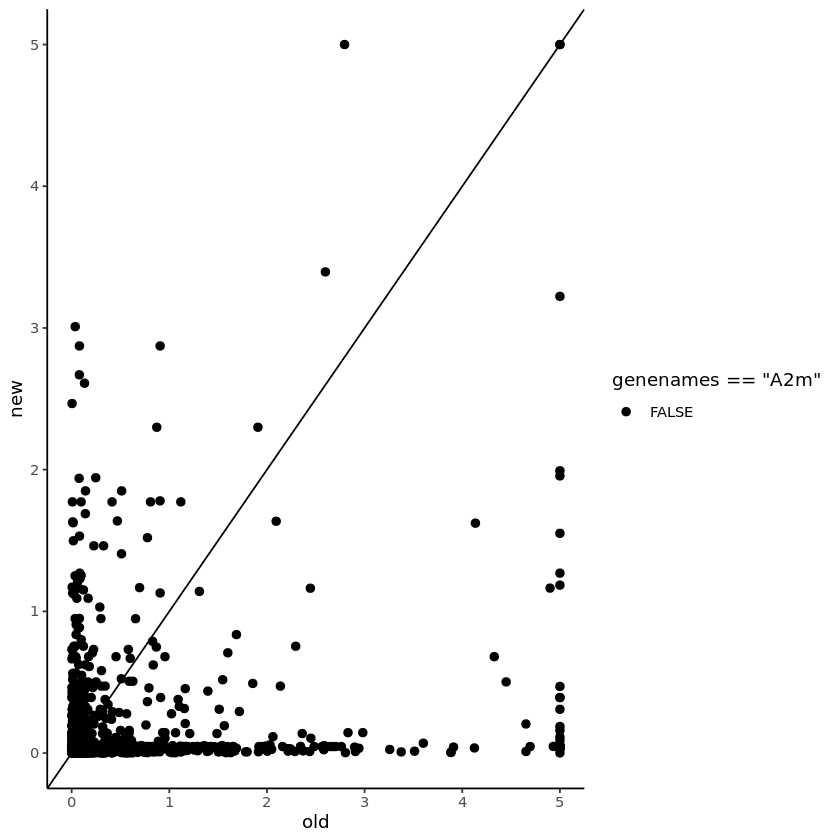

In [96]:
data.frame(old=-log10(old_tan3[rownames(new_tan3),'adj_pval']),
           new=-log10(new_tan3[,'adj_pval']),
           genenames=rownames(new_tan3)) %>%
    ggplot(aes(x=old, y=new, color=genenames == 'A2m', size=genenames == 'A2m')) +
    geom_point() +
    geom_abline(slope = 1, intercept = 0) +
    scale_color_manual(values = c('black', 'red'))

In [105]:
norm_mat

AA467197 AB124611 AI413582 AI467606 AI837181 AI839979 AU040320
AB542_M7   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB542_K8   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB542_A13  0.00000 24.63054 0        0.000000 0.000000 0         0.00000
AB542_P7   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB542_A4   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_N11  0.00000  0.00000 0        0.000000 9.900990 0         9.90099
AB539_E3   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_A8   0.00000  0.00000 0        0.000000 0.000000 0        23.31002
AB539_D2   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_J4   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_M3   0.00000  0.00000 0        0.000000 5.162623 0         0.00000
AB539_D14  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_H8   0.00000 19.64637 0        0.000000 0.000000 0         0.00000
AB539_M13 10.70664  0.00000 0        0.000000 0.000000 0         0.00000
AB539_P9   0.00000 13.40483 0        0.000000 0.000000 0        13.40483
AB539_K21  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_O11  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_G13  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_L13  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_O17  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_A20  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_B6   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_G15  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_N10  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_K16  0.00000  0.00000 0        5.336179 0.000000 0         0.00000
AB539_I8   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_B15  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_L4   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_P16  0.00000  0.00000 0        0.000000 0.000000 0         0.00000
AB539_D5   0.00000  0.00000 0        0.000000 0.000000 0         0.00000
⋮         ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮       
AB338_N20  0.00000  0.00000 0         0.00000 0        0        0       
AB338_J18  0.00000  0.00000 0         0.00000 0        0        0       
AB338_P4   0.00000 57.91506 0        19.30502 0        0        0       
AB338_B5   0.00000  0.00000 0         0.00000 0        0        0       
AB338_E12  0.00000  0.00000 0         0.00000 0        0        0       
AB338_F20  0.00000  0.00000 0         0.00000 0        0        0       
AB338_H12  0.00000  0.00000 0         0.00000 0        0        0       
AB338_P7   0.00000  0.00000 0         0.00000 0        0        0       
AB338_K13  0.00000  0.00000 0         0.00000 0        0        0       
AB338_P15  0.00000  0.00000 0         0.00000 0        0        0       
AB338_C2   0.00000  0.00000 0         0.00000 0        0        0       
AB338_P3   0.00000  0.00000 0         0.00000 0        0        0       
AB338_G14  0.00000  0.00000 0         0.00000 0        0        0       
AB338_E18  0.00000  0.00000 0         0.00000 0        0        0       
AB338_D12  0.00000  0.00000 0         0.00000 0        0        0       
AB338_L4   0.00000  0.00000 0         0.00000 0        0        0       
AB338_G15  0.00000  0.00000 0        23.80952 0        0        0       
AB338_D5   0.00000  0.00000 0         0.00000 0        0        0       
AB338_D4   0.00000  0.00000 0         0.00000 0        0        0       
AB338_C22  0.00000  0.00000 0         0.00000 0        0        0       
AB338_O6   0.00000  0.00000 0         0.00000 0        0        0       
AB338_K11  0.00000  0.00000 0         0.00000 0        0        0       
AB338_G23  0.00000  0.00000 0         0.00000 0        0        0   

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


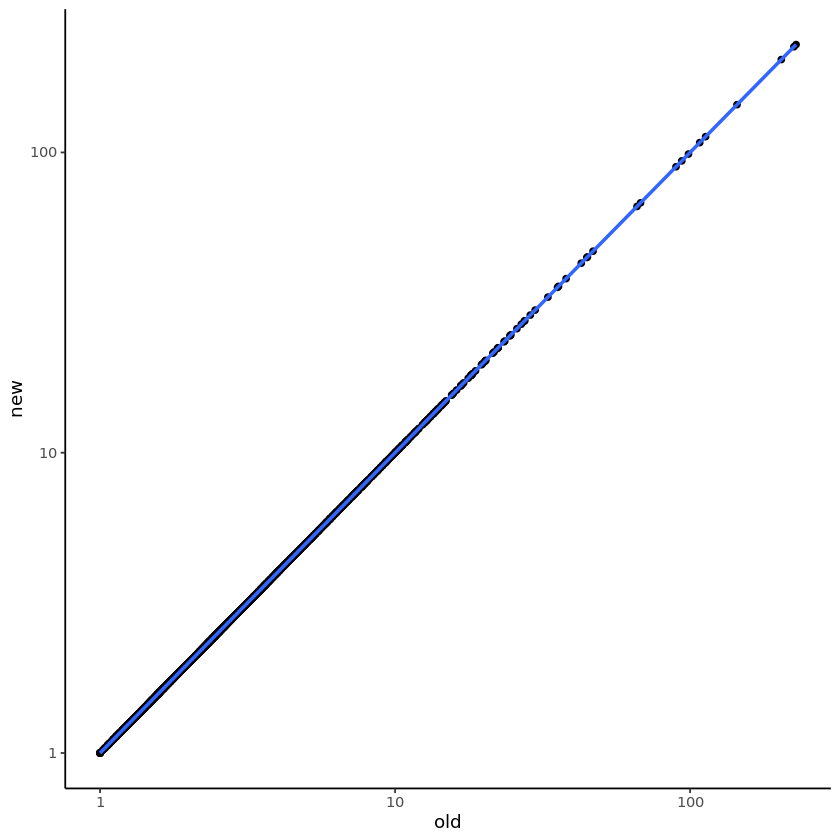

In [108]:
data.frame(old=1 + old_tan3[rownames(new_tan3),'Observed_mean'],
           new=1 + colMeans(norm_mat[which(parser_immune[analyzed_pics] == 'TAN3'),rownames(new_tan3)])) %>%
    ggplot(aes(x=old, y=new)) +
    geom_point() +
    geom_smooth() +
    scale_x_log10() +
    scale_y_log10()

In [111]:
parser_immune[rownames(norm_mat[which(parser_immune[analyzed_pics] == 'TAN3'),])]

AB539_E3              AB539_H8              AB539_P9 
               "TAN3"                "TAN2"             "AP high" 
             AB539_K3             AB539_L13             AB539_K16 
               "TAN1"             "AP high" "Young Cystatin high" 
            AB539_B15             AB539_H19             AB522_C24 
               "TAN3"             "AP high"          "Ptgs2 high" 
            AB522_O23             AB522_P18              AB522_P8 
               "TAN3"             "AP high"          "Ptgs2 high" 
             AB522_D5             AB522_O16              AB522_J3 
               "TAN3"                "TAN1"          "Ptgs2 high" 
            AB522_E22              AB522_G5             AB523_H17 
               "TAN2"          "Ptgs2 high"          "Ptgs2 high" 
            AB523_C20              AB523_K4             AB523_B16 
            "AP high"          "Ptgs2 high" "Young Cystatin high" 
            AB523_G22             AB523_O21             AB538_A15 
         "Ptgs2 high"             "AP high"                "TAN3" 
            AB538_O13             AB538_M20              AB538_P7 
               "TAN2"                "TAN3"             "AP high" 
            AB538_D20             AB538_I20             AB528_B24 
            "AP high"                "TAN3"             "AP high" 
            AB524_K19             AB524_B23             AB524_P12 
            "AP high"             "AP high"             "AP high" 
            AB524_G20             AB172_K13              AB172_F8 
            "AP high"             "AP high"          "Ptgs2 high" 
            AB172_H22              AB172_J8              AB172_H5 
         "Ptgs2 high"          "Ptgs2 high"          "Ptgs2 high" 
            AB172_B19              AB172_M2             AB172_H11 
         "Ptgs2 high"             "AP high"          "Ptgs2 high" 
            AB174_J14              AB174_P9              AB174_I4 
            "AP high"                "TAN2"          "Ptgs2 high" 
            AB174_D24             AB393_D20             AB393_J18 
            "AP high"             "AP high"             "AP high" 
             AB393_E5             AB393_K13              AB392_F2 
               "TAN3"          "Ptgs2 high"             "AP high" 
            AB392_E14              AB365_K1             AB365_B15 
            "AP high"          "Ptgs2 high"             "AP high" 
            AB365_C19             AB365_K13              AB365_E3 
         "Ptgs2 high"             "AP high"             "AP high" 
            AB365_A14             AB365_C11             AB365_D15 
               "TAN1"             "AP high"             "AP high" 
             AB365_M5              AB365_I9             AB365_E14 
         "Ptgs2 high"             "AP high"             "AP high" 
            AB365_A21              AB365_G4              AB365_C4 
               "TAN1"                "TAN1"          "Ptgs2 high" 
            AB365_C16              AB378_A4             AB378_O22 
            "AP high"          "Ptgs2 high"                "TAN3" 
            AB378_N18              AB378_L9              AB378_O4 
               "TAN1"             "AP high"                "TAN3" 
             AB378_N3             AB378_O18              AB378_K4 
               "TAN3"                "TAN3"                "TAN1" 
             AB378_A7             AB378_O24             AB378_K10 
            "AP high"                "TAN3"          "Ptgs2 high" 
            AB378_O12             AB378_L11             AB378_M23 
"Young Cystatin high"                "TAN3"                "TAN3" 
            AB378_E16             AB378_I17             AB395_E12 
         "Ptgs2 high"                "TAN2"                "TAN2" 
            AB395_D11             AB395_M17             AB395_G19 
      "Cystatin high"                "TAN1"                "TAN3" 
            AB395_C14             AB395_P11             AB395_M16 
               "TAN1"                "TAN1"          "Ptgs2 

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


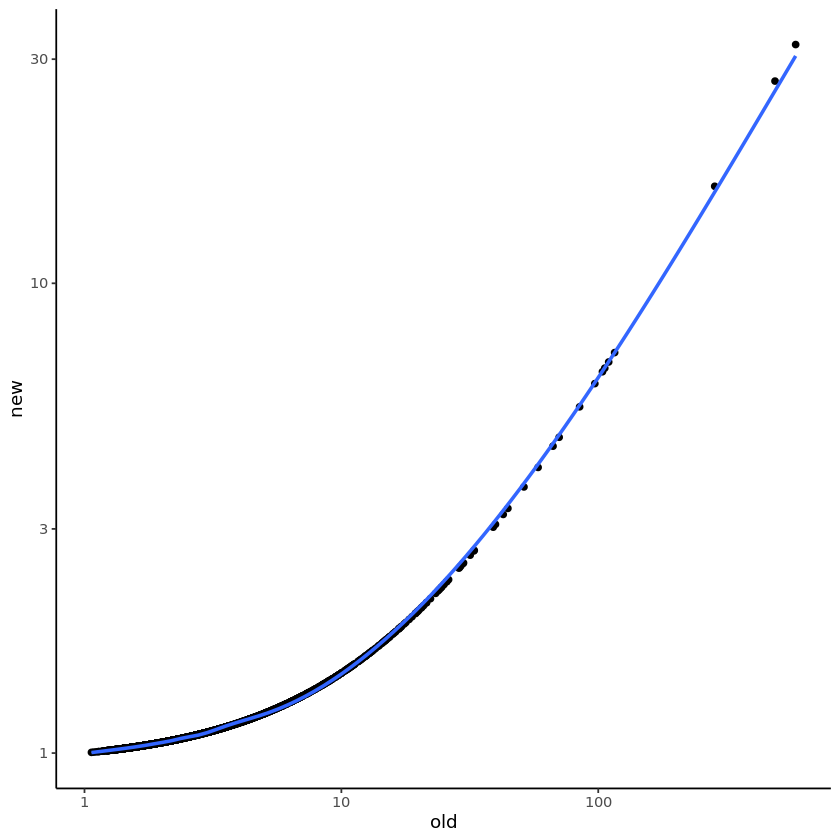

In [25]:
data.frame(old=1 + old_tan3[rownames(new_tan3),'Simulated_mean'],
           new=1 + new_tan3[,'Simulated_mean']) %>%
    ggplot(aes(x=old, y=new)) +
    geom_point() +
    geom_smooth() +
    scale_x_log10() +
    scale_y_log10()

In [97]:
indices = list(All=which(analyzed_pics %in% analyzed_pics))
for (neut in immune_pops){
    focus_pics = names(which(parser_immune[analyzed_pics] == neut))
    indices[neut] = list(which(analyzed_pics %in% focus_pics))
}


In [101]:
indices$TAN3 == which(parser_immune[analyzed_pics] == "TAN3")

AB539_E3 AB539_M13 AB539_K21 AB539_O17 AB539_A20 AB539_B15 AB539_P16  AB522_F8 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB522_O23 AB522_O11 AB522_F10  AB522_D5  AB522_H4 AB522_N17 AB522_M14 AB538_O11 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB538_A15 AB538_M20 AB538_I20  AB538_B8 AB538_K22  AB538_J4  AB538_C8  AB528_A5 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB528_M23 AB528_C12 AB524_B18  AB524_E3 AB524_F10  AB524_C9 AB172_G23  AB172_G3 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB172_I11 AB172_F21  AB393_I9 AB393_L10  AB393_E5  AB365_L7 AB365_K24 AB365_E18 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB378_C19  AB378_K7 AB378_N20 AB378_O22 AB378_O13  AB378_F7  AB378_O4 AB378_N22 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
 AB378_I4  AB378_M5 AB378_H16  AB378_N3 AB378_H18 AB378_C15 AB378_G18  AB378_C8 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB378_J14 AB378_O24  AB378_A2 AB378_A10 AB378_P13  AB378_H4 AB378_L10 AB378_L11 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB378_M23 AB378_O11 AB378_G19  AB395_O4 AB395_N17 AB395_M22 AB395_J12 AB395_C12 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB395_H14  AB395_G9 AB395_F18 AB318_L21  AB318_K8 AB319_H20 AB319_L12 AB319_L16 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
 AB319_A2  AB319_F2  AB319_M1 AB340_E11 AB340_O10  AB340_B8 AB340_K12 AB340_B12 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
AB340_G24 AB340_N11  AB340_I9  AB340_L5 AB340_I16 AB340_E18 AB340_A22 AB340_F20 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
 AB338_H2 AB338_M15 AB338_O14 AB338_P11  AB338_F1 AB338_J12 AB338_E19  AB338_O6 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE

# Per comb graphs

In [44]:
immune_pops[3:7]

[1] "AP high"    "Ptgs2 high" "TAN1"       "TAN2"       "TAN3"

In [105]:
decreasingfull_genedata = sapply(3:7, function(i){
    pop = immune_pops[i]
    read.csv(paste0("final_figs/fig4/new_gene/", pop, "_genedata.csv"), row.names=1) %>% cbind(source_index=i) %>% as.matrix
}) %>% 
    do.call(rbind, .) %>% 
    as.data.frame %>% 
    mutate(annotation=immune_pops[source_index]) %>% 
    rownames_to_column("gene") %>%
    mutate(gene = str_split_i(gene, "\\.", 1))plot_df

In [106]:
colnames(full_genedata)[1] = "gene"

In [107]:
full_genedata

gene     Observed_mean Simulated_mean z_scores    full_adj_pval
1     A2m      0.04601894    0.00399707      6.68475148 5.442886e-08 
2     AU020206 0.02039351    0.02609882     -0.37854119 9.716742e-01 
3     AU040320 0.01750765    0.03242234     -0.87212680 9.492706e-01 
4     AY036118 0.06234009    0.06901154     -0.18798278 9.862188e-01 
5     Aaas     0.04290249    0.01863946      1.89237520 7.682217e-01 
6     Aagab    0.06127887    0.04769226      0.63803436 9.642615e-01 
7     Aamdc    0.01890664    0.03007770     -0.61031303 9.642615e-01 
8     Aamp     0.08127428    0.07582087      0.20968383 9.848458e-01 
9     Aars     0.07109933    0.04784711      1.13262554 9.345605e-01 
10    Aasdhppt 0.03519576    0.02643240      0.56433665 9.642615e-01 
11    Abca1    0.03628952    0.01466169      1.81811151 8.226218e-01 
12    Abcd3    0.11617961    0.10145538      0.50478729 9.642615e-01 
13    Abce1    0.08579271    0.07904299      0.24045434 9.848458e-01 
14    Abcf1    0.15064980    0.12812827      0.55758503 9.642615e-01 
15    Abcg2    0.02063453    0.01899330      0.12266094 9.921019e-01 
16    Abhd11   0.01514527    0.03163287     -0.98997891 9.386951e-01 
17    Abhd13   0.01635661    0.03936519     -1.20020558 9.171115e-01 
18    Abhd16a  0.05522833    0.05166405      0.16709062 9.884877e-01 
19    Abhd17a  0.12950869    0.07701915      1.96208064 7.368168e-01 
20    Abhd17b  0.01418484    0.03819723     -1.27901515 9.171115e-01 
21    Abhd17c  0.09034996    0.08621428      0.13548889 9.920889e-01 
22    Abhd2    0.05848546    0.06196782     -0.14491652 9.909511e-01 
23    Abhd4    0.03322507    0.04136745     -0.41005158 9.716742e-01 
24    Abhd5    0.13612460    0.12761443      0.23819324 9.848458e-01 
25    Abi1     0.05587446    0.10166461     -1.35692702 9.171115e-01 
26    Abl1     0.04396350    0.04565803     -0.07292655 9.927721e-01 
27    Abraxas2 0.04917903    0.02858695      1.30292446 9.171115e-01 
28    Acaa1a   0.06602819    0.05991418      0.27534902 9.848458e-01 
29    Acaa2    0.09010878    0.08419352      0.21306453 9.848458e-01 
30    Acad8    0.01934158    0.03567741     -0.95923240 9.416562e-01 
⋮     ⋮        ⋮             ⋮              ⋮           ⋮            
23451 Zfp91    0.042071462   0.04888672     -0.28455316 0.9798805    
23452 Zfp949   0.051407312   0.02624944      1.33757267 0.9404623    
23453 Zfr      0.035585561   0.04423966     -0.37817794 0.9730966    
23454 Zhx1     0.041308420   0.02082596      1.26124716 0.9404623    
23455 Zkscan1  0.023058315   0.03461841     -0.56038235 0.9489391    
23456 Zmat2    0.061938977   0.13086519     -1.34831578 0.9404623    
23457 Zmiz1    0.086027158   0.11382140     -0.69937678 0.9404623    
23458 Zmiz2    0.003538093   0.02609063     -1.18637556 0.9404623    
23459 Zmpste24 0.035580062   0.06119347     -0.80287455 0.9404623    
23460 Zmym2    0.049656261   0.04445799      0.20139233 0.9895909    
23461 Zmym4    0.018869831   0.01395299      0.38072634 0.9724337    
23462 Zmym5    0.022883070   0.05024076     -1.02427516 0.9404623    
23463 Zmynd19  0.044472047   0.01334903      2.60106867 0.2893874    
23464 Znfx1    0.023042158   0.01156829      1.01190229 0.9404623    
23465 Znhit1   0.036935705   0.06291448     -0.76884690 0.9404623    
23466 Znhit6   0.028559438   0.02168232      0.43682130 0.9648859    
23467 Znrf1    0.045363050   0.06738298     -0.74966468 0.9404623    
23468 Znrf2    0.087017741   0.04985308      1.58918341 0.9404623    
23469 Zpr1     0.061331710   0.03308652      1.28879157 0.9404623    
23470 Zranb1   0.061394727   0.06992627     -0.28131561 0.9798805    
23471 Zranb2   0.020112256   0.04044187     -0.90197575 0.9404623    
23472 Zrsr2    0.025827822   0.03355047     -0.33676300 0.9773444    
23473 Zscan21  0.064421927   0.02251162      2.24100084 0.5206741    
23474 Zscan26  0.036936053   0.03586886      0.04974135 0.9988217    
23475 Zswim4   0.019669274   0.02901923     -0.41321799 0.9675225    
23476 Zwint    0

In [109]:
gene_df = full_genedata %>% filter(gene == "Cxcl2")

data.frame(Observed=gene_df$Observed_mean, 
           immune_exp=gene_df$Simulated_mean * (1 - gene_df$epi_imm_ratio), 
           epithelial_exp=gene_df$Simulated_mean * gene_df$epi_imm_ratio, 
           source=gene_df$annotation)

In [114]:
    gene_df = full_genedata %>% filter(gene == "Cxcl2")

    plot_df = data.frame(Observed=gene_df$Observed_mean, 
               immune_exp=gene_df$Simulated_mean * (1 - gene_df$epi_imm_ratio), 
               epithelial_exp=gene_df$Simulated_mean * gene_df$epi_imm_ratio, 
               pic=gene_df$annotation) %>%
        melt(variable.name = 'source', value.name = 'norm_counts')


Using pic as id variables



In [115]:
gene_df

gene  Observed_mean Simulated_mean z_scores   full_adj_pval lfc        
1 Cxcl2 0.7395751     0.4692870       2.7682066 0.23065827     0.56050316
2 Cxcl2 4.2194659     3.9461745       0.7784099 0.89594257     0.09429441
3 Cxcl2 2.4278505     3.6821137      -2.6041984 0.24375084    -0.58128161
4 Cxcl2 0.6696829     0.4175216       1.7830159 0.89366399     0.57264523
5 Cxcl2 1.4861212     0.8914022       3.3279804 0.06232147     0.67796072
  epi_imm_ratio adj_pval   source_index annotation
1 0.013481828   0.23065827 3            AP high   
2 0.001500151   0.89594257 4            Ptgs2 high
3 0.001407412   0.24375084 5            TAN1      
4 0.010993471   0.89366399 6            TAN2      
5 0.002472483   0.06232147 7            TAN3

In [117]:
df = data.frame(immune=parser_immune, epithelial=parser_epithelial) %>%
    cbind(db_mat@cell_metadata[rownames(.), c('Age', 'condition')])

In [118]:
carcinoma_df = df[df$Age %in% c('8w', '10w', '12w') & df$condition == 'tumor' &
                  df$epithelial %in% c('Alveolar spp l', 'Alveolar spp1 h', 'Alveolar secretory'),]

In [119]:
carcinoma_df$immune %>% table

.
            AP high       Cystatin high          Ptgs2 high                TAN1 
                141                  10                 110                  80 
               TAN2                TAN3 Young Cystatin high 
                 71                 104                  10 

In [120]:
carcinoma_df = carcinoma_df[carcinoma_df$immune %in% names(which(table(carcinoma_df$immune) >= 20)),]

In [123]:
carcinoma_df$pic = paste(carcinoma_df$immune, "AlvTumor", sep=".")

In [61]:
group.colors["AlvTumor"] = 'orangered3'

In [200]:
imm_means = sapply(analyzed_pics, function(pic){
    colMeans(norm_sim_imm[substr(colnames(simpics_imm), 1, nchar(pic)) == pic,])
})

In [201]:
epi_means = sapply(analyzed_pics, function(pic){
    colMeans(norm_sim_epi[substr(colnames(simpics_epi), 1, nchar(pic)) == pic,])
})

In [202]:
all_csv = read.csv("final_figs/fig4/new_gene/All_genedata.csv", row.names=1)

In [215]:
all_sims_csv = read.csv("final_figs/fig4/new_gene/All_sim_means.csv", row.names=1)

In [148]:
length(analyzed_pics)

[1] 526

In [147]:
sapply(1:length(analyzed_pics), function(i){message((i-1)*1000 + 1, (i*1000))})

11000

10012000

20013000

30014000

40015000

50016000

60017000

70018000

80019000

900110000

1000111000

1100112000

1200113000

1300114000

1400115000

1500116000

1600117000

1700118000

1800119000

1900120000

2000121000

2100122000

2200123000

2300124000

2400125000

2500126000

2600127000

2700128000

2800129000

2900130000

3000131000

3100132000

3200133000

3300134000

3400135000

3500136000

3600137000

3700138000

3800139000

3900140000

4000141000

4100142000

4200143000

4300144000

4400145000

4500146000

4600147000

4700148000

4800149000

4900150000

5000151000

5100152000

5200153000

5300154000

5400155000

5500156000

5600157000

5700158000

5800159000

5900160000

6000161000

6100162000

6200163000

6300164000

6400165000

6500166000

6600167000

6700168000

6800169000

6900170000

7000171000

7100172000

7200173000

7300174000

7400175000

7500176000

7600177000

7700178000

7800179000

7900180000

8000181000

8100182000

8200183000

8300184000

8400185000

85

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
NULL

[[103]]
NULL

[[104]]
NULL

[[105]]
NULL

[[106]]
NULL

[[107]]
NULL

[[108]]
NULL

[[109]]
NULL

[[110]]
NULL

[[111]]
NULL

[[112]]
NULL

[[113]]
NULL

[[114]]
NULL

[[115]]
NULL

[[116]]
NULL

[[117]]
NULL

[[118]]
NULL

[[119]]
NULL

[[120]]
NULL

[[121]]
NULL

[[122]]
NULL

[[123]]
NULL

[[124]]
NULL

[[125]]
NULL

[[126]]
NULL

[[127]]
NULL

[[128]]
NULL

[[129]]
NULL

[[130]]
NULL

[[131]]
NULL

[[132]]
NULL

[[133]]
NULL

[[134]]
NULL

[[135]]
NULL

[[136]]
NULL

[[137]]
NULL

[[138]]
NULL

[[139]]
NULL

[[140]]
NULL

[[141]]
NULL

[[142]]
NULL

[[143]]
NULL

[[144]]
NULL

[[145]]
NULL

[[146]]
NULL

[[147]]
NULL

[[148]]
NULL

[[149]]
NULL

[[150]]
NULL

[[151]]
NULL

[[152]]
NULL

[[153]]
NULL

[[154]]
NULL

[[155]]
NULL

[[156]]
NULL

[[157]]
NULL

[[158]]
NULL

[[159]]
NULL

[[160]]
NULL

[[161]]
NULL

[[162]]
NULL

[[163]]
NULL

[[164]]
NULL

[[165]]
NULL

[[166]]
NULL

[[167]]
NULL

[[168]]
NULL

[[169]]
NULL

[[170]]
NULL

[[171]]
NULL

[[172]]
NULL

[[173]]
NULL

[[174]]
NULL

[[175]]
NULL

[[176]]
NULL

[[177]]
NULL

[[178]]
NULL

[[179]]
NULL

[[180]]
NULL

[[181]]
NULL

[[182]]
NULL

[[183]]
NULL

[[184]]
NULL

[[185]]
NULL

[[186]]
NULL

[[187]]
NULL

[[188]]
NULL

[[189]]
NULL

[[190]]
NULL

[[191]]
NULL

[[192]]
NULL

[[193]]
NULL

[[194]]
NULL

[[195]]
NULL

[[196]]
NULL

[[197]]
NULL

[[198]]
NULL

[[199]]
NULL

[[200]]
NULL

[[201]]
NULL

[[202]]
NULL

[[203]]
NULL

[[204]]
NULL

[[205]]
NULL

[[206]]
NULL

[[207]]
NULL

[[208]]
NULL

[[209]]
NULL

[[210]]
NULL

[[211]]
NULL

[[212]]
NULL

[[213]]
NULL

[[214]]
NULL

[[215]]
NULL

[[216]]
NULL

[[217]]
NULL

[[218]]
NULL

[[219]]
NULL

[[220]]
NULL

[[221]]
NULL

[[222]]
NULL

[[223]]
NULL

[[224]]
NULL

[[225]]
NULL

[[226]]
NULL

[[227]]
NULL

[[228]]
NULL

[[229]]
NULL

[[230]]
NULL

[[231]]
NULL

[[232]]
NULL

[[233]]
NULL

[[234]]
NULL

[[235]]
NULL

[[236]]
NULL

[[237]]
NULL

[[238]]
NULL

[[239]]
NULL

[[240]]
NULL

[[241]]
NULL

[[242]]
NULL

[[243]]
NULL

[[244]]
NULL

[[245]]
NULL

[[246]]
NULL

[[247]]
NULL

[[248]]
NULL

[[249]]
NULL

[[250]]
NULL

[[251]]
NULL

[[252]]
NULL

[[253]]
NULL

[[254]]
NULL

[[255]]
NULL

[[256]]
NULL

[[257]]
NULL

[[258]]
NULL

[[259]]
NULL

[[260]]
NULL

[[261]]
NULL

[[262]]
NULL

[[263]]
NULL

[[264]]
NULL

[[265]]
NULL

[[266]]
NULL

[[267]]
NULL

[[268]]
NULL

[[269]]
NULL

[[270]]
NULL

[[271]]
NULL

[[272]]
NULL

[[273]]
NULL

[[274]]
NULL

[[275]]
NULL

[[276]]
NULL

[[277]]
NULL

[[278]]
NULL

[[279]]
NULL

[[280]]
NULL

[[281]]
NULL

[[282]]
NULL

[[283]]
NULL

[[284]]
NULL

[[285]]
NULL

[[286]]
NULL

[[287]]
NULL

[[288]]
NULL

[[289]]
NULL

[[290]]
NULL

[[291]]
NULL

[[292]]
NULL

[[293]]
NULL

[[294]

per_comb_obs_exp_sum = function(focus_gene){
    gene_df = cbind(carcinoma_df,
                    Observed=pic_umis[focus_gene, rownames(carcinoma_df)], 
                    immune_exp=imm_means[focus_gene, rownames(carcinoma_df)],
                    epithelial_exp=epi_means[focus_gene, rownames(carcinoma_df)]) %>%
        melt(variable.name = 'source', value.name = 'umis')
    
    exp_df = gene_df[gene_df$source != 'Observed',] %>% 
        group_by(pic, source) %>% 
        summarise(immune=immune[1], epithelial=epithelial[1], obs_exp='Expected', sum=sum(umis)) %>%
        mutate(fill=factor(ifelse(source == 'immune_exp', group.colors[immune], 'orangered3'),#group.colors[epithelial]),
                           levels=group.colors))
    
    binconf_df = gene_df[gene_df$source == 'Observed',] %>% group_by(pic) %>% summarise(m=sum(umis))
    binconf_df$n=sapply(binconf_df$pic, function(x){sum(pic_umis[,names(parser_immune == str_split_i(x, "\\.", 1))])})
    obs_df = Hmisc::binconf(binconf_df$m, binconf_df$n) * binconf_df$n
    colnames(obs_df) = c('sum', 'ymin', 'ymax')
    obs_df = as.data.frame(obs_df) %>% cbind(pic=binconf_df$pic, fill='slategray', obs_exp='Observed')

    p1 = ggplot(obs_df, aes(x=obs_exp, y=sum, fill=fill)) +
        geom_bar(stat='identity', position='stack', color='black', show.legend = F, data=exp_df) +
        geom_bar(stat='identity', position='stack', color='black', show.legend = F) +
        scale_fill_identity() +
        geom_errorbar(aes(ymin=ymin, ymax=ymax), width=0.1) +
        #geom_point(data=dot_df, aes(x=x, y=y, fill=fill), color='black', pch=21, show.legend = F, size=11) +
        #scale_color_identity() +
        facet_grid(~pic) +
        labs(title = focus_gene) +
        theme(strip.background = element_blank(), strip.text.x = element_blank(), plot.title = element_text(hjust=0, size=20),
              axis.title.x=element_blank(), axis.line.x=element_blank(), axis.ticks.x=element_blank(), 
              axis.text.x=element_blank())

    draw_dot = function(dot_df, side){
        ggplot(dot_df, aes(x=x, y=y, fill=fill)) +
        geom_point(color='black', pch=21, show.legend = F, size=10) +
        scale_fill_identity() + 
        facet_grid(~ pic) + 
        theme_void() +
        ylab("          ") +
        theme(strip.background = element_blank(), strip.text.x = element_blank(), axis.title.y = element_text(hjust = 1))
    }

    p2 = data.frame(x=0, y=0, pic=unique(gene_df$pic), fill=group.colors[str_replace(unique(gene_df$pic), '\\..*', '')]) %>%
        draw_dot

    p3 = data.frame(x=0, y=0, pic=unique(gene_df$pic), fill=group.colors[str_replace(unique(gene_df$pic), '.*\\.', '')]) %>%
        draw_dot

    p_unified = grid.arrange(p1, p2, p3, nrow=3, heights=c(19,1,1))
}

In [65]:
full_genedata = sapply(3:7, function(i){
    pop = immune_pops[i]
    read.csv(paste0("final_figs/fig4/new_gene/", pop, "_genedata.csv"), row.names=1) %>% cbind(source_index=i) %>% as.matrix
}) %>% 
    do.call(rbind, .) %>% 
    as.data.frame %>% 
    mutate(immune=immune_pops[source_index], epithelial="AlvTumor") %>% 
    mutate(pic=paste(immune, epithelial, sep=".")) %>%
    rownames_to_column("gene") %>%
    mutate(gene = str_split_i(gene, "\\.", 1))

In [66]:
full_genedata2 = sapply(3:7, function(i){
    pop = immune_pops[i]
    read.csv(paste0("final_figs/fig4/new_gene_sd/", pop, "_genedata.csv"), row.names=1) %>% cbind(source_index=i) %>% as.matrix
}) %>% 
    do.call(rbind, .) %>% 
    as.data.frame %>% 
    mutate(immune=immune_pops[source_index], epithelial="AlvTumor") %>% 
    mutate(pic=paste(immune, epithelial, sep=".")) %>%
    rownames_to_column("gene") %>%
    mutate(gene = str_split_i(gene, "\\.", 1))

In [51]:
colnames(full_genedata)[1] = "gene"

In [52]:
focus_gene = "Cxcl2"
gene_df = full_genedata %>% 
    filter(gene == focus_gene) %>%
    mutate(immune_exp=Simulated_mean * (1 - epi_imm_ratio), 
           epithelial_exp=Simulated_mean * epi_imm_ratio) %>%
    select(Observed_mean, immune_exp, epithelial_exp, immune, epithelial, pic, gene) %>%
    melt(variable.name = "source", value.name = "norm_mean") %>%
    mutate(obs_exp = ifelse(source == "Observed_mean", "Observed", "Expected"),
           fill=factor(ifelse(source == 'immune_exp', 
                              group.colors[immune], 
                              ifelse(source == "epithelial_exp", 
                                     'orangered3', 
                                     "slategray")),
                       levels=c(group.colors, "slategray")))

Using immune, epithelial, pic, gene as id variables



In [53]:
p1 = ggplot(gene_df, aes(x=obs_exp, y=norm_mean, fill=fill)) +
    geom_bar(stat='identity', position='stack', color='black', show.legend = F) +
    scale_fill_identity() +
    facet_grid(~pic) +
    labs(title = focus_gene) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), plot.title = element_text(hjust=0, size=20),
          axis.title.x=element_blank(), axis.line.x=element_blank(), axis.ticks.x=element_blank(), 
          axis.text.x=element_blank())


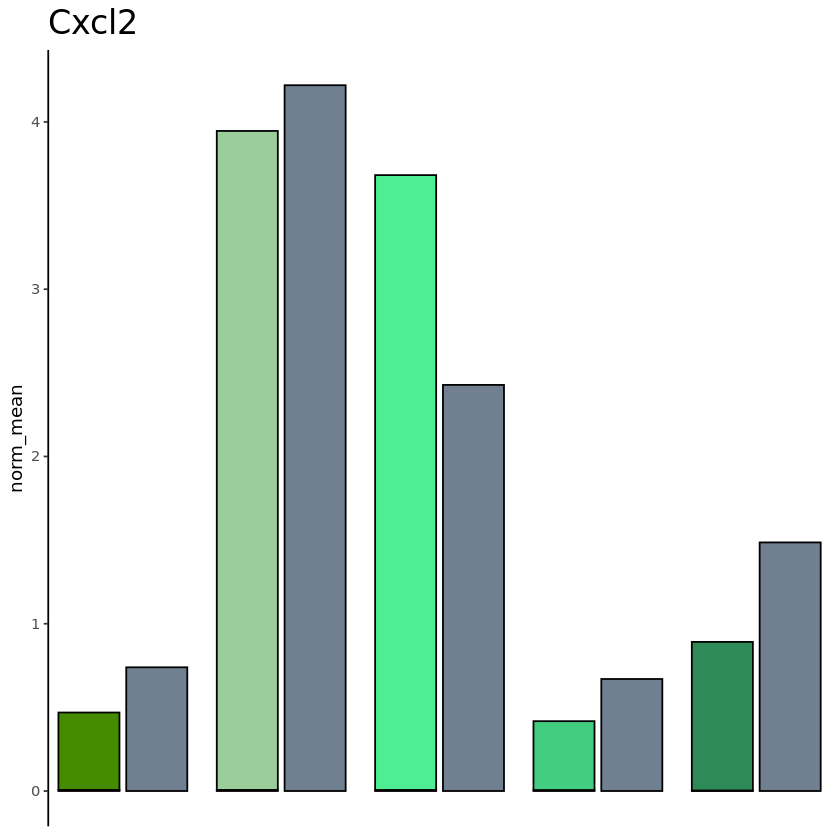

In [54]:
plot(p1)

In [55]:
full_genedata = full_genedata2

In [56]:
sum(parser_immune[analyzed_pics] == "AP high")

[1] 141

In [57]:
pic_counts = sapply(immune_pops, function(pop){sum(parser_immune[analyzed_pics] == pop)})

In [58]:
full_genedata$se = with(full_genedata, 2.576 * Sim_SD / (1000 ** 0.5))

In [59]:
per_comb_obs_exp = function(focus_gene){
    
    gene_df = full_genedata %>% 
        filter(gene == focus_gene) %>%
        mutate(immune_exp=Simulated_mean * (1 - epi_imm_ratio), 
               epithelial_exp=Simulated_mean * epi_imm_ratio) %>%
        select(Observed_mean, immune_exp, epithelial_exp, immune, epithelial, pic, gene) %>%
        melt(variable.name = "source", value.name = "norm_mean") %>%
        mutate(obs_exp = ifelse(source == "Observed_mean", "Observed", "Expected"),
               fill=factor(ifelse(source == 'immune_exp', 
                                  group.colors[immune], 
                                  ifelse(source == "epithelial_exp", 
                                         'orangered3', 
                                         "slategray")),
                           levels=c(group.colors, "slategray")))
    
    
    
    p1 = ggplot(gene_df, aes(x=obs_exp, y=norm_mean, fill=fill)) +
        geom_bar(stat='identity', position='stack', color='black', show.legend = F) +
        geom_errorbar(data=full_genedata %>% filter(gene == focus_gene) %>% mutate(obs_exp="Expected"),
                      aes(ymin=pmax(0, Simulated_mean - Sim_SD), ymax=Simulated_mean + Sim_SD, y=0, fill=NA), width=0.1) +
        scale_fill_identity() +
        facet_grid(~pic) +
        labs(title = focus_gene) +
        theme(strip.background = element_blank(), strip.text.x = element_blank(), plot.title = element_text(hjust=0, size=20),
              axis.title.x=element_blank(), axis.line.x=element_blank(), axis.ticks.x=element_blank(), 
              axis.text.x=element_blank())

    draw_dot = function(dot_df, side){
        ggplot(dot_df, aes(x=x, y=y, fill=fill)) +
        geom_point(color='black', pch=21, show.legend = F, size=10) +
        scale_fill_identity() + 
        facet_grid(~ pic) + 
        theme_void() +
        ylab("          ") +
        theme(strip.background = element_blank(), strip.text.x = element_blank(), axis.title.y = element_text(hjust = 1))
    }

    p2 = data.frame(x=0, y=0, pic=unique(gene_df$pic), fill=group.colors[str_replace(unique(gene_df$pic), '\\..*', '')]) %>%
        draw_dot

    p3 = data.frame(x=0, y=0, pic=unique(gene_df$pic), fill=group.colors[str_replace(unique(gene_df$pic), '.*\\.', '')]) %>%
        draw_dot

    p_unified = grid.arrange(p1, p2, p3, nrow=3, heights=c(19,1,1))
}

Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”


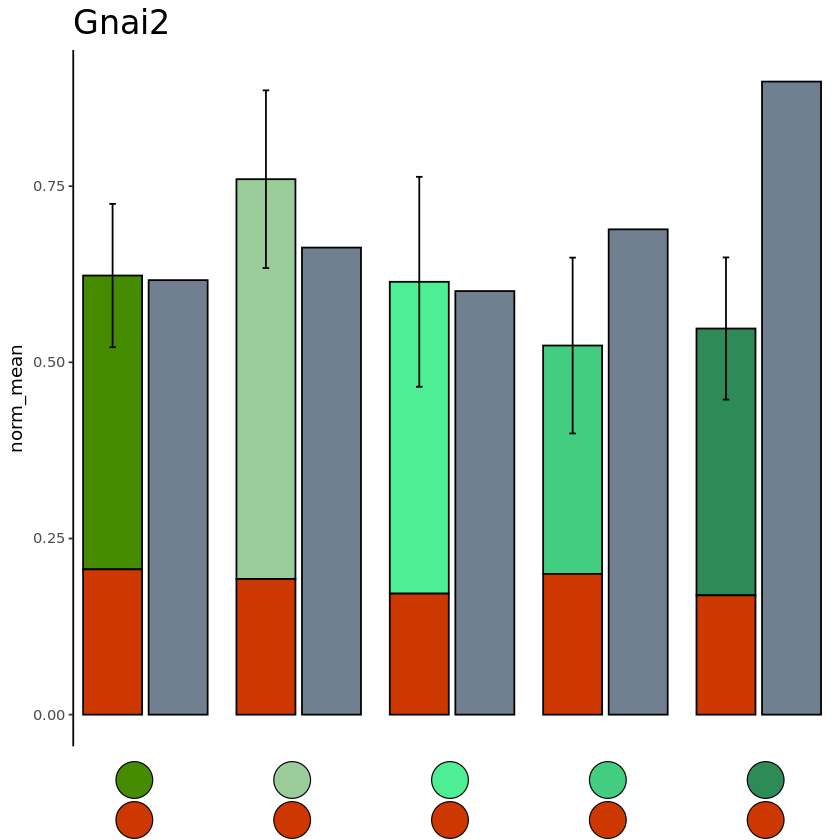

In [62]:
focus_genes = c('Gnai2')#c("Scamp3", "Bcl3", "Azin1", "Vegfa", "Lilrb4b", "Vegfb", "Rsad2", "Vapb", "Arhgef3", "Rock2", "Tnfaip3", 
              #  "Fabp4", "Lpl", "Fabp5", "Lalba", "Lap3", "Bst2", "Epas1", "Csn3")
for (gene in focus_genes){
    p = per_comb_obs_exp(gene)
    ggsave(paste0("final_figs/fig4/new_gene/gene_comb/", gene, ".png"), dpi=1200, plot=p)
    ggsave(paste0("final_figs/fig4/new_gene/gene_comb/", gene, ".emf"), plot=p,
           device = {function(filename, ...) devEMF::emf(file = filename, family = 'Arial')})
}

In [255]:
obs_gene_df = norm_mat[,focus_genes] %>% 
    as.data.frame %>%
    cbind(Neutrophil=parser_immune[rownames(.)]) %>% 
    rownames_to_column("cell") %>%
    filter(Neutrophil %in% immune_pops[3:7]) %>%
    melt(variable.name = 'Gene', value.name = 'norm_expr') %>%
    mutate(Neutorphil = factor(Neutrophil, levels = cell_order))

Using cell, Neutrophil as id variables



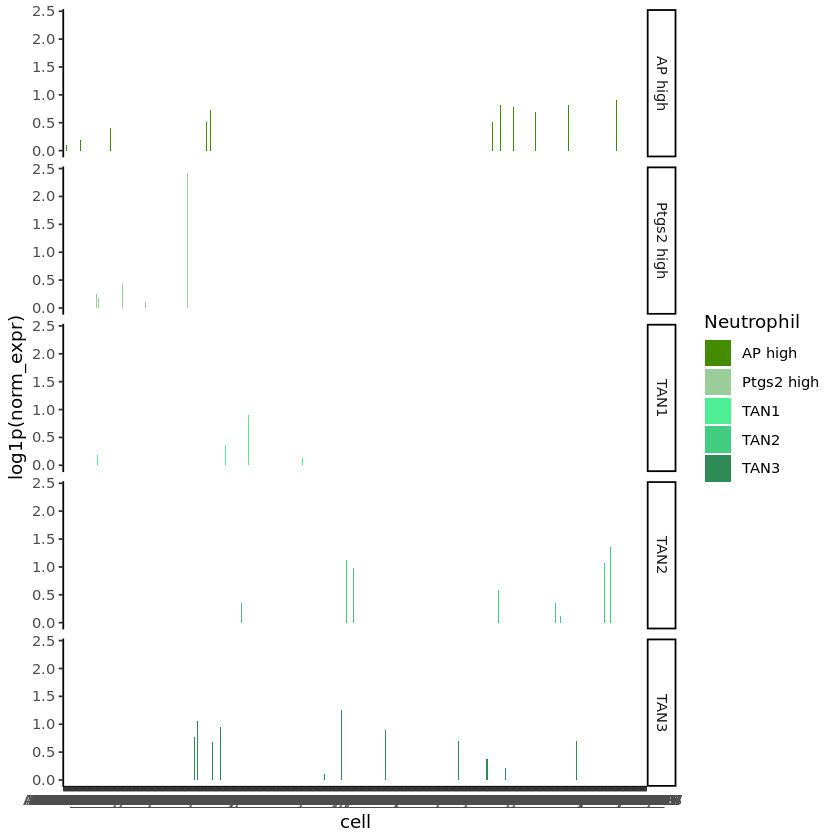

In [256]:
obs_gene_df %>%
    filter(Gene == "Vegfa") %>%
    arrange(norm_expr) %>%
    ggplot(aes(x=cell, y=log1p(norm_expr), fill=Neutrophil)) +
        geom_bar(stat='identity') +
        scale_fill_manual(values = group.colors) +
        facet_grid(rows = 'Neutrophil', scales = 'free_x')

In [266]:
for (gene in focus_genes){
    p = obs_gene_df %>%
        filter(Gene == gene) %>%
        arrange(norm_expr) %>%
        ggplot(aes(x=Neutrophil, y=log1p(norm_expr), fill=Neutrophil, color=Neutrophil)) +
            geom_violin(show.legend = F, color='black') +
            geom_jitter(show.legend = F) +
            geom_hline(yintercept = 0) +
            scale_fill_manual(values = group.colors) +
            scale_color_manual(values = group.colors) +
            labs(title = gene) +
            theme(axis.title.x = element_blank(), plot.title = element_text(size=16, face = 'bold', hjust = 0.5))
    ggsave(paste0("final_figs/fig4/new_gene/gene_comb/", gene, "_violin.png"), dpi=1200, plot=p)
    ggsave(paste0("final_figs/fig4/new_gene/gene_comb/", gene, "_violin.emf"), plot=p,
           device = {function(filename, ...) devEMF::emf(file = filename, family = 'Arial')})
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), 

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”
Warning message in grid.Call(C_textBounds, 

In [72]:
full_genedata2 = sapply(3:7, function(i){
    pop = immune_pops[i]
    read.csv(paste0("final_figs/fig4/new_gene_sd/", pop, "_genedata.csv"), row.names=1) %>% cbind(source_index=i) %>% as.matrix
}) %>% 
    do.call(rbind, .) %>% 
    rbind(read.csv(paste0("final_figs/fig4/new_gene_sd/TANs_merged_1012w_genedata.csv"), row.names=1) %>% cbind(source_index=NA) %>% as.matrix) %>%
    as.data.frame %>% 
    mutate(immune=immune_pops[source_index] %>% replace_na("10-12w TANs"), epithelial="AlvTumor") %>% 
    mutate(pic=paste(immune, epithelial, sep=".")) %>%
    rownames_to_column("gene") %>%
    mutate(gene = str_split_i(gene, "\\.", 1)) %>%
    select(-source_index, -immune, -epithelial) %>% 
    arrange(gene) 

In [74]:
write_csv(full_genedata2, "final_figs/fig4/full_obsexp_genedata.csv")

In [78]:
db_mat@cell_metadata[good_pics,c('Age', 'condition', 'Cell_type')] %>% table

, , Cell_type = EPCAM-CD45

     condition
Age   normal tumor
  3w       1     0
  6w       1     8
  8w       0     3
  10w      0    20
  12w      2   126

, , Cell_type = EPCAM-LY6G

     condition
Age   normal tumor
  3w       0     0
  6w       0     0
  8w       0    52
  10w      0   237
  12w      0   193
